#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# pipe's mass is different from vessel's mass

In [3]:
# TODO - Vessel model !!!!

In [4]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [5]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [6]:
# from diffeqpy import ode
# from diffeqpy import de

In [7]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [8]:
from sympy import *

In [9]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [10]:
mp = 96 #  (submerged) [kg/m]

In [11]:
node_N = 4

In [12]:
mi = [mp for i in range(node_N)] 

In [13]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 ## 32219000 # #   # mass of the vessel, [kg] !!!!!!!!!!!!!!!!!! Solitaire type vessel 

In [14]:
vessel_mass=mn/L # mass over length of vessel

In [15]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
Irho+=vessel_inertia

In [20]:
vessel_inertia_coef = vessel_inertia/np.max(diag_Irho)

In [21]:
vessel_inertia_coef

4839473437.5

In [22]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [23]:
diag_DT = 1.5*np.array([1, 1, 1]) 
# diag_DT = 1.5e15*np.array([1, 1, 1]) # [N/m]  , p.99 in [1] !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [24]:
DT=np.diag(diag_DT) # (35) in [2]

In [25]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [26]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [27]:
CT=np.diag(diag_CT)

In [28]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [29]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [30]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [31]:
rng = np.random.default_rng()

In [32]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [33]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [34]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.26758173,  0.16562014, -0.94919439],
       [-0.89073617,  0.41815691, -0.17814003],
       [ 0.36740862,  0.89314879,  0.259415  ]])

In [35]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002111


In [36]:
Ret

array([[[ 0.26758173,  0.16562014, -0.94919439],
        [-0.89073617,  0.41815691, -0.17814003],
        [ 0.36740862,  0.89314879,  0.259415  ]],

       [[ 0.34625171, -0.32210597,  0.88111151],
        [-0.54786749,  0.69298476,  0.4686292 ],
        [-0.76154512, -0.64499602,  0.06347577]],

       [[ 0.12887523,  0.11963891,  0.98441745],
        [ 0.30257257,  0.94061489, -0.15392682],
        [-0.94437335,  0.31769507,  0.08502251]],

       [[ 0.0831249 ,  0.24898942, -0.96493239],
        [-0.38342809,  0.90173302,  0.19965084],
        [ 0.91982235,  0.35338623,  0.170426  ]]])

In [37]:
Ret.shape

(4, 3, 3)

In [38]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [39]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [40]:
np.abs(dx)*dx

array([-3.33533598,  0.46563172, -0.07676146,  0.03637393])

In [41]:
C1(dx,dy,dz,Ret)

array([[ 0.57839733,  0.48430265, -0.06707911, -0.0236066 ],
       [ 2.81765192, -0.68084741, -0.27178606, -0.06675384],
       [ 1.96737968,  0.39763479,  0.07671604,  0.00390978]])

In [42]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [43]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000421


In [44]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [45]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([ 3319.44188188, 16170.59997333, 11290.85872936])

In [46]:
fD(dx,dy,dz,DT,Ret)

array([[ 3319.44188188,  2779.42933091,  -384.96930634,  -135.47907265],
       [16170.59997333, -3907.40640845, -1559.78943942,  -383.10252682],
       [11290.85872936,  2282.03956018,   440.27593634,    22.43837101]])

In [47]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3319.44188188, 16170.59997333, 11290.85872936],
       [ 2779.42933091, -3907.40640845,  2282.03956018],
       [ -384.96930634, -1559.78943942,   440.27593634],
       [ -135.47907265,  -383.10252682,    22.43837101]])

In [48]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000347


In [49]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [50]:
I=np.identity(3)

In [51]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000490


In [52]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [53]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [54]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [55]:
DR=np.diag(diag_DR) 

In [56]:
dI= 0.69# Inner diameter of pipe, [m]

In [57]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [61]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [62]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [63]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [64]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [65]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [66]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [67]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [68]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [69]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [70]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000137


In [71]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [72]:
phi(x,y,z,Ret,None)

array([[-30.55620285, -12.52919235, -17.3152526 ],
       [  6.22426664, -72.93931756,  70.09696128],
       [ -7.0106223 , 192.51919051,  59.2343861 ],
       [ 27.85533676, -96.54767471, -52.13231923]])

In [73]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [74]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000373


In [75]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [76]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [77]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000546


In [78]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [79]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000756


In [80]:
ωe(φ,θ,ψ,None,None)

array([[ 0.6230366 , -0.93692259,  0.42739367],
       [-0.59055957,  1.82071408,  1.31298379],
       [-0.16866342,  2.04900471, -1.11315028],
       [ 0.55535667, -2.25483049, -1.04668943]])

In [81]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [82]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 2.15779485e+01,  2.23394665e+02,  3.35674333e+02,
         1.64941136e+01],
       [-2.27149139e+00,  4.95687931e+01,  1.77945506e+01,
        -2.03855205e-01],
       [-3.64349412e+01,  3.17424016e+01, -1.81061474e+01,
         9.19066786e+00]])

In [83]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [84]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [85]:
# d_s(phi,x,y,z,Ret)

In [86]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000971


In [87]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [88]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [89]:
# sigma(x,y,z)

In [90]:
ne_(dx,dy,dz,DT,Ret)

array([[ -3319.44188188,  -2779.42933091,    384.96930634,
           135.47907265],
       [-16170.59997333,   3907.40640845,   1559.78943942,
           383.10252682],
       [-11419.02327159,  -2410.20410241,   -568.44047857,
          -150.60291324]])

In [91]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [92]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000922


In [93]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.52582192e+09, -2.41432232e+08, -2.47665623e+09],
       [ 2.67413278e+10,  2.40674173e+10,  1.30964025e+08],
       [ 5.57301546e+09,  1.54761387e+10, -1.24059487e+08],
       [ 1.13395805e+08,  1.46014747e+08,  2.40226890e+08]])

In [94]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000559


In [95]:
Re_b(Ret).shape

(4, 3, 3)

In [96]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [97]:
Irho_e(Ret)

array([[[6.93012429e+10, 2.65493813e+10, 8.72044063e+11],
        [7.67938221e+11, 1.69241421e+11, 3.07150457e+10],
        [1.30655224e+11, 7.72103885e+11, 6.51355785e+10]],

       [[1.16041130e+11, 1.00421258e+11, 7.51432300e+11],
        [2.90522098e+11, 4.64810018e+11, 2.12562572e+11],
        [5.61331460e+11, 4.02663412e+11, 3.89981506e+09]],

       [[1.60755927e+10, 1.38539292e+10, 9.37965166e+11],
        [8.86109123e+10, 8.56350996e+11, 2.29327789e+10],
        [8.63208183e+11, 9.76897619e+10, 6.99674299e+09]],

       [[6.68790894e+09, 6.00053375e+10, 9.01201441e+11],
        [1.42297072e+11, 7.87016892e+11, 3.85807238e+10],
        [8.18909706e+11, 1.20872458e+11, 2.81125227e+10]]])

In [98]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000173


In [99]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [100]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [101]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [102]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [103]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [104]:
# ωe(φ,θ,ψ,None)

In [105]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [106]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [107]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [108]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001874


In [109]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [110]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [111]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [112]:
ne_(dx,dy,dz,DT,Ret)

array([[ -3319.44188188,  -2779.42933091,    384.96930634,
           135.47907265],
       [-16170.59997333,   3907.40640845,   1559.78943942,
           383.10252682],
       [-11419.02327159,  -2410.20410241,   -568.44047857,
          -150.60291324]])

In [113]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [114]:
Re_b(Ret).shape

(4, 3, 3)

In [115]:
ne_(dx,dy,dz,DT, Ret).T

array([[ -3319.44188188, -16170.59997333, -11419.02327159],
       [ -2779.42933091,   3907.40640845,  -2410.20410241],
       [   384.96930634,   1559.78943942,   -568.44047857],
       [   135.47907265,    383.10252682,   -150.60291324]])

In [116]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-25.76498804, -97.76296921, 199.06615109, -98.54738453]),
 array([ 26.74389057, -24.24776363, -31.49898825, -55.03904274]),
 array([-1.82629022,  0.68237213, -0.27705859,  0.19071951]),
 numpy.ndarray,
 array([ 0.86479675, -0.21958924, -0.23711143, -0.15185143]))

In [117]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[  3953.03209352, -17941.51577025, -30043.63231451],
       [ -7124.06906196,   7008.44659764,  -2966.79435089],
       [    61.61107535,   3230.92999027,   -484.78805131],
       [   387.45087158,    646.54425258,     83.73028107]])

In [118]:
ne_(dx,dy,dz,DT,Ret).T

array([[ -3319.44188188, -16170.59997333, -11419.02327159],
       [ -2779.42933091,   3907.40640845,  -2410.20410241],
       [   384.96930634,   1559.78943942,   -568.44047857],
       [   135.47907265,    383.10252682,   -150.60291324]])

### Vessel

In [119]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [120]:
V=VesselSemisub()

In [121]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [122]:
tau_force = V.tau(η,dη, ddη)

In [123]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [124]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [125]:
V=VesselOtter()

In [126]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [127]:
tau_force = V.tau(η,dη, ddη)

In [128]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [129]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [130]:
# V=VesselSemisub()

In [131]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e6, 1.5e6
# kp,kd=1.95e8, 1.5e8
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [132]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [133]:
Hs = 2.5 # significant wave height in m

In [134]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [135]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [136]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [137]:
# def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
#     x,y,z,φ,θ,ψ=η
#     dx,dy,dz,dφ,dθ,dψ=dη
#     F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
#        +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
#       ).T
#     Ret=Re_t_([φ,θ,ψ])
    
#     ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
# #     ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     return ans
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
#     Ret=Re_t_([φ,θ,ψ])
    
#     ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans=np.concatenate( [F,[0,0,0]], axis=0)
#     ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [138]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[9750.            0.         7283.67179881    0.            0.
    0.        ]


### Static solution

In [139]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [140]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [141]:
Fx_0=82945396

In [142]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [143]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [144]:
Ws

array([941.76, 941.76, 941.76, 941.76])

In [145]:
delta_x=horizontal_length/(node_N-1)

In [146]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [147]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

In [148]:
length_p

[3685.0342622414496, 3691.484223043134, 3704.395427539594]

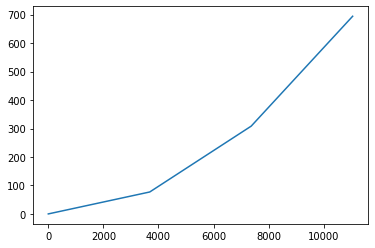

In [149]:
plt.plot(x0, z0)
plt.show()

In [150]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [151]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [152]:
Re_b(Ret),Ws

(array([[[ 0.26758173,  0.16562014, -0.94919439],
         [-0.89073617,  0.41815691, -0.17814003],
         [ 0.36740862,  0.89314879,  0.259415  ]],
 
        [[ 0.34625171, -0.32210597,  0.88111151],
         [-0.54786749,  0.69298476,  0.4686292 ],
         [-0.76154512, -0.64499602,  0.06347577]],
 
        [[ 0.12887523,  0.11963891,  0.98441745],
         [ 0.30257257,  0.94061489, -0.15392682],
         [-0.94437335,  0.31769507,  0.08502251]],
 
        [[ 0.0831249 ,  0.24898942, -0.96493239],
         [-0.38342809,  0.90173302,  0.19965084],
         [ 0.91982235,  0.35338623,  0.170426  ]]]),
 array([941.76, 941.76, 941.76, 941.76]))

In [153]:
np.einsum('it,ijk->ijk',Ws.reshape(node_N,1),Re_b(Ret))

array([[[ 251.99777089,  155.97442361, -893.9133069 ],
        [-838.85969647,  393.80345227, -167.76515794],
        [ 346.01073785,  841.1318076 ,  244.30667026]],

       [[ 326.0860063 , -303.34651867,  829.79557947],
        [-515.95968975,  652.62533176,  441.3362352 ],
        [-717.19273048, -607.43144762,   59.77893772]],

       [[ 121.36953384,  112.67113519,  927.08497407],
        [ 284.95074133,  885.8334813 , -144.96211926],
        [-889.37304258,  299.19250709,   80.07079637]],

       [[  78.28370345,  234.48827344, -908.73472972],
        [-361.09724049,  849.2160901 ,  188.02317097],
        [ 866.25189309,  332.80501729,  160.50039185]]])

In [154]:
np.einsum('i,ijk->ijk',Ws,Re_b(Ret))

array([[[ 251.99777089,  155.97442361, -893.9133069 ],
        [-838.85969647,  393.80345227, -167.76515794],
        [ 346.01073785,  841.1318076 ,  244.30667026]],

       [[ 326.0860063 , -303.34651867,  829.79557947],
        [-515.95968975,  652.62533176,  441.3362352 ],
        [-717.19273048, -607.43144762,   59.77893772]],

       [[ 121.36953384,  112.67113519,  927.08497407],
        [ 284.95074133,  885.8334813 , -144.96211926],
        [-889.37304258,  299.19250709,   80.07079637]],

       [[  78.28370345,  234.48827344, -908.73472972],
        [-361.09724049,  849.2160901 ,  188.02317097],
        [ 866.25189309,  332.80501729,  160.50039185]]])

In [155]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',Ws,Re_b(Ret)),Z).T 
#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [156]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [157]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [158]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [159]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [160]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [161]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [162]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [163]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

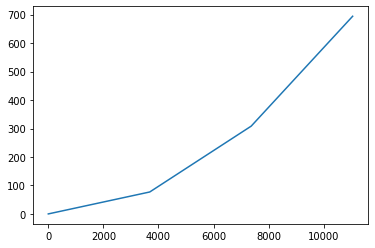

In [164]:
plt.plot(x0_, z0_)
plt.show()

In [165]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])

In [166]:
# q0[10*node_N]=q0[8*node_N]=0

In [167]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Dynamics

In [168]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 30 sec
    if t<10:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
#                             left - np.array([0,0,-70000,0,0,0])
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
#     print('ddη', ddη)
    coef=1
    tau_force = coef*V.tau(η,dη,ddη).astype(np.float32)
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        +Z0
       )
#     print(Z0, Z1, Z2)
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
#     hack2=1
#     hack4=1
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass/L],RRRR),Z).T 
    
#     for i in range(len(RRRR)):
      
#         a,b,c=np.linalg.lstsq((Ws[i] + vessel_mass)*[i]
# #                               +hack2*np.identity(3)
#                               , Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
# #         print(np.dot(Ws,RRRR[i]))
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
    
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))
    
    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     hack5=1
#     for i in range(len(A)):
# #         if i==len(A)-1:
# #             hack5=vessel_inertia_coef
#         a,b,c=np.linalg.lstsq(A[i]
# #                               +hack2*np.identity(3)
#                               ,B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ*=np.exp(-t)
#     ddθ*=np.exp(-t)
#     ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [169]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [170]:
# us=ode15s.integrate(10)

In [171]:
tspan = (0., 20)

In [172]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
6.711691000963923e-07
1.3423382001927847e-05
2.013507300289177e-05
5.369352800771139e-05
5.965947556412376e-05
6.711691000963923e-05
6.711691000963923e-05
0.00020135073002891768
0.0002684676400385569
0.0006040521900867531
0.0006637116656508769
0.0007382860101060316
0.0007382860101060316
0.0020806242102988162
0.0027517933103952084
0.00610763881087717
0.006704233566518407
0.007449977011069955
0.007449977011069955
0.020873359012997802
0.027585050013961724
0.061143505018781345
0.06710945257519373
0.0745668870207092
0.0745668870207092
0.09278791778254233
0.10189843316345891
0.1474510100680418
0.15554924596218983
0.1656720408298749
0.1656720408298749
0.08524558416448862
0.09058493273637833
0.11728167559582686
0.12202776321528438
0.12796037273960628
0.12796037273960628
0.1386390698833857
0.14397841845527543
0.17067516131472396
0.17542124893418148
0.18135385845850338
0.18135385845850338
0.19723245212623094
0.20517174896009474
0.24486823312941366
0.2519253858706259
0.26074682679714123
0.260

7.926949995566374
7.944912760340804
8.034726584212954
8.050693486234671
8.070652113761815
8.070652113761815
8.111794540840194
8.132365754379384
8.235221822075333
8.253507345221278
8.276364249153712
8.276364249153712
8.323421736100675
8.346950479574158
8.464594196941567
8.485508635584662
8.51165168388853
8.51165168388853
8.70540442669364
8.802280798096195
9.286662655108968
9.372774985244572
9.480415397914078
9.480415397914078
8.550402232449553
8.569777506730063
8.666653878132617
8.683876344159739
8.70540442669364
8.70540442669364
8.744154975254663
8.763530249535172
8.860406620937727
8.877629086964848
8.89915716949875
8.89915716949875
8.944358007940801
8.966958427161826
9.079960523266953
9.100049784796754
9.125161361709004
9.125161361709004
8.918496855151634
8.928166697978074
8.976515912110283
8.98511132795601
8.995855597763168
8.995855597763168
9.015195283416052
9.024865126242492
9.073214340374701
9.081809756220428
9.092554026027585
9.092554026027585
9.125670154819192
9.142228219214994


11.899398045582169
11.913799580024419
11.916359852814152
11.919560193801319
11.919560193801319
11.925308436296849
11.928182557544613
11.942553163783437
11.945107938225895
11.948301406278967
11.948301406278967
11.92225237300166
11.92359846260183
11.930328910602686
11.931525434691727
11.933021089803027
11.933021089803027
11.935713269003369
11.93705935860354
11.943789806604395
11.944986330693435
11.946481985804736
11.946481985804736
11.950471076581946
11.95246562197055
11.962438348913574
11.964211278147891
11.966427439690785
11.966427439690785
11.9710723615266
11.973394822444506
11.985007127034043
11.987071536738851
11.989652048869859
11.989652048869859
11.969699762038967
11.971335923213058
11.979516729083512
11.980971094571593
11.982789051431695
11.982789051431695
11.986061373779878
11.987697534953968
11.995878340824422
11.997332706312504
11.999150663172605
11.999150663172605
12.002245513677432
12.003792938929847
12.011530065191915
12.01290555430517
12.014624915696741
12.014624915696741


12.413170836317061
12.41404813837991
12.414486789411335
12.416680044568457
12.41706995659639
12.417557346631305
12.417557346631305
12.418427630228678
12.418862772027362
12.42103848102079
12.421425273730733
12.421908764618163
12.421908764618163
12.42271033743604
12.42311112384498
12.425115055889671
12.425471310475395
12.425916628707549
12.425916628707549
12.426657640460064
12.427028146336323
12.428880675717613
12.429210014274286
12.429621687470128
12.429621687470128
12.43037556500719
12.43075250377572
12.432637197618375
12.432972254301513
12.433391075155436
12.433391075155436
12.434216368789015
12.434629015605802
12.436692249689747
12.437059046860227
12.437517543323326
12.437517543323326
12.43837877573711
12.438809391944002
12.440962472978462
12.441345242940145
12.441823705392247
12.441823705392247
12.442614331633111
12.443009644753543
12.444986210355705
12.445337599796089
12.445776836596568
12.445776836596568
12.442507598797484
12.442849545500103
12.444559279013195
12.444863231637743
1

12.614126948383033
12.614373686985349
12.614373686985349
12.61483249156981
12.615061893862041
12.616208905323193
12.616412818471842
12.616667709907654
12.616667709907654
12.617155528764794
12.617399438193365
12.618618985336216
12.618835793717167
12.619106804193356
12.619106804193356
12.619597232471529
12.619842446610615
12.621068517306046
12.621286485429678
12.62155894558422
12.62155894558422
12.62201216668151
12.622238777230153
12.623371829973376
12.623573261572172
12.623825051070666
12.623825051070666
12.624241575256065
12.624449837348763
12.62549114781226
12.625676269672438
12.625907671997659
12.625907671997659
12.626331233438632
12.626543014159118
12.627601917761552
12.627790167290874
12.628025479202526
12.628025479202526
12.628495264111512
12.628730156566006
12.62990461883847
12.630113412131353
12.630374403747457
12.630374403747457
12.63087299088456
12.631122284453113
12.632368752295875
12.632590346579033
12.632867339432979
12.632867339432979
12.633327651828306
12.63355780802597
1

12.73938138937208
12.739672350886996
12.739817831644457
12.740545235431751
12.740674551660604
12.740836196946669
12.740836196946669
12.741140399588613
12.741292500909584
12.742053007514443
12.74218820868864
12.742357210156387
12.742357210156387
12.74270560776218
12.742879806565076
12.74375080057956
12.743905643959913
12.744099198185353
12.744099198185353
12.744468633187717
12.744653350688898
12.745576938194807
12.745741131529192
12.745946373197171
12.745946373197171
12.744427739644648
12.744592010374294
12.745413364022532
12.745559382448885
12.745741905481827
12.745741905481827
12.746070446941122
12.74623471767077
12.747056071319006
12.74720208974536
12.747384612778301
12.747384612778301
12.747714229260104
12.747879037501006
12.748703078705512
12.748849574919648
12.749032695187315
12.749032695187315
12.74934935076816
12.749507678558583
12.750299317510695
12.750440053324404
12.75061597309154
12.75061597309154
12.75091879398543
12.751070204432375
12.751827256667102
12.751961843731054
12.

12.832492342710813
12.831425461994806
12.831535149321343
12.832083585954036
12.83218108579985
12.832302960607114
12.832302960607114
12.832522335260192
12.83263202258673
12.833180459219422
12.833277959065235
12.8333998338725
12.8333998338725
12.83367313706613
12.833809788662945
12.834493046647022
12.83461451473308
12.834766349840653
12.834766349840653
12.835076204973326
12.835231132539663
12.836005770371347
12.836143483763646
12.836315625504021
12.836315625504021
12.835033443921995
12.835166990962668
12.835834726166027
12.835953434646623
12.83610182024737
12.83610182024737
12.836368914328713
12.836502461369385
12.837170196572744
12.83728890505334
12.837437290654087
12.837437290654087
12.837690016284977
12.83781637910042
12.838448193177644
12.838560515680262
12.838700918808534
12.838700918808534
12.838929569203856
12.839043894401515
12.839615520389817
12.839717142787737
12.839844170785138
12.839844170785138
12.840068081615742
12.840180037031043
12.840739814107554
12.840839330032267
12.84

12.903184749081294
12.903828963367754
12.903943490352013
12.904086649082338
12.904086649082338
12.903019077854191
12.903129506526579
12.903681649888515
12.903779808708414
12.903902507233289
12.903902507233289
12.904123364578062
12.90423379325045
12.904785936612386
12.904884095432285
12.90500679395716
12.90500679395716
12.905215843992007
12.905320369009429
12.905842994096545
12.905935905223144
12.906052044131393
12.906052044131393
12.906241067414374
12.906335579055865
12.906808137263317
12.906892147611309
12.906997160546299
12.906997160546299
12.907182268356337
12.907274822261355
12.90773759178645
12.907819861924246
12.907922699596488
12.907922699596488
12.908127008774782
12.908229163363929
12.908739936309662
12.908830740388904
12.908944245487955
12.908944245487955
12.909170208836906
12.909283190511381
12.90984809888376
12.90994852703885
12.910074062232711
12.910074062232711
12.910293023137331
12.91040250358964
12.910949905851192
12.9110472218088
12.911168866755812
12.911168866755812
12

12.963382289090694
12.963471584529499
12.963471584529499
12.963629045356495
12.963707775769993
12.964101427837482
12.964171410427259
12.964258888664478
12.964258888664478
12.964433636838773
12.96452101092592
12.964957881361656
12.965035547216898
12.965132629535951
12.965132629535951
12.965326729081639
12.965423778854483
12.9659090277187
12.96599529418345
12.966103127264388
12.966103127264388
12.966290895257648
12.966384779254279
12.966854199237428
12.966937651678878
12.967041967230688
12.967041967230688
12.966262559851065
12.966342276144404
12.966740857611097
12.966811716538508
12.966900290197774
12.966900290197774
12.967059722784452
12.96713943907779
12.967538020544483
12.967608879471895
12.96769745313116
12.96769745313116
12.967882530559375
12.967975069273482
12.968437762844019
12.968520019478781
12.968622840272234
12.968622840272234
12.968821232888239
12.96892042919624
12.969416410736251
12.969504585232253
12.969614803352256
12.969614803352256
12.968798806997706
12.96888679036044
12

13.015990979583329
13.015990979583329
13.016149456947272
13.016228695629241
13.016624889039097
13.016695323423072
13.01678336640304
13.01678336640304
13.016935754363018
13.017011948343008
13.017392918242955
13.017460646225167
13.017545306202933
13.017545306202933
13.017686882834377
13.017757671150099
13.018111612728706
13.018174535676016
13.01825318936015
13.01825318936015
13.018392410656046
13.018462021303995
13.018810074543733
13.018871950675242
13.01894929583963
13.01894929583963
13.01909879203334
13.019173540130195
13.019547280614473
13.019613723367232
13.019696776808184
13.019696776808184
13.019857973765511
13.019938572244175
13.020341564637494
13.02041320772964
13.020502761594821
13.020502761594821
13.020660504729662
13.020739376297081
13.02113373413418
13.02120384219411
13.02129147726902
13.02129147726902
13.020643405745819
13.020713727821317
13.02106533819881
13.021127846710364
13.021205982349807
13.021205982349807
13.021346626500804
13.021416948576302
13.021768558953795
13.021

13.060549175555847
13.060549175555847
13.060695364926453
13.060768459611756
13.06113393303827
13.061198906091873
13.061280122408876
13.061280122408876
13.061415150308985
13.061482664259039
13.06182023400931
13.061880246409359
13.06195526190942
13.06195526190942
13.061398938960474
13.061458347236272
13.061755388615266
13.061808195971532
13.061874205166864
13.061874205166864
13.061993021718463
13.06205242999426
13.062349471373254
13.06240227872952
13.062468287924853
13.062468287924853
13.062610209305092
13.062681169995212
13.06303597344581
13.063099049614806
13.06317789482605
13.06317789482605
13.063335395999157
13.063414146585712
13.063807899518483
13.063877900039865
13.063965400691592
13.063965400691592
13.063317776615527
13.063387717510267
13.063737421983964
13.063799591668175
13.063877303773442
13.063877303773442
13.06401718556292
13.06408712645766
13.064436830931356
13.064499000615568
13.064576712720834
13.064576712720834
13.06470993966419
13.064776553135868
13.065109620494257
13.06

13.100176736647576
13.100238092292932
13.100238092292932
13.10035882550843
13.10041919211618
13.100721025154925
13.100774684361813
13.100841758370423
13.100841758370423
13.100973051013566
13.101038697335136
13.101366928942992
13.101425281228835
13.101498221586136
13.101498221586136
13.101625116402651
13.10168856381091
13.102005800852199
13.102062198548428
13.102132695668715
13.102132695668715
13.101608941645527
13.101664301675223
13.101941101823703
13.101990310738987
13.102051821883094
13.102051821883094
13.102162541942485
13.102217901972182
13.102494702120662
13.102543911035946
13.102605422180053
13.102605422180053
13.102731693707174
13.102794829470735
13.10311050828854
13.103166628967259
13.10323677981566
13.10323677981566
13.1033715306255
13.10343890603042
13.103775783055017
13.103835672303836
13.103910533864857
13.103910533864857
13.104032261014046
13.104093124588642
13.104397442461616
13.104451543416811
13.104519169610805
13.104519169610805
13.10401261843068
13.10406366071359
13.1

13.135064833008004
13.135175682342144
13.135231107009213
13.135508230344563
13.135557496715291
13.135619079678703
13.135619079678703
13.135724766541754
13.13577760997328
13.13604182713091
13.136088799070043
13.136147513993961
13.136147513993961
13.136250559640926
13.136302082464407
13.136559696581818
13.136605494647135
13.136662742228783
13.136662742228783
13.136769389765576
13.13682271353397
13.13708933237595
13.137136731281192
13.137195979912743
13.137195979912743
13.137308802358909
13.137365213581994
13.13764726969741
13.137697413006817
13.137760092143576
13.137760092143576
13.137873522946478
13.137930238347929
13.138213815355181
13.13826422904536
13.138327246158083
13.138327246158083
13.138433475815638
13.138486590644415
13.138752164788304
13.13879937796944
13.13885839444586
13.13885839444586
13.138957922135054
13.139007685979651
13.139256505202637
13.139300739731167
13.13935603289183
13.13935603289183
13.139457951677372
13.139508911070143
13.139763708033996
13.139809005272014
13.1

13.168962619879471
13.169013568647113
13.16926831248532
13.169313600278779
13.169370210020602
13.169370210020602
13.16894823553366
13.168991992128397
13.169210775102076
13.169249669852952
13.169298288291548
13.169298288291548
13.16938580148102
13.169429558075755
13.169648341049436
13.169687235800312
13.169735854238908
13.169735854238908
13.169843193232968
13.169896862729997
13.170165210215146
13.170212916434728
13.170272549209205
13.170272549209205
13.170393373209876
13.17045378521021
13.170755845211886
13.17080954476774
13.170876669212557
13.170876669212557
13.17037821358926
13.170431045779287
13.170695206729425
13.170742168676115
13.17080087110948
13.17080087110948
13.170906535489534
13.170959367679561
13.1712235286297
13.17127049057639
13.171329193009754
13.171329193009754
13.171429208085558
13.171479215623458
13.171729253312966
13.171773704457769
13.17182926838877
13.17182926838877
13.17192057867101
13.17196623381213
13.172194509517729
13.17223509186539
13.172285819799969
13.172285

13.200240177006426
13.20029607852511
13.20029607852511
13.200389315555991
13.200435934071434
13.20066902664864
13.200710465329031
13.200762263679522
13.200762263679522
13.200378107553163
13.20041912206719
13.200624194637323
13.200660651983124
13.200706223665376
13.200706223665376
13.20078825269343
13.200829267207457
13.201034339777589
13.201070797123391
13.201116368805643
13.201116368805643
13.201213990659417
13.201262801586305
13.201506856220742
13.201550243711308
13.201604478074517
13.201604478074517
13.201712629819115
13.201766705691414
13.202037085052911
13.202085152494954
13.20214523679751
13.20214523679751
13.201700917745194
13.201749137580533
13.201990236757227
13.202033098833084
13.202086676427905
13.202086676427905
13.202183116098583
13.202231335933922
13.202472435110616
13.202515297186473
13.202568874781294
13.202568874781294
13.20266068787885
13.202706594427628
13.202936127171517
13.202976932992653
13.203027940269074
13.203027940269074
13.203112753551695
13.203155160193006
1

13.227502273053531
13.227536635343256
13.227579588205414
13.227579588205414
13.227665979898404
13.227709175744899
13.227925154977372
13.227963551285368
13.228011546670363
13.228011546670363
13.228107198511045
13.228155024431388
13.228394154033097
13.228436665962288
13.22848980587378
13.22848980587378
13.228581551374393
13.2286274241247
13.228856787876234
13.228897563654284
13.228948533376848
13.228948533376848
13.228567556821389
13.228606432295194
13.22880080966422
13.228835365640935
13.228878560611829
13.228878560611829
13.228956311559438
13.228995187033243
13.229189564402269
13.229224120378984
13.229267315349878
13.229267315349878
13.229358595358693
13.229404235363102
13.229632435385142
13.229673004277949
13.229723715393957
13.229723715393957
13.22982265086041
13.229872118593637
13.230119457259766
13.230163428578189
13.230218392726218
13.230218392726218
13.229811456052564
13.229855326381866
13.230074678028382
13.230113673876652
13.230162418686989
13.230162418686989
13.230250159345596

13.253575310521871
13.253648986594788
13.253685824631248
13.253870014813543
13.253902759734839
13.25394369088646
13.25394369088646
13.254019075169007
13.254056767310281
13.254245228016648
13.254278732142224
13.254320612299194
13.254320612299194
13.254403287303987
13.254444624806384
13.254651312318368
13.254688056764941
13.25473398732316
13.25473398732316
13.254820891355017
13.254864343370945
13.255081603450588
13.255120227464747
13.255168507482445
13.255168507482445
13.255249715263309
13.25529031915374
13.255493338605902
13.255529430952953
13.255574546386766
13.255574546386766
13.255240283527746
13.255276171550396
13.255455611663649
13.255487512128227
13.25552738770895
13.25552738770895
13.255599163754251
13.255635051776903
13.255814491890154
13.255846392354732
13.255886267935455
13.255886267935455
13.255970572400015
13.256012724632296
13.256223485793697
13.256260954444611
13.256307790258257
13.256307790258257
13.256400399548863
13.256446704194165
13.25667822742068
13.256719387105393
1

13.276736605074841
13.276736605074841
13.276814894845861
13.276854039731372
13.277049764158923
13.277084559612709
13.277128053929943
13.277128053929943
13.277206733003824
13.277246072540766
13.27744277022547
13.27747773870275
13.277521449299352
13.277521449299352
13.277595177097883
13.27763204099715
13.27781636049348
13.277849128403938
13.277890088292011
13.277890088292011
13.277959273200727
13.277993865655084
13.278166827926874
13.278197576775192
13.27823601283559
13.27823601283559
13.278306929709881
13.278342388147026
13.278519680332751
13.278551198943548
13.278590597207042
13.278590597207042
13.278668421842097
13.278707334159623
13.278901895747257
13.278936484473949
13.278979720382312
13.278979720382312
13.27906140827699
13.279102252224327
13.27930647196102
13.279342777691989
13.279388159855698
13.279388159855698
13.27946435131983
13.279502447051895
13.279692925712226
13.279726788585172
13.279769117176357
13.279769117176357
13.27945551782774
13.27948919681376
13.279657591743865
13.2

13.299707240003482
13.299746145504706
13.299940673010829
13.299975255678584
13.300018484013279
13.300018484013279
13.30010808470176
13.300152885046
13.3003768867672
13.300416709295414
13.300466487455681
13.300466487455681
13.300095026630673
13.300133297939372
13.30032465448286
13.300358673423924
13.300401197100255
13.300401197100255
13.30047773971765
13.300516011026348
13.300707367569837
13.3007413865109
13.300783910187231
13.300783910187231
13.300855536266877
13.300891349306701
13.301070414505816
13.30110224831899
13.30114204058546
13.30114204058546
13.300848211140837
13.300880361617638
13.301041114001649
13.301069692203251
13.301105414955254
13.301105414955254
13.301169715908859
13.30120186638566
13.301362618769671
13.301391196971274
13.301426919723276
13.301426919723276
13.301501494332001
13.301538781636362
13.301725218158172
13.301758362428716
13.301799792766897
13.301799792766897
13.30188131279165
13.301922072804027
13.302125872865911
13.302162103988024
13.302207392890665
13.30220

13.320483950718481
13.320658097183555
13.320689056555125
13.320727755769585
13.320727755769585
13.320797414355615
13.32083224364863
13.321006390113704
13.321037349485273
13.321076048699734
13.321076048699734
13.321144225859566
13.321178314439482
13.321348757339063
13.321379058298989
13.321416934498895
13.321416934498895
13.321481619676849
13.321513962265826
13.321675675210708
13.321704424178687
13.321740360388661
13.321740360388661
13.321803790384909
13.321835505383032
13.321994080373651
13.322022271483094
13.322057510369898
13.322057510369898
13.322123881162936
13.322157066559456
13.322322993542052
13.32235249167229
13.32238936433509
13.32238936433509
13.322459792901293
13.322495007184395
13.322671078599903
13.322702380184882
13.322741507166107
13.322741507166107
13.322811684610343
13.322846773332461
13.32302221694305
13.323053406918266
13.323092394387286
13.323092394387286
13.323157429054636
13.323189946388311
13.323352533056687
13.323381437353286
13.323417567724036
13.32341756772403

13.342391260722097
13.342553657848077
13.342582528448252
13.34261861669847
13.34261861669847
13.342680642056074
13.342711654734876
13.342866718128887
13.342894284954488
13.34292874348649
13.34292874348649
13.342989175714523
13.343019391828538
13.343170472398617
13.343197331166632
13.34323090462665
13.34323090462665
13.343293334800364
13.343324549887221
13.343480625321506
13.34350837206538
13.343543055495221
13.343543055495221
13.343609109577576
13.343642136618755
13.343807271824643
13.343836629194579
13.343873325906998
13.343873325906998
13.343939966554261
13.343973286877894
13.344139888496054
13.344169506561505
13.344206529143317
13.344206529143317
13.34426921545976
13.344300558617984
13.344457274409095
13.34448513499418
13.344519960725538
13.344519960725538
13.344578703441087
13.344608074798861
13.344754931587731
13.344781039461308
13.34481367430328
13.34481367430328
13.344873537473969
13.344903469059313
13.345053126986032
13.345079732839672
13.345112990156721
13.345112990156721
13.3

13.362131758279796
13.362162548355238
13.36220103594954
13.36220103594954
13.362263900059945
13.36229533211515
13.362452492391167
13.362480431995792
13.362515356501573
13.362515356501573
13.362253597421766
13.36227987815788
13.36241128183845
13.362434642492772
13.362463843310676
13.362463843310676
13.362516404782903
13.362542685519017
13.362674089199587
13.36269744985391
13.362726650671814
13.362726650671814
13.36279279397366
13.362825865624586
13.362991223879206
13.36302062090225
13.363057367181053
13.363057367181053
13.363132902417728
13.363170670036066
13.363359508127754
13.363393079344053
13.36343504336443
13.36343504336443
13.363122620119428
13.363155246588615
13.363318378934554
13.3633473802405
13.36338363187293
13.36338363187293
13.363448884811305
13.363481511280494
13.363644643626431
13.363673644932376
13.363709896564806
13.363709896564806
13.363771068143665
13.363801653933093
13.363954582880238
13.36398177024862
13.364015754459096
13.364015754459096
13.36407100235045
13.364098

13.381730235097848
13.381730235097848
13.381484976449446
13.381511614496896
13.381644804734144
13.381668482998544
13.381698080829043
13.381698080829043
13.381751356923942
13.381777994971392
13.38191118520864
13.38193486347304
13.38196446130354
13.38196446130354
13.382025548486045
13.382056092077296
13.382208810033557
13.382235959892448
13.382269897216062
13.382269897216062
13.382336017615497
13.382369077815214
13.3825343788138
13.382563765657993
13.382600499213234
13.382600499213234
13.382660827528138
13.382690991685589
13.382841812472849
13.38286862505725
13.382902140787753
13.382902140787753
13.382650747917928
13.382675872270275
13.382801494032007
13.382823826789648
13.382851742736701
13.382851742736701
13.382901991441395
13.382927115793741
13.383052737555474
13.383075070313115
13.383102986260168
13.383102986260168
13.383165963153921
13.383197451600797
13.383354893835177
13.383382883565735
13.38341787072893
13.38341787072893
13.383489520007469
13.38352534464674
13.383704467843089
13.

13.400059763262403
13.400088540426449
13.400088540426449
13.400140751619839
13.400166857216535
13.40029738520001
13.40032059017485
13.4003495963934
13.4003495963934
13.400406307162953
13.40043466254773
13.40057643947161
13.400601644258078
13.400633150241163
13.400633150241163
13.40069332398527
13.400723410857324
13.400873845217593
13.400900589103863
13.4009340189617
13.4009340189617
13.400991456077298
13.401020174635098
13.401163767424096
13.40118929503103
13.401221204539695
13.401221204539695
13.400985227168404
13.401010831271757
13.401138851788518
13.401161610991497
13.401190059995223
13.401190059995223
13.401241268201927
13.40126687230528
13.401394892822042
13.401417652025021
13.401446101028746
13.401446101028746
13.401504326242769
13.40153343884978
13.401679001884837
13.401704879757736
13.40173722709886
13.40173722709886
13.401799831727619
13.401831134041998
13.401987645613895
13.402015469893344
13.402050250242654
13.402050250242654
13.402107582673418
13.4021362488888
13.4022795799

13.416927828915984
13.416957578807912
13.416957578807912
13.41700667074166
13.417031216708535
13.417153946542907
13.417175765180128
13.417203038476655
13.417203038476655
13.417252172070794
13.417276738867866
13.417399572853215
13.417421410006165
13.417448706447354
13.417448706447354
13.417503068476767
13.417530249491474
13.417666154565005
13.417690315466967
13.417720516594418
13.417720516594418
13.417779539806263
13.417809051412185
13.417956609441797
13.417982841980395
13.418015632653642
13.418015632653642
13.41807195711899
13.418100119351662
13.41824093051503
13.41826596361074
13.418297254980377
13.418297254980377
13.418064413790164
13.418088804358426
13.418210757199732
13.418232437704853
13.418259538336255
13.418259538336255
13.418308319472777
13.418332710041039
13.418454662882345
13.418476343387466
13.418503444018867
13.418503444018867
13.418559994891098
13.418588270327213
13.41872964750779
13.418754781228781
13.41878619838002
13.41878619838002
13.418847451752958
13.418878078439425


13.432710356152409
13.432831471674527
13.432853003322904
13.432879917883374
13.432879917883374
13.432931297163684
13.43295698680384
13.433085435004616
13.433108270240309
13.433136814284925
13.433136814284925
13.433191503917055
13.43321884873312
13.433355572813445
13.433379879316615
13.433410262445575
13.433410262445575
13.43346410319179
13.433491023564898
13.433625625430436
13.433649554650975
13.43367946617665
13.43367946617665
13.433728667861939
13.433753268704582
13.433876272917802
13.433898140333485
13.43392547460309
13.43392547460309
13.43397183477885
13.433995014866731
13.434110915306132
13.434131519828693
13.434157275481892
13.434157275481892
13.434206405944323
13.434230971175538
13.434353797331612
13.434375633092692
13.434402927794043
13.434402927794043
13.434457989010879
13.434485519619296
13.434623172661382
13.43464764431331
13.434678233878218
13.434678233878218
13.43473501815941
13.434763410300008
13.434905371002989
13.434930608461295
13.43496215528418
13.43496215528418
13.43

13.448499585969266
13.448525071437304
13.44855692827235
13.44855692827235
13.448321680782408
13.448347412795147
13.448476072858837
13.448498945759047
13.448527536884312
13.448527536884312
13.448579000909787
13.448604732922526
13.448733392986215
13.448756265886425
13.44878485701169
13.44878485701169
13.448835085120447
13.448860199174824
13.448985769446715
13.449008093050606
13.449035997555471
13.449035997555471
13.449083631578814
13.449107448590487
13.449226533648845
13.449247704325886
13.449274167672188
13.449274167672188
13.44932102431405
13.449344452634982
13.449461594239638
13.4494824194138
13.4495084508815
13.4495084508815
13.449557626200404
13.449582213859857
13.449705152157117
13.449727007854406
13.44975432747602
13.44975432747602
13.449806470618206
13.4498325421893
13.449962900044769
13.449986074774628
13.450015043186955
13.450015043186955
13.450066834322309
13.450092729889985
13.45022220772837
13.450245226010749
13.450273998863723
13.450273998863723
13.450321940448815
13.450345

13.464611786126973
13.464633737611335
13.464743495033137
13.464763007463679
13.464787398001857
13.464787398001857
13.464838414845198
13.464863923266869
13.464991465375224
13.46501413952782
13.465042482218566
13.465042482218566
13.46509775012415
13.465125384076943
13.465263553840904
13.465288117354497
13.465318821746488
13.465318821746488
13.465092213805834
13.465117079599466
13.465241408567634
13.465263511495309
13.465291140154902
13.465291140154902
13.46534087174217
13.465365737535802
13.46549006650397
13.465512169431644
13.465539798091237
13.465539798091237
13.465588084079927
13.46561222707427
13.465732942045994
13.465754402485413
13.465781228034684
13.465781228034684
13.465826861213097
13.465849677802305
13.46596376074834
13.465984042160967
13.466009393926752
13.466009393926752
13.466054432334841
13.466076951538886
13.46618954755911
13.466209564629372
13.466234585967198
13.466234585967198
13.466282173473132
13.466305967226099
13.466424935990934
13.466446085993573
13.466472523496869


13.479177009213547
13.47922685573274
13.479251778992337
13.479376395290318
13.479398549298848
13.479426241809511
13.479426241809511
13.479219638435984
13.479240953047203
13.479347526103297
13.47936647242438
13.479390155325733
13.479390155325733
13.47943278454817
13.479454099159389
13.479560672215483
13.479579618536565
13.479603301437919
13.479603301437919
13.479652678708236
13.479677367343394
13.479800810519183
13.479822755972657
13.4798501877895
13.4798501877895
13.479903510310258
13.479930171570638
13.480063477872536
13.48008717677065
13.480116800393294
13.480116800393294
13.48016482675168
13.480188839930875
13.480308905826845
13.480330250875017
13.480356932185233
13.480356932185233
13.480156472392384
13.48017630839193
13.480275488389658
13.480293120389254
13.480315160388749
13.480315160388749
13.480354832387839
13.480374668387386
13.480473848385113
13.480491480384709
13.480513520384203
13.480513520384203
13.480564023673573
13.480589275318255
13.480715533541677
13.480737979448064
13.

13.493801119495268
13.493826296283979
13.493952180227526
13.493974559595266
13.494002533804943
13.494002533804943
13.493795223857909
13.493817452827937
13.493928597678083
13.493948356762553
13.493973055618142
13.493973055618142
13.4940175135582
13.49403974252823
13.494150887378375
13.494170646462845
13.494195345318433
13.494195345318433
13.494241737542419
13.494264933654412
13.494380914214375
13.494401532980591
13.49442730643836
13.49442730643836
13.494473713720554
13.494496917361651
13.494612935567137
13.49463356102589
13.49465934284933
13.49465934284933
13.494703434001131
13.494725479577031
13.494835707456533
13.494855303524
13.494879798608334
13.494879798608334
13.494921938152507
13.494943007924594
13.495048356785023
13.495067085471323
13.495090496329196
13.495090496329196
13.495133594440873
13.495155143496712
13.495262888775905
13.495282043492205
13.495305986887582
13.495305986887582
13.495352235268282
13.495375359458631
13.495490980410379
13.495511535246246
13.495537228791079
13.4

13.508100656349825
13.50812953648958
13.50812953648958
13.507916164935581
13.50793943978748
13.50805581404697
13.508076502804213
13.508102363750767
13.508102363750767
13.508148913454564
13.508172188306462
13.508288562565953
13.508309251323196
13.50833511226975
13.50833511226975
13.508378792520864
13.50840063264642
13.508509833274205
13.508529246719144
13.50855351352532
13.50855351352532
13.508593520813257
13.508613524457227
13.508713542677071
13.508731323693933
13.508753549965009
13.508753549965009
13.508793641195764
13.508813686811141
13.508913914888026
13.508931733212806
13.508954006118781
13.508954006118781
13.508998439695098
13.509020656483257
13.50913174042405
13.50915148868019
13.509176174000366
13.509176174000366
13.509224450042442
13.50924858806348
13.509369278168672
13.509390734187372
13.509417554210748
13.509417554210748
13.50946360938192
13.509486636967505
13.509601774895433
13.509622243860399
13.509647830066605
13.509647830066605
13.509457435942842
13.509477376808888
13.509

13.521013015166341
13.521042694954954
13.521042694954954
13.520821715725189
13.520844785159065
13.520960132328439
13.520980638491881
13.521006271196187
13.521006271196187
13.521052410063936
13.521075479497812
13.521190826667185
13.521211332830628
13.521236965534934
13.521236965534934
13.521279668719512
13.5213010203118
13.521407778273243
13.521426757466388
13.521450481457821
13.521450481457821
13.52127517884198
13.521294285495504
13.521389818763119
13.52140680245514
13.521428032070165
13.521428032070165
13.521466245377212
13.521485352030735
13.52158088529835
13.521597868990371
13.521619098605397
13.521619098605397
13.521663850892528
13.521686227036094
13.521798107753922
13.521817997659314
13.521842860041053
13.521842860041053
13.521892298109133
13.521917017143174
13.522040612313374
13.522062584788076
13.522090050381454
13.522090050381454
13.522135028352537
13.522157517338078
13.522269962265787
13.522289952475157
13.52231494023687
13.52231494023687
13.522126506340458
13.522144734319959


13.533533744298781
13.533553500420485
13.533553500420485
13.533589061439551
13.533606841949084
13.53369574449675
13.533711549394113
13.533731305515817
13.533731305515817
13.533776598844094
13.53379924550823
13.533912478828922
13.533932609197047
13.5339577721572
13.5339577721572
13.534009787874156
13.534035795732635
13.534165835025028
13.534188953121454
13.534217850741985
13.534217850741985
13.53400251950801
13.534024893183412
13.534136761560434
13.534156649271905
13.534181508911244
13.534181508911244
13.534226256262054
13.534248629937457
13.534360498314479
13.53438038602595
13.534405245665289
13.534405245665289
13.534446924841742
13.53446776442997
13.534571962371103
13.534590486449527
13.534613641547557
13.534613641547557
13.534442721154115
13.534461458898527
13.534555147620592
13.534571803393403
13.534592623109418
13.534592623109418
13.534630098598244
13.534648836342658
13.534742525064722
13.534759180837533
13.534780000553548
13.534780000553548
13.534823424407001
13.534845136333727
13

13.54563941652488
13.545680174283907
13.545700553163421
13.545802447560988
13.545820562120555
13.545843205320015
13.545843205320015
13.545880004981903
13.54589840481285
13.545990403967572
13.546006759372855
13.54602720362946
13.54602720362946
13.546063807147958
13.546082108907205
13.546173617703445
13.546189885933888
13.546210221221942
13.546210221221942
13.546251209632453
13.546271703837707
13.546374174863983
13.546392391935322
13.546415163274494
13.546415163274494
13.546460439321784
13.546483077345428
13.546596267463652
13.546616390151337
13.546641543510942
13.546641543510942
13.546684922339644
13.546706611753995
13.54681505882575
13.546834338305173
13.546858437654452
13.546858437654452
13.54667850869977
13.546696991294183
13.546789404266253
13.546805833239066
13.546826369455081
13.546826369455081
13.54686333464391
13.546881817238322
13.546974230210392
13.546990659183205
13.54701119539922
13.54701119539922
13.547054105400614
13.547075560401309
13.547182835404792
13.547201906516523
13

13.557230657935078
13.557252117111249
13.557359412992103
13.557378487815365
13.557402331344443
13.557402331344443
13.557445249696784
13.557466708872955
13.557574004753809
13.557593079577071
13.55761692310615
13.55761692310615
13.557656581199081
13.557676410245548
13.557775555477878
13.55779318129696
13.55781521357081
13.55781521357081
13.557652417845675
13.557670165215438
13.557758902064254
13.557774677504044
13.55779439680378
13.55779439680378
13.557829891543307
13.55784763891307
13.557936375761885
13.557952151201675
13.557971870501412
13.557971870501412
13.558013450867625
13.558034241050732
13.558138191966266
13.558156672129028
13.55817977233248
13.55817977233248
13.55822576310281
13.558248758487975
13.558363735413803
13.55838417575617
13.558409726184133
13.558409726184133
13.558451636292734
13.558472591347035
13.558577366618541
13.558595993333475
13.558619276727143
13.558619276727143
13.558443716942637
13.558460712321889
13.558545689218148
13.558560796221927
13.558579679976653
13.55

13.569099264270376
13.569099264270376
13.569142646775418
13.56916433802794
13.569272794290548
13.569292075403899
13.56931617679559
13.56931617679559
13.56935769081066
13.569378447818194
13.569482232855867
13.569500683529231
13.569523746870937
13.569523746870937
13.569351516831327
13.569369186849194
13.569457536938534
13.569473243621085
13.569492876974271
13.569492876974271
13.569528217010008
13.569545887027875
13.569634237117215
13.569649943799766
13.569669577152952
13.569669577152952
13.569710636267299
13.569731165824471
13.56983381361034
13.569852062105605
13.569874872724686
13.569874872724686
13.569919376235232
13.569941627990506
13.570052886766872
13.570072666104892
13.570097390277418
13.570097390277418
13.570137538560786
13.570157612702472
13.570257983410894
13.57027582709239
13.570298131694262
13.570298131694262
13.570130488276646
13.57014703727626
13.57022978227433
13.57024449249621
13.570262880273559
13.570262880273559
13.570295978272787
13.570312527272401
13.57039527227047
13.

13.58003248165946
13.580049512671323
13.58013466773064
13.580149806407853
13.580168729754368
13.580168729754368
13.58020853924203
13.58022844398586
13.580327967705015
13.580345660810643
13.580367777192677
13.580367777192677
13.580411773697437
13.580433771949817
13.580543763211717
13.580563317213832
13.580587759716476
13.580587759716476
13.580627949556161
13.580648044476003
13.580748519075215
13.580766381226187
13.5807887089149
13.5807887089149
13.5806204774069
13.580636836252111
13.580718630478168
13.580733171673913
13.580751348168592
13.580751348168592
13.580784065859016
13.580800424704227
13.580882218930284
13.580896760126029
13.580914936620708
13.580914936620708
13.580956096554454
13.580976676521328
13.581079576355691
13.581097869659578
13.581120736289437
13.581120736289437
13.581167681786294
13.581191154534723
13.581308518276867
13.581329382942137
13.581355463773724
13.581355463773724
13.581161446762657
13.581181801999266
13.581283578182315
13.581301671725969
13.581324288655535
13.

13.59110362876375
13.59118861366689
13.591203722094114
13.591222607628145
13.591222607628145
13.5912566015894
13.591273598570028
13.591358583473168
13.591373691900392
13.591392577434423
13.591392577434423
13.591431924934884
13.591451598685117
13.591549967436272
13.591567455214255
13.591589314936734
13.591589314936734
13.591631910723303
13.591653208616588
13.591759698083013
13.591778629543711
13.591802293869582
13.591802293869582
13.591840862852939
13.591860147344617
13.591956569803008
13.591973711573388
13.591995138786364
13.591995138786364
13.591834261873608
13.591850245875621
13.591930165885687
13.591944373887475
13.591962133889712
13.591962133889712
13.591994101893738
13.592010085895751
13.592090005905817
13.592104213907605
13.592121973909842
13.592121973909842
13.592162078110562
13.592182130210922
13.592282390712723
13.592300214801933
13.592322494913443
13.592322494913443
13.592368396307078
13.592391347003897
13.592506100487988
13.59252650110738
13.592552001881623
13.59255200188162

13.601861656644017
13.601885083219539
13.601885083219539
13.601923731748336
13.601943056012733
13.602039677334723
13.602056854458633
13.60207832586352
13.60207832586352
13.601916730325636
13.601932553878685
13.602011671643929
13.602025737024416
13.602043318750026
13.602043318750026
13.602074965856122
13.602090789409171
13.602169907174416
13.602183972554903
13.602201554280512
13.602201554280512
13.60224101394728
13.602260743780665
13.602359392947587
13.602376930577261
13.602398852614355
13.602398852614355
13.602443665137706
13.602466071399382
13.60257810270776
13.602598019384805
13.60262291523111
13.60262291523111
13.602437950474487
13.60245749940455
13.602555244054878
13.602572620881604
13.60259434191501
13.60259434191501
13.602633439775142
13.602652988705206
13.602750733355533
13.602768110182259
13.602789831215665
13.602789831215665
13.602826336550422
13.6028445892178
13.602935852554689
13.602952077147915
13.602972357889445
13.602972357889445
13.603005440094407
13.603021981196887
13.6

13.613344227170645
13.613344227170645
13.613388058012875
13.61340997343399
13.613519550539566
13.613539030913891
13.613563381381796
13.613563381381796
13.613382628089152
13.613401828548406
13.613497830844677
13.613514897919568
13.613536231763185
13.613536231763185
13.613574632681692
13.613593833140946
13.613689835437217
13.613706902512108
13.613728236355724
13.613728236355724
13.61376399131499
13.613781868794623
13.61387125619279
13.613887147285796
13.613907011152055
13.613907011152055
13.613939377284563
13.613955560350817
13.61403647568209
13.61405086062987
13.614068841814598
13.614068841814598
13.614101213657426
13.61411739957884
13.614198329185909
13.61421271667161
13.614230701028736
13.614230701028736
13.614266980430331
13.614285120131129
13.614375818635118
13.614391942813604
13.614412098036713
13.614412098036713
13.614451994229022
13.614471942325174
13.614571682805945
13.614589414446971
13.614611578998254
13.614611578998254
13.614649651967106
13.61466868845153
13.61476387087366
13

13.623932884976965
13.623932884976965
13.623967559872572
13.623984897320375
13.62407158455939
13.624086995624104
13.624106259454997
13.624106259454997
13.624142255142567
13.624160252986353
13.62425024220528
13.624266240288645
13.62428623789285
13.62428623789285
13.624322215024
13.624340203589576
13.624430146417449
13.624446136253516
13.624466123548599
13.624466123548599
13.62450052199215
13.624517721213927
13.624603717322808
13.624619005519941
13.62463811576636
13.62463811576636
13.624671202616558
13.624687746041657
13.62477046316715
13.624785168433906
13.624803550017349
13.624803550017349
13.624837286606567
13.624854154901175
13.62493849637422
13.624953490413873
13.624972232963438
13.624972232963438
13.625008084645458
13.625026010486467
13.625115639691513
13.62513157377241
13.625151491373533
13.625151491373533
13.625188415762734
13.625206877957334
13.625299188930336
13.625315599769982
13.625336113319538
13.625336113319538
13.625371394204468
13.62538903464693
13.625477236859254
13.6254

13.634527679295303
13.634549022898716
13.634655740915782
13.634674713007707
13.63469842812261
13.63469842812261
13.63452214813429
13.634540726157194
13.634633616271726
13.634650130069867
13.63467077231754
13.63467077231754
13.634707928363353
13.634726506386258
13.63481939650079
13.63483591029893
13.634856552546603
13.634856552546603
13.63489109396865
13.634908364679674
13.634994718234791
13.635010069977923
13.635029259656838
13.635029259656838
13.635060434430631
13.635076021817529
13.635153958752015
13.635167814207035
13.635185133525809
13.635185133525809
13.635216281212907
13.635231855056455
13.635309724274197
13.635323567690685
13.635340871961295
13.635340871961295
13.63537586222741
13.635393357360467
13.635480833025754
13.635496384255138
13.635515823291868
13.635515823291868
13.63555442857729
13.635573731220001
13.635670244433554
13.635687402338185
13.635708849718975
13.635708849718975
13.635745720641804
13.635764156103217
13.635856333410288
13.635872720487102
13.635893204333117
13.

13.64452677869542
13.64452677869542
13.644563576052686
13.64458197473132
13.644673968124485
13.644690322505491
13.64471076548175
13.64471076548175
13.644752722615923
13.644773701183007
13.644878594018437
13.644897241633625
13.644920551152609
13.644920551152609
13.644747324574006
13.644765604120135
13.644857001850774
13.64487325033622
13.644893560943029
13.644893560943029
13.644930120035283
13.644948399581413
13.645039797312052
13.645056045797498
13.645076356404306
13.645076356404306
13.645110320295252
13.645127302240725
13.64521221196809
13.645227307030733
13.645246175859036
13.645246175859036
13.645276825889614
13.6452921509049
13.645368775981343
13.645382398217155
13.64539942601192
13.64539942601192
13.645430063372121
13.64544538205222
13.64552197545272
13.645535592057254
13.64555261281292
13.64555261281292
13.64558704480029
13.645604260793975
13.645690340762398
13.645705643867895
13.645724772749768
13.645724772749768
13.64576275926339
13.6457817525202
13.645876718804253
13.645893601

13.654418381380003
13.654431249759657
13.654447335234225
13.654447335234225
13.654476289088448
13.65449076601556
13.654563150651114
13.654576019030769
13.654592104505337
13.654592104505337
13.654628258803125
13.65464633595202
13.654736721696493
13.654752790273287
13.654772875994281
13.654772875994281
13.654814010200258
13.654834577303246
13.654937412818189
13.654955694687512
13.654978547024166
13.654978547024166
13.654808834418812
13.654826813631079
13.654916709692408
13.654932691214421
13.65495266811694
13.65495266811694
13.65498862654147
13.655006605753737
13.655096501815066
13.65511248333708
13.655132460239598
13.655132460239598
13.65516587177373
13.6551825775408
13.655266106376134
13.655280955946859
13.655299517910267
13.655299517910267
13.655329708584372
13.655344803921423
13.655420280606682
13.655433698684062
13.655450471280787
13.655450471280787
13.65548067019654
13.655495769654419
13.655571266943806
13.65558468868414
13.65560146585956
13.65560146585956
13.655635370830039
13.655

13.664358072434617
13.664373644654187
13.66439310992865
13.66439310992865
13.664246632759346
13.664260987909776
13.664332763661923
13.664345523795637
13.664361473962781
13.664361473962781
13.66439018426364
13.66440453941407
13.664476315166217
13.664489075299931
13.664505025467076
13.664505025467076
13.664540496628849
13.664558232209734
13.664646910114165
13.664662675074954
13.664682381275938
13.664682381275938
13.664722516674948
13.664742584374451
13.664842922871976
13.664860760827091
13.664883058270986
13.664883058270986
13.664717696709861
13.664735354426822
13.664823643011632
13.664839338760041
13.664858958445555
13.664858958445555
13.664894273879478
13.66491193159644
13.665000220181248
13.665015915929658
13.665035535615171
13.665035535615171
13.665068424489148
13.665084868926137
13.66516709111108
13.665181708388403
13.665199979985056
13.665199979985056
13.665229819252502
13.665244738886225
13.665319337054838
13.665332598951482
13.665349176322284
13.665349176322284
13.665379039048737

13.674170917888386
13.674185632774119
13.674259207202791
13.674272287101223
13.67428863697426
13.67428863697426
13.67431806674573
13.674332781631463
13.674406356060135
13.674419435958567
13.674435785831605
13.674435785831605
13.674470119339043
13.674487286092761
13.674573119861353
13.674588379197992
13.674607453368791
13.674607453368791
13.674644936833493
13.674663678565844
13.6747573872276
13.674774046545245
13.674794870692303
13.674794870692303
13.674828849724097
13.674845839239993
13.674930786819477
13.674945888611386
13.674964765851271
13.674964765851271
13.674822800914724
13.674836766025935
13.67490659158199
13.674919005014177
13.674934521804412
13.674934521804412
13.674962452026833
13.674976417138044
13.6750462426941
13.675058656126286
13.67507417291652
13.67507417291652
13.675109104389108
13.675126570125402
13.675213898806868
13.675229423905796
13.675248830279456
13.675248830279456
13.675288802737168
13.675308788966024
13.675408720110307
13.675426485647067
13.675448692568018
13.

13.683890058754697
13.683903073549141
13.683919342042195
13.683919342042195
13.683948625329693
13.683963266973443
13.684036475192189
13.684049489986633
13.684065758479687
13.684065758479687
13.68409947871609
13.684116338834292
13.6842006394253
13.684215626197036
13.684234359661705
13.684234359661705
13.684270874845017
13.684289132436675
13.684380420394959
13.68439664936532
13.684416935578271
13.684416935578271
13.684450277554603
13.68446694854277
13.684550303483602
13.68456512213975
13.684583645459934
13.684583645459934
13.68444481640837
13.684458756823418
13.68452845889866
13.684540850378704
13.684556339728758
13.684556339728758
13.684584220558856
13.684598160973904
13.684667863049146
13.68468025452919
13.684695743879244
13.684695743879244
13.684729962883635
13.684747072385829
13.684832619896804
13.6848478283432
13.684866838901195
13.684866838901195
13.684905611123877
13.68492499723522
13.685021927791926
13.685039159890895
13.685060700014608
13.685060700014608
13.684901283470237
13.68

13.6933233624989
13.693394089907512
13.693406663669045
13.693422380870958
13.693422380870958
13.693450671834404
13.693464817316125
13.693535544724737
13.69354811848627
13.693563835688183
13.693563835688183
13.69359683785866
13.693613338943898
13.693695844370092
13.693710512001415
13.69372884654057
13.69372884654057
13.693765428224944
13.693783719067131
13.69387517327807
13.693891431804458
13.693911754962445
13.693911754962445
13.693945430712034
13.69396226858683
13.694046457960804
13.694061424960621
13.694080133710393
13.694080133710393
13.693939334774148
13.69395312468
13.694022074209261
13.694034331903351
13.694049654020965
13.694049654020965
13.694077233832669
13.69409102373852
13.694159973267782
13.694172230961872
13.694187553079486
13.694187553079486
13.694221493742209
13.694238464073571
13.69432331573038
13.694338400469368
13.694357256393102
13.694357256393102
13.694395603789285
13.694414777487376
13.694510645977832
13.694527689265025
13.694548993374015
13.694548993374015
13.6943

13.702819882161759
13.702819882161759
13.702848104764545
13.70286221606594
13.702932772572908
13.702945315951924
13.702960995175694
13.702960995175694
13.702989289301934
13.703003436365055
13.703074171680658
13.703086746847875
13.703102465806898
13.703102465806898
13.703134200459015
13.703150067785073
13.703229404415364
13.703243508705194
13.70326113906748
13.70326113906748
13.703296016064655
13.703313454563244
13.703400647056183
13.703416147943816
13.703435524053358
13.703435524053358
13.703468819148927
13.703485466696712
13.703568704435634
13.703583502255887
13.703601999531204
13.703601999531204
13.703464052083886
13.703478316099151
13.703549636175474
13.703562315300152
13.703578164206002
13.703578164206002
13.70360669223653
13.703620956251795
13.703692276328118
13.703704955452796
13.703720804358646
13.703720804358646
13.703753612924638
13.703770017207635
13.703852038622616
13.703866620207501
13.703884847188608
13.703884847188608
13.70392037403381
13.703938137456412
13.70402695456941

13.712368058418946
13.712405444741005
13.712424137902035
13.712517603707184
13.71253421985032
13.712554990029243
13.712554990029243
13.712401319522694
13.712417950074567
13.712501102833937
13.712515885546715
13.712534363937685
13.712534363937685
13.712567625041434
13.712584255593306
13.712667408352676
13.712682191065454
13.712700669456424
13.712700669456424
13.712731334813991
13.712746667492777
13.712823330886696
13.712836959934503
13.712853996244263
13.712853996244263
13.712881672867393
13.712895511178957
13.71296470273678
13.712977003458171
13.71299237935991
13.71299237935991
13.713020258440755
13.713034197981179
13.713103895683291
13.713116286385889
13.713131774764136
13.713131774764136
13.713163274341358
13.71317902412997
13.713257773073023
13.713271772885122
13.713289272650245
13.713289272650245
13.713323935410022
13.713341266789909
13.71342792368935
13.713443329360363
13.713462586449127
13.713462586449127
13.713495453753884
13.713511887406263
13.713594055668153
13.713608663359157

13.721974808420073
13.721989520781731
13.721989520781731
13.722016003032715
13.722029244158207
13.72209544978567
13.722107219674996
13.722121932036654
13.722121932036654
13.722154565233899
13.722170881832522
13.722252464825635
13.722266968468855
13.72228509802288
13.72228509802288
13.722322185558832
13.722340729326808
13.722433448166687
13.722449931516
13.722470535702639
13.722470535702639
13.7223180440371
13.72233451704421
13.72241688207976
13.722431524752746
13.72244982809398
13.72244982809398
13.722482774108201
13.72249924711531
13.72258161215086
13.722596254823847
13.72261455816508
13.72261455816508
13.722644849607919
13.722659995329337
13.722735723936433
13.722749186799916
13.722766015379271
13.722766015379271
13.722641819148183
13.722655449639735
13.72272360209749
13.72273571808998
13.722750863080593
13.722750863080593
13.722778124063696
13.722791754555248
13.722859907013003
13.722872023005493
13.722887167996106
13.722887167996106
13.722918921340973
13.722934798013407
13.72301418

13.731218976443342
13.731085248820968
13.731098931095286
13.731167342466877
13.731179504488493
13.731194707015513
13.731194707015513
13.731222071564149
13.731235753838467
13.731304165210059
13.731316327231674
13.731331529758695
13.731331529758695
13.73136334514684
13.731379252840913
13.73145879131128
13.73147293148379
13.731490606699426
13.731490606699426
13.731525339432448
13.73154270579896
13.731629537631518
13.73164497440175
13.73166427036454
13.73166427036454
13.7316959272113
13.73171175563468
13.73179089775158
13.731804967461251
13.73182255459834
13.73182255459834
13.731690450460938
13.731703540509137
13.731768990750131
13.731780626348531
13.73179517084653
13.73179517084653
13.731821350942928
13.731834440991127
13.731899891232121
13.73191152683052
13.73192607132852
13.73192607132852
13.731958328405392
13.731974456943828
13.732055099636007
13.732069436114617
13.73208735671288
13.73208735671288
13.73212401889232
13.73214234998204
13.732234005430637
13.73225029973261
13.7322706676100

13.739722367672387
13.739722367672387
13.739754630319183
13.739770761642582
13.739851418259573
13.739865757213703
13.739883680906368
13.739883680906368
13.739913357815013
13.739928196269336
13.740002388540946
13.74001557827812
13.74003206544959
13.74003206544959
13.740058833276755
13.74007221719034
13.740139136758255
13.740151033570328
13.740165904585421
13.740165904585421
13.740192905985145
13.740206406685006
13.740273910184316
13.740285910806415
13.74030091158404
13.74030091158404
13.740331470865108
13.740346750505642
13.740423148708315
13.740436730611012
13.740453707989383
13.740453707989383
13.740487350666411
13.740504172004925
13.740588278697498
13.7406032309984
13.740621921374526
13.740621921374526
13.740653795556401
13.740669732647339
13.740749418102027
13.740763584405082
13.740781292283902
13.740781292283902
13.740648998621792
13.740662537245425
13.74073023036359
13.740742264695708
13.740757307610856
13.740757307610856
13.740784384858122
13.740797923481756
13.74086561659992
13.

13.74844827973276
13.748483062179155
13.74850045340235
13.748587409518336
13.7486028683834
13.748622191964731
13.748622191964731
13.748654094081434
13.748670045139786
13.748749800431545
13.74876397915008
13.748781702548248
13.748781702548248
13.748647883637467
13.748660729473835
13.748724958655675
13.748736377176892
13.748750650328411
13.748750650328411
13.748776342001147
13.748789187837515
13.748853417019355
13.748864835540571
13.74887910869209
13.74887910869209
13.748910972072261
13.748926903762346
13.749006562212772
13.74902072371507
13.749038425592943
13.749038425592943
13.74907463434752
13.749092738724809
13.749183260611254
13.749199353391067
13.749219469365832
13.749219469365832
13.749070386345362
13.749086366721572
13.749166268602623
13.749180473381477
13.749198229355043
13.749198229355043
13.749230190107463
13.749246170483673
13.749326072364724
13.749340277143578
13.749358033117144
13.749358033117144
13.749387504657607
13.749402240427838
13.749475919278996
13.749489017741425
13

13.757568339727294
13.757597475864051
13.75761204393243
13.757684884274319
13.757697833668432
13.757714020411075
13.757714020411075
13.75774027295891
13.75775339923283
13.75781903060242
13.757830698401458
13.757845283150255
13.757845283150255
13.757871771061767
13.757885015017523
13.757951234796302
13.757963007201418
13.757977722707814
13.757977722707814
13.758007738665599
13.758022746644492
13.758097786538958
13.75811112696464
13.758127802496743
13.758127802496743
13.758160891826696
13.758177436491675
13.75826015981656
13.758274866185427
13.758293249146513
13.758293249146513
13.758324606367927
13.758340284978633
13.758418678032166
13.758432614575016
13.75845003525358
13.75845003525358
13.758319856500428
13.758333160177385
13.75839967856217
13.7584115040528
13.758426285916086
13.758426285916086
13.75845289327
13.758466196946957
13.758532715331743
13.758544540822372
13.758559322685658
13.758559322685658
13.758590207596496
13.758605650051916
13.758682862329012
13.75869658895605
13.758713

13.766697833107633
13.766728466484322
13.766743783172666
13.766820366614388
13.766833981448471
13.766850999991076
13.766850999991076
13.76688443781408
13.76690115672558
13.766984751283088
13.766999612537756
13.767018189106091
13.767018189106091
13.767048772110291
13.767064063612393
13.767140521122895
13.767154113569207
13.767171104127096
13.767171104127096
13.767043584196195
13.767056281741247
13.767119769466506
13.767131056173218
13.76714516455661
13.76714516455661
13.767170559646713
13.767183257191764
13.767246744917024
13.767258031623737
13.767272140007128
13.767272140007128
13.767303126915058
13.767318620369021
13.767396087638845
13.767409859597926
13.767427074546776
13.767427074546776
13.767462145523107
13.767479681011272
13.767567358452101
13.767582945552693
13.767602429428432
13.767602429428432
13.767458490033809
13.767474197777325
13.76755273649491
13.76756669893359
13.767584151981943
13.767584151981943
13.767615567468976
13.767631275212493
13.767709813930077
13.767723776368758

13.77584071355414
13.775855033476885
13.77592663309061
13.775939361910828
13.7759552729361
13.7759552729361
13.775981148397284
13.775994086127877
13.776058774780838
13.776070274985807
13.776084650242021
13.776084650242021
13.776110763842663
13.776123820642985
13.77618910464459
13.77620071068932
13.776215218245232
13.776215218245232
13.776244728969777
13.776259484332048
13.776333261143408
13.776346377020984
13.776362771867953
13.776362771867953
13.77639523004724
13.776411459136884
13.776492604585101
13.776507030442563
13.776525062764389
13.776525062764389
13.776555864145713
13.776571264836376
13.776648268289687
13.776661957792498
13.776679069671012
13.776679069671012
13.7765513125393
13.776564437426758
13.77663006186404
13.776641728430667
13.776656311638952
13.776656311638952
13.776682561413864
13.776695686301322
13.776761310738603
13.77677297730523
13.776787560513515
13.776787560513515
13.776817861628109
13.776833012185406
13.776908764971889
13.77692223213393
13.776939066086483
13.7769

13.784123041469114
13.784153864191316
13.784169275552417
13.784246332357922
13.784260031345568
13.784277155080124
13.784277155080124
13.784148254898776
13.784160861613607
13.784223895187765
13.784235101156503
13.784249108617427
13.784249108617427
13.78427432204709
13.78428692876192
13.784349962336078
13.784361168304816
13.78437517576574
13.78437517576574
13.784405762897412
13.78442105646325
13.784497524292432
13.784511118573175
13.784528111424104
13.784528111424104
13.78456248374897
13.784579669911405
13.784665600723573
13.784680877312402
13.78469997304844
13.78469997304844
13.784558892141188
13.784574282499731
13.784651234292445
13.784664914611149
13.78468201500953
13.78468201500953
13.784712795726614
13.784728186085157
13.784805137877871
13.784818818196575
13.784835918594956
13.784835918594956
13.78486440835327
13.784878653232427
13.784949877628215
13.78496253974302
13.784978367386529
13.784978367386529
13.785004241280507
13.785017178227497
13.785081862962443
13.785093362470878
13.78

13.792243381826289
13.792258710578807
13.792335354341397
13.79234897989919
13.792366011846433
13.792366011846433
13.792396669351469
13.792411998103987
13.792488641866576
13.79250226742437
13.792519299371612
13.792519299371612
13.792547621190016
13.792561782099218
13.792632586645228
13.792645174120073
13.792660908463631
13.792660908463631
13.792686574524406
13.792699407554794
13.792763572706734
13.792774979844857
13.79278923876751
13.79278923876751
13.79281505627623
13.792827965030593
13.792892508802398
13.792903983250717
13.792918326311119
13.792918326311119
13.79294733242507
13.792961835482046
13.793034350766927
13.793047242373127
13.793063356880879
13.793063356880879
13.793095218299285
13.793111149008489
13.793190802554504
13.793204963184907
13.79322266397291
13.79322266397291
13.793253074376674
13.793268279578554
13.79334430558796
13.793357821322966
13.793374715991723
13.793374715991723
13.793248769376453
13.793261822078223
13.79332708558708
13.793338687988655
13.793353190990622
13.

13.80090403651256
13.800979607155199
13.800993041936113
13.801009835412255
13.801009835412255
13.800884682402828
13.800897676540755
13.800962647230385
13.800974197575208
13.800988635506236
13.800988635506236
13.801014623782088
13.801027617920015
13.801092588609645
13.801104138954468
13.801118576885496
13.801118576885496
13.801148166715286
13.801162961630181
13.801236936204655
13.801250087240117
13.801266526034444
13.801266526034444
13.801298497620284
13.801314483413202
13.8013944123778
13.801408621971506
13.801426383963639
13.801426383963639
13.801455979649907
13.80147077749304
13.801544766708712
13.801557920347053
13.80157436239498
13.80157436239498
13.801451553888255
13.801464138850562
13.8015270636621
13.801538250295263
13.801552233586715
13.801552233586715
13.801577403511331
13.801589988473639
13.801652913285176
13.801664099918339
13.801678083209792
13.801678083209792
13.801707908551519
13.801722821222384
13.801797384576703
13.801810640284137
13.80182720991843
13.80182720991843
13.

13.809136375383517
13.80914945140999
13.809165796443079
13.809165796443079
13.809043824267464
13.80905639082856
13.809119223634042
13.809130393910571
13.809144356756233
13.809144356756233
13.809169489878425
13.809182056439521
13.809244889245003
13.809256059521532
13.809270022367194
13.809270022367194
13.809299639945989
13.809314448735385
13.80938849268237
13.809401656050724
13.809418110261165
13.809418110261165
13.80945100959622
13.809467459263747
13.809549707601382
13.809564329528074
13.809582606936438
13.809582606936438
13.809612710687704
13.809627762563338
13.809703021941505
13.809716401386511
13.809733125692771
13.809733125692771
13.809607110840915
13.809619362793153
13.809680622554348
13.80969151317856
13.809705126458825
13.809705126458825
13.809729630363302
13.80974188231554
13.809803142076735
13.809814032700947
13.809827645981212
13.809827645981212
13.809857711238257
13.80987274386678
13.809947907009391
13.809961269345855
13.809977972266436
13.809977972266436
13.810012102325057


13.816959921491316
13.816973333036035
13.816990097466935
13.816990097466935
13.817020273442553
13.817035361430364
13.817110801369413
13.817124212914132
13.817140977345032
13.817140977345032
13.8171688207503
13.817182742452935
13.81725235096611
13.817264725812896
13.817280194371378
13.817280194371378
13.817305426409234
13.817318042428163
13.817381122522802
13.817392336761849
13.817406354560658
13.817406354560658
13.817431751269279
13.81744444962359
13.817507941395142
13.817519228821196
13.817533338103763
13.817533338103763
13.817561886644247
13.817576160914491
13.817647532265704
13.81766022050592
13.817676080806189
13.817676080806189
13.817707460642803
13.81772315056111
13.817801600152645
13.817815546746695
13.817832979989259
13.817832979989259
13.817862942602053
13.817877923908451
13.817952830440436
13.817966147157234
13.81798279305323
13.81798279305323
13.817858696108024
13.817871554167407
13.81793584446432
13.817947273850438
13.817961560583084
13.817961560583084
13.81798727670185
13.

13.825193343158212
13.82520684569051
13.825223723855883
13.825223723855883
13.825251393962505
13.825265229015818
13.825334404282374
13.82534670210754
13.825362074388996
13.825362074388996
13.825248461276852
13.825260829987336
13.825322673539755
13.825333667949074
13.825347410960724
13.825347410960724
13.825372148381692
13.825384517092177
13.825446360644596
13.825457355053915
13.825471098065565
13.825471098065565
13.825500138322992
13.825514658451706
13.825587259095276
13.825600165876354
13.825616299352703
13.825616299352703
13.825648821722346
13.825665082907168
13.825746388831275
13.825760843217784
13.825778911200919
13.825778911200919
13.825809051915476
13.825824122272754
13.825899474059145
13.825912869932282
13.825929614773703
13.825929614773703
13.8258035158577
13.825815818186092
13.825877329828046
13.82588826523106
13.825901934484827
13.825901934484827
13.825926539141609
13.82593884147
13.826000353111954
13.826011288514968
13.826024957768736
13.826024957768736
13.826054634711726
13

13.833245554330004
13.833259036031825
13.833259036031825
13.8332833030951
13.833295436626738
13.833356104284928
13.833366889646383
13.833380371348204
13.833380371348204
13.833410100189354
13.83342496460993
13.83349928671281
13.833512499531098
13.83352901555396
13.83352901555396
13.833562660698894
13.833579483271361
13.833663596133697
13.833678549531445
13.83369724127863
13.83369724127863
13.833559081530623
13.833574114518957
13.833649279460616
13.83366264211691
13.833679345437279
13.833679345437279
13.833709411413942
13.833724444402275
13.833799609343934
13.833812972000228
13.833829675320597
13.833829675320597
13.833857266460782
13.833871062030877
13.833940039881341
13.833952302610312
13.833967631021526
13.833967631021526
13.833992485592136
13.83400491287744
13.834067049303965
13.834078095779791
13.834091903874574
13.834091903874574
13.834116935323747
13.834129451048334
13.834192029671264
13.834203154759786
13.834217061120437
13.834217061120437
13.834245400261423
13.834259569831916
13.

13.841678760068802
13.84169364486336
13.84171225085656
13.84171225085656
13.841574862317751
13.841589895017743
13.841665058517696
13.841678420917688
13.841695123917678
13.841695123917678
13.841725189317659
13.84174022201765
13.841815385517604
13.841828747917596
13.841845450917585
13.841845450917585
13.841872887830021
13.84188660628624
13.841955198567332
13.841967392750636
13.841982635479768
13.841982635479768
13.841870065887663
13.841882373372702
13.841943910797898
13.8419548507846
13.841968525767976
13.841968525767976
13.841993140738055
13.842005448223095
13.84206698564829
13.84207792563499
13.842091600618367
13.842091600618367
13.842120359286394
13.842134738620407
13.842206635290475
13.84221941692071
13.842235393958502
13.842235393958502
13.842267528253583
13.842283595401124
13.842363931138827
13.842378213047752
13.842396065433908
13.842396065433908
13.842425946289238
13.842440886716902
13.842515588855226
13.842528869235373
13.842545469710556
13.842545469710556
13.842420608975438
13.

13.850086746364713
13.850112882562293
13.850125950661083
13.850191291155031
13.850202907242844
13.85021742735261
13.85021742735261
13.850245795345396
13.850259979341788
13.850330899323748
13.850343507320542
13.850359267316533
13.850359267316533
13.850388993875237
13.85040385715459
13.850478173551354
13.850491385355221
13.850507900110058
13.850507900110058
13.850536153348893
13.85055027996831
13.850620913065395
13.850633470060433
13.85064916630423
13.85064916630423
13.850674704981284
13.850687474319809
13.850751321012442
13.850762671535577
13.850776859689496
13.850776859689496
13.850801584363309
13.850813946700214
13.850875758384742
13.850886747128659
13.850900483058554
13.850900483058554
13.850927474260667
13.850940969861723
13.851008447867004
13.851020443956832
13.851035439069117
13.851035439069117
13.851065619832747
13.851080710214564
13.851156162123642
13.851169575796366
13.851186342887273
13.851186342887273
13.851216615838212
13.85123175231368
13.851307434691025
13.851320889335886


13.858850097836994
13.858862204079186
13.858877336881925
13.858877336881925
13.858765369219716
13.858777483000937
13.858838051907043
13.858848819712572
13.858862279469484
13.858862279469484
13.858886507031926
13.858898620813147
13.858959189719252
13.858969957524781
13.858983417281694
13.858983417281694
13.859012072382852
13.859026399933429
13.859098037686321
13.859110773286837
13.859126692787479
13.859126692787479
13.859159006179894
13.8591751628761
13.859255946357138
13.859270307864877
13.859288259749553
13.859288259749553
13.859318187776593
13.85933315179011
13.859407971857708
13.85942127320306
13.859437899884748
13.859437899884748
13.85931249378602
13.85932461080425
13.859385195895415
13.859395966578289
13.859409429931882
13.859409429931882
13.859433663968348
13.85944578098658
13.859506366077744
13.859517136760617
13.85953060011421
13.85953060011421
13.85955986564426
13.859574498409284
13.859647662234405
13.85966066913665
13.859676927764454
13.859676927764454
13.859709808561645
13.8

13.86751646319809
13.867531347852
13.867605771121546
13.867619001925021
13.867635540429365
13.867635540429365
13.867510206394018
13.867521962645892
13.867580743905258
13.867591193906923
13.867604256409004
13.867604256409004
13.867627768912751
13.867639525164623
13.867698306423991
13.867708756425657
13.867721818927738
13.867721818927738
13.867751266069208
13.867765989639942
13.867839607493618
13.867852695112049
13.867869054635088
13.867869054635088
13.867902957387145
13.867919908763172
13.868004665643312
13.868019733533115
13.868038568395368
13.868038568395368
13.867899197575293
13.867914269045393
13.867989626395902
13.868003023258215
13.868019769336106
13.868019769336106
13.86804991227631
13.868064983746411
13.86814034109692
13.868153737959233
13.868170484037124
13.868170484037124
13.868197656595312
13.868211242874407
13.868279174269878
13.868291250962406
13.868306346828065
13.868306346828065
13.868194526126047
13.868206547170507
13.86826665239281
13.868277337765665
13.868290694481733


13.875386229319455
13.875401582186724
13.875401582186724
13.87542789325222
13.87544104878497
13.875506826448714
13.875518520255602
13.87553313751421
13.87553313751421
13.87555899453873
13.875571923050991
13.875636565612291
13.875648057623188
13.875662422636811
13.875662422636811
13.875689357840653
13.875702825442575
13.87577016345218
13.875782134653887
13.875797098656022
13.875797098656022
13.875825581496738
13.875839822917095
13.875911030018884
13.875923689059201
13.875939512859599
13.875939512859599
13.875968111541786
13.875982410882878
13.876053907588343
13.876066618113759
13.87608250627053
13.87608250627053
13.87610942764583
13.87612288833348
13.876190191771729
13.876202156827418
13.876217113147028
13.876217113147028
13.876242461024761
13.876255134963628
13.876318504657961
13.876329770381398
13.876343852535694
13.876343852535694
13.876369610123685
13.876382488917681
13.876446882887661
13.876458330704546
13.876472640475653
13.876472640475653
13.87650061141376
13.876514596882814
13.8

13.884117911166658
13.884147331493638
13.884162041657127
13.884235592474576
13.884248668175456
13.884265012801556
13.884265012801556
13.88414147224913
13.884153252790368
13.884212155496549
13.884222627088757
13.88423571657902
13.88423571657902
13.884259277661492
13.88427105820273
13.88432996090891
13.88434043250112
13.884353521991383
13.884353521991383
13.884382710828874
13.88439730524762
13.88447027734135
13.884483250158013
13.884499466178841
13.884499466178841
13.884532930644868
13.88454966287788
13.884633324042948
13.88464819713896
13.884666788508975
13.884666788508975
13.884529450869021
13.88454444321411
13.884619404939562
13.88463273146853
13.884649389629741
13.884649389629741
13.884679374319921
13.884694366665011
13.884769328390462
13.88478265491943
13.884799313080642
13.884799313080642
13.884826350500001
13.88483986920968
13.884907462758077
13.884919479388904
13.884934500177437
13.884934500177437
13.884823286575989
13.884835273323663
13.88489520706203
13.884905861948852
13.88491

13.893214664295222
13.893214664295222
13.893097281145685
13.893109816593725
13.893172493833921
13.8931836364544
13.89319756473
13.89319756473
13.89322263562608
13.893235171074119
13.893297848314315
13.893308990934795
13.893322919210394
13.893322919210394
13.893351190628172
13.89336532633706
13.893436004881503
13.893448569956071
13.89346427629928
13.89346427629928
13.89349486748006
13.893510163070449
13.893586641022399
13.893600237102746
13.893617232203178
13.893617232203178
13.893645947975857
13.893660305862197
13.893732095293892
13.893744857859527
13.89376081106657
13.89376081106657
13.893641948578358
13.89365430676595
13.8937160977039
13.893727082759534
13.893740814079079
13.893740814079079
13.893765530454258
13.89377788864185
13.8938396795798
13.893850664635435
13.89386439595498
13.89386439595498
13.893892868231934
13.89390710437041
13.893978285062794
13.893990939408107
13.894006757339747
13.894006757339747
13.894037982445177
13.894053594997892
13.894131657761468
13.894145535586103


13.902062305655681
13.902125982562469
13.902137302901453
13.902151453325184
13.902151453325184
13.90217569881244
13.90218782155607
13.902248435274215
13.90225921104633
13.902272680761472
13.902272680761472
13.902298870399013
13.902311965217784
13.902377439311637
13.902389079150545
13.902403628949179
13.902403628949179
13.902433210379556
13.902448001094745
13.902521954670691
13.902535101973081
13.902551536101068
13.902551536101068
13.90258185952673
13.902597021239561
13.902672829803718
13.90268630688179
13.90270315322938
13.90270315322938
13.902578537393191
13.902592038039254
13.902659541269564
13.90267154184384
13.902686542561687
13.902686542561687
13.90271354385381
13.902727044499873
13.902794547730183
13.90280654830446
13.902821549022306
13.902821549022306
13.902849256546459
13.902863110308536
13.902932379118917
13.902944693574096
13.90296008664307
13.90296008664307
13.90298775887221
13.903001594986783
13.903070775559637
13.903083074328144
13.903098447788778
13.903098447788778
13.903

13.910567500754324
13.910456766252752
13.910468718137341
13.910528477560282
13.910539101457694
13.910552381329458
13.910552381329458
13.910576285098633
13.910588236983223
13.910647996406164
13.910658620303575
13.91067190017534
13.91067190017534
13.910700238032803
13.910714406961535
13.910785251605194
13.910797846208512
13.910813589462657
13.910813589462657
13.910845658047112
13.91086169233934
13.91094186380048
13.91095611650468
13.910973932384934
13.910973932384934
13.91100369793647
13.91101858071224
13.911092994591082
13.911106223725097
13.911122760142618
13.911122760142618
13.910998004865146
13.911010041105252
13.911070222305783
13.911080921185878
13.911094294785995
13.911094294785995
13.911118367266207
13.911130403506313
13.911190584706844
13.911201283586939
13.911214657187056
13.911214657187056
13.91124354600304
13.911257990411032
13.911330212450991
13.911343051924764
13.911359101266976
13.911359101266976
13.911391475667678
13.91140766286803
13.911488598869786
13.91150298749232
13.

13.919264576796362
13.91933018725821
13.919341851340315
13.919356431442948
13.919356431442948
13.919382024649641
13.919394821252986
13.919458804269718
13.919470179028249
13.919484397476412
13.919484397476412
13.9195109397786
13.919524210929696
13.91959056668517
13.91960236326392
13.919617108987358
13.919617108987358
13.91964531745295
13.919659421685747
13.919729942849726
13.919742479945544
13.919758151315317
13.919758151315317
13.9197867551749
13.919801057104692
13.919872566753652
13.919885279580132
13.919901170613235
13.919901170613235
13.919928193989643
13.919941705677846
13.920009264118866
13.92002127450838
13.920036287495273
13.920036287495273
13.92006151945336
13.920074135432403
13.92013721532762
13.920148429531213
13.920162447285707
13.920162447285707
13.920187770627644
13.92020043229861
13.920263740653452
13.920274995472091
13.920289063995389
13.920289063995389
13.920316530276418
13.920330263416934
13.920398929119509
13.920411136355522
13.920426395400538
13.920426395400538
13.92

13.928563205880726
13.928634440913418
13.92864710491923
13.928662934926495
13.928662934926495
13.92869438398665
13.928710108516729
13.928788731167119
13.928802708527188
13.928820180227275
13.928820180227275
13.928849203518935
13.928863715164763
13.92893627339391
13.928949172634649
13.92896529668557
13.92896529668557
13.928844214434712
13.928856231538429
13.92891631705702
13.928926998926991
13.928940351264457
13.928940351264457
13.928964385471893
13.92897640257561
13.929036488094201
13.929047169964173
13.929060522301638
13.929060522301638
13.929089197142805
13.929103534563387
13.929175221666302
13.929187966040153
13.929203896507468
13.929203896507468
13.929236058247609
13.92925213911768
13.929332543468028
13.929346837574757
13.929364705208169
13.929364705208169
13.929394088606006
13.929408780304927
13.929482238799523
13.92949529808745
13.92951162219736
13.92951162219736
13.929388360574958
13.929400188258354
13.929459326675328
13.929469840171679
13.929482982042117
13.929482982042117
13.9

13.93783375759735
13.937849961959023
13.937849961959023
13.937880383360374
13.93789559406105
13.93797164756443
13.937985168187252
13.938002068965782
13.938002068965782
13.938029483714942
13.938043191089521
13.938111727962422
13.938123912295383
13.938139142711583
13.938139142711583
13.938025760582136
13.938037606390314
13.938096835431198
13.938107365038466
13.938120527047552
13.938120527047552
13.938144218663906
13.938156064472082
13.938215293512968
13.938225823120236
13.938238985129322
13.938238985129322
13.938267413302391
13.938281627388927
13.9383526978216
13.938365332565185
13.938381125994669
13.938381125994669
13.938413458020001
13.938429624032668
13.938510454095999
13.938524823885036
13.938542786121332
13.938542786121332
13.938572558745335
13.938587445057337
13.938661876617344
13.938675108894678
13.938691649241347
13.938691649241347
13.93856656269317
13.938578450979088
13.938637892408682
13.938648459773944
13.93866166898052
13.93866166898052
13.938685445552359
13.938697333838277
1

13.947067447775904
13.947142953432762
13.947156376660649
13.947173155695506
13.947173155695506
13.947049289993968
13.947062862800058
13.947130726830506
13.94714279154703
13.947157872442686
13.947157872442686
13.947185018054865
13.947198590860955
13.947266454891404
13.947278519607927
13.947293600503583
13.947293600503583
13.947321057256266
13.947334785632608
13.947403427514313
13.947415630515506
13.947430884266996
13.947430884266996
13.947458014616084
13.947471579790626
13.947539405663344
13.947551463596271
13.947566536012431
13.947566536012431
13.94759302618292
13.947606271268164
13.947672496694388
13.947684270103494
13.947698986864877
13.947698986864877
13.947725267711593
13.947738408134951
13.94780411025174
13.94781579062806
13.947830391098456
13.947830391098456
13.947857206788697
13.94787061463382
13.947937653859423
13.947949571943974
13.947964469549664
13.947964469549664
13.947992021710412
13.948005797790787
13.948074678192656
13.948086923597433
13.948102230353404
13.94810223035340

13.956681832602293
13.956693254117734
13.956707531012038
13.956707531012038
13.956734225091079
13.956747572130599
13.956814307328202
13.956826171363332
13.956841001407243
13.956841001407243
13.956869093201531
13.956883139098673
13.956953368584392
13.956965853826299
13.95698146037868
13.95698146037868
13.957009641259793
13.957023731700348
13.957094183903129
13.957106708739179
13.957122364784242
13.957122364784242
13.957149029106182
13.95716236126715
13.957229022071997
13.95724087288175
13.957255686393937
13.957255686393937
13.957280936721379
13.9572935618851
13.957356687703705
13.957367910071456
13.957381938031146
13.957381938031146
13.957407557689328
13.957420367518417
13.957484416663869
13.957495803178617
13.95751003632205
13.95751003632205
13.957537639613816
13.9575514412597
13.957620449489115
13.957632717618788
13.95764805278088
13.95764805278088
13.957677080276873
13.95769159402487
13.957764162764855
13.957777063874184
13.957793190260848
13.957793190260848
13.957821124284076
13.957

13.96546457204926
13.96546457204926
13.965488012628285
13.965499732917795
13.965558334365355
13.965568752400477
13.96558177494438
13.96558177494438
13.965610554252475
13.965624943906521
13.965696892176759
13.965709682980357
13.965725671484854
13.965725671484854
13.965758527422297
13.96577495539102
13.965857095234627
13.96587169787349
13.96588995117207
13.96588995117207
13.965919578098328
13.965934391561458
13.966008458877102
13.966021626399883
13.96603808580336
13.96603808580336
13.9659130669369
13.965924624819314
13.965982414231387
13.965992687904645
13.966005529996217
13.966005529996217
13.966028645761046
13.96604020364346
13.966097993055534
13.966108266728792
13.966121108820364
13.966121108820364
13.966150107599521
13.966164606989098
13.96623710393699
13.966249992283283
13.966266102716148
13.966266102716148
13.966299588092836
13.96631633078118
13.966400044222901
13.96641492661254
13.96643352959959
13.96643352959959
13.96629595491946
13.966310881021116
13.966385511529394
13.966398779

13.974069698746225
13.974085326195755
13.974085326195755
13.974111988068849
13.974125319005394
13.974191973688125
13.9742038234095
13.974218635561218
13.974218635561218
13.974243851905207
13.974256460077202
13.974319500937172
13.974330708201167
13.974344717281161
13.974344717281161
13.974370222380053
13.974382974929497
13.974446737676727
13.974458073276235
13.974472242775619
13.974472242775619
13.974499676451472
13.974513393289401
13.974581977479037
13.97459417022386
13.97460941115489
13.97460941115489
13.97463830592859
13.97465275331544
13.974724990249689
13.974737832371332
13.974753885023388
13.974753885023388
13.974781792219908
13.974795745818167
13.974865513809466
13.97487791700792
13.974893421005985
13.974893421005985
13.974918893389068
13.97493162958061
13.974995310538317
13.975006631597465
13.9750207829214
13.9750207829214
13.97504517480896
13.97505737075274
13.97511835047164
13.975129191310556
13.9751427423592
13.9751427423592
13.975168794763979
13.975181820966368
13.9752469519

13.982821933120926
13.982847357935105
13.982860070342195
13.982923632377643
13.982934932295056
13.982949057191822
13.982949057191822
13.982973442368237
13.982985634956446
13.983046597897486
13.98305743575367
13.983070983073901
13.983070983073901
13.983097029798317
13.983110053160527
13.98317516997157
13.983186746293534
13.983201216695987
13.983201216695987
13.983230104599643
13.983244548551472
13.983316768310612
13.983329607378904
13.983345656214269
13.983345656214269
13.983375125793259
13.983389860582756
13.983463534530234
13.983476632120896
13.983493004109224
13.983493004109224
13.98351969946867
13.983533047148395
13.98359978554701
13.983611650151209
13.983626480906457
13.983626480906457
13.983516821234971
13.983528729797843
13.98358827261221
13.98359885800143
13.983612089737957
13.983612089737957
13.983635906863704
13.983647815426576
13.983707358240942
13.983717943630163
13.983731175366689
13.983731175366689
13.983759152390828
13.983773140902898
13.983843083463247
13.983855517696197

13.990709596582102
13.990725137594907
13.990725137594907
13.990756755868167
13.990772565004798
13.99085161068795
13.990865663253842
13.99088322896121
13.99088322896121
13.990912584274046
13.990927261930466
13.991000650212559
13.991013697018264
13.991030005525396
13.991030005525396
13.990907075343284
13.990918998534323
13.99097861448951
13.990989212881543
13.991002460871584
13.991002460871584
13.991026307253659
13.991038230444698
13.991097846399885
13.991108444791918
13.99112169278196
13.99112169278196
13.991150145148383
13.991164371331596
13.991235502247658
13.991248147743846
13.991263954614082
13.991263954614082
13.991295723411971
13.991311607810916
13.99139102980564
13.991405149271369
13.99142279860353
13.99142279860353
13.991451710973045
13.991466167157803
13.99153844808159
13.991551298023596
13.991567360451105
13.991567360451105
13.9914461714831
13.991457857922883
13.991516290121806
13.991526678068283
13.991539663001376
13.991539663001376
13.991563035880946
13.99157472232073
13.991

13.998637662000007
13.998637662000007
13.99866995792136
13.998686105882037
13.99876684568542
13.998781199428244
13.998799141606773
13.998799141606773
13.99882836947943
13.99884298341576
13.998916053097405
13.998929043263031
13.998945280970062
13.998945280970062
13.998822219414949
13.998833758319037
13.998891452839477
13.99890170964311
13.998914530647653
13.998914530647653
13.99893760845583
13.998949147359918
13.999006841880357
13.999017098683991
13.999029919688533
13.999029919688533
13.9990585586521
13.999072878133886
13.999144475542804
13.999157203971055
13.999173114506371
13.999173114506371
13.999205951085804
13.999222369375518
13.999304460824098
13.9993190548594
13.99933729740353
13.99933729740353
13.999202528374292
13.999217235308253
13.999290769978057
13.999303842808244
13.999320183845978
13.999320183845978
13.999349597713898
13.999364304647859
13.999437839317663
13.99945091214785
13.999467253185584
13.999467253185584
13.999493794345085
13.999507064924837
13.999573417823592
13.999

14.006319172663282
14.006378302306594
14.006388814243182
14.006401954163918
14.006401954163918
14.006425606021242
14.006437431949905
14.006496561593217
14.006507073529805
14.00652021345054
14.00652021345054
14.006547963454642
14.006561838456694
14.006631213466948
14.006643546802103
14.006658963471049
14.006658963471049
14.006690101058009
14.006705669851488
14.006783513818888
14.006797352746426
14.006814651405849
14.006814651405849
14.006843657382388
14.006858160370658
14.006930675312006
14.006943566857135
14.006959681288546
14.006959681288546
14.006838506308393
14.006850433759665
14.006910071016025
14.006920673194934
14.006933925918569
14.006933925918569
14.006957780821113
14.006969708272385
14.007029345528744
14.007039947707653
14.007053200431288
14.007053200431288
14.007081387127355
14.007095480475387
14.007165947215553
14.007178474636028
14.00719413391162
14.00719413391162
14.007225407444842
14.007241044211453
14.007319228044507
14.007333127392606
14.00735050157773
14.00735050157773

14.014018459763895
14.014033991030708
14.01411164736478
14.014125452935282
14.01414270989841
14.01414270989841
14.014171629782792
14.014186089724985
14.014258389435943
14.014271242717891
14.014287309320325
14.014287309320325
14.014166476826711
14.014178360290861
14.014237777611616
14.01424834069086
14.014261544539917
14.014261544539917
14.014285311468218
14.014297194932368
14.014356612253122
14.014367175332367
14.014380379181423
14.014380379181423
14.014408476770765
14.014422525565436
14.014492769538792
14.014505257356277
14.014520867128134
14.014520867128134
14.01455204961522
14.014567640858765
14.014645597076484
14.014659455959633
14.01467677956357
14.01467677956357
14.01470528466397
14.01471953721417
14.01479079996517
14.01480346889868
14.014819305065568
14.014819305065568
14.0147001210466
14.014711791788114
14.014770145495689
14.014780519488147
14.014793486978718
14.014793486978718
14.014816828461747
14.014828499203261
14.014886852910836
14.014897226903294
14.014910194393865
14.014

14.021944551038374
14.021958281487851
14.021975444549698
14.021975444549698
14.022003772731495
14.022017936822394
14.022088757276887
14.022101347579907
14.022117085458683
14.022117085458683
14.02199881169333
14.022010495265146
14.022068913124224
14.022079298521394
14.022092280267856
14.022092280267856
14.022115647411487
14.022127330983302
14.022185748842382
14.022196134239552
14.022209115986014
14.022209115986014
14.022237126100944
14.02225113115841
14.022321156445733
14.022333605385702
14.022349166560662
14.022349166560662
14.022380626805543
14.022396356927983
14.022475007540185
14.022488989871244
14.022506467785066
14.022506467785066
14.022535141033563
14.02254947765781
14.022621160779051
14.022633904445051
14.022649834027549
14.022649834027549
14.022529580369094
14.022541136661108
14.022598918121176
14.022609190380743
14.022622030705204
14.022622030705204
14.022645143289232
14.022656699581246
14.022714481041314
14.022724753300881
14.022737593625342
14.022737593625342
14.022765766296

14.029620200952728
14.029651059692412
14.029666489062254
14.029743635911464
14.029757350906879
14.029774494651148
14.029774494651148
14.029803175828183
14.029817516416701
14.029889219359287
14.029901966549081
14.029917900536322
14.029917900536322
14.029798034581983
14.029809804547401
14.02986865437449
14.02987911656597
14.029892194305324
14.029892194305324
14.029915734236159
14.029927504201577
14.029986354028665
14.029996816220146
14.0300098939595
14.0300098939595
14.03003777114447
14.030051709736954
14.030121402699377
14.030133792559363
14.030149279884347
14.030149279884347
14.030180230853512
14.030195706338095
14.03027308376101
14.030286839747305
14.030304034730175
14.030304034730175
14.030332296565888
14.030346427483744
14.030417082073024
14.030429642888896
14.030445343908736
14.030445343908736
14.030327173621066
14.03033874306651
14.030396590293734
14.03040687424524
14.030419729184624
14.030419729184624
14.030442868075514
14.030454437520959
14.030512284748182
14.03052256869969
14.0

14.03729635705172
14.037368303693421
14.037381094207502
14.037397082350102
14.037397082350102
14.037425861006783
14.037440250335123
14.037512196976826
14.037524987490906
14.037540975633506
14.037540975633506
14.037567025633408
14.037580050633357
14.03764517563311
14.037656753410843
14.03767122563301
14.03767122563301
14.037564280431614
14.037575932830668
14.037634194825939
14.037644552513987
14.037657499624046
14.037657499624046
14.037680804422154
14.037692456821208
14.03775071881648
14.037761076504527
14.037774023614586
14.037774023614586
14.037801291140372
14.037814924903266
14.037883093717733
14.037895212618082
14.037910361243519
14.037910361243519
14.037940863602092
14.037956114781377
14.038032370677808
14.038045927281619
14.038062873036381
14.038062873036381
14.03809129590152
14.03810550733409
14.038176564496938
14.038189196881444
14.038204987362077
14.038204987362077
14.038086398491062
14.038098161218402
14.038156974855102
14.038167430612738
14.038180500309783
14.038180500309783


14.045132633813823
14.045132633813823
14.045160827427207
14.045174924233898
14.045245408267354
14.045257938762191
14.045273601880737
14.045273601880737
14.04515549856931
14.045166930947053
14.04522409283577
14.04523425494932
14.045246957591257
14.045246957591257
14.045269822346743
14.045281254724486
14.045338416613204
14.045348578726752
14.04536128136869
14.04536128136869
14.0453889926654
14.045402848313753
14.045472126555525
14.045484442687396
14.045499837852235
14.045499837852235
14.04553112241556
14.045546764697225
14.04562497610554
14.045638880355906
14.045656260668865
14.045656260668865
14.04568458344206
14.045698744828657
14.045769551761644
14.045782139660842
14.04579787453484
14.04579787453484
14.045678882287941
14.045690193097478
14.045746747145168
14.04575680119809
14.045769368764244
14.045769368764244
14.04579199038332
14.045803301192858
14.045859855240547
14.045869909293469
14.045882476859623
14.045882476859623
14.045910292644201
14.045924200536492
14.04599373999794
14.04600

14.05281108082313
14.05281108082313
14.052836858515125
14.05284974736112
14.052914191591107
14.052925648343106
14.052939969283102
14.052939969283102
14.05283427051028
14.052845865353854
14.052903839571727
14.052914146099349
14.052927029258877
14.052927029258877
14.052950218946027
14.0529618137896
14.053019788007473
14.053030094535096
14.053042977694624
14.053042977694624
14.05306988778997
14.053083342837644
14.053150618076009
14.053162578118386
14.053177528171355
14.053177528171355
14.053207434411336
14.053222387531326
14.053297153131279
14.053310444793492
14.05332705937126
14.05332705937126
14.053355011913512
14.053368988184639
14.053438869540273
14.053451292892385
14.053466822082525
14.053466822082525
14.053350466627881
14.053362170256193
14.053420688397749
14.053431091622913
14.05344409565437
14.05344409565437
14.053467502910992
14.053479206539304
14.05353772468086
14.053548127906025
14.053561131937482
14.053561131937482
14.053588383814963
14.053602009753703
14.053670139447405
14.05

14.060430242150815
14.060430242150815
14.060453261470862
14.060464771130885
14.060522319431001
14.06053255023991
14.060545338751048
14.060545338751048
14.060572086425188
14.060585460262256
14.060652329447603
14.060664217302776
14.060679077121742
14.060679077121742
14.060708815431045
14.060723684585698
14.060798030358958
14.060811247385315
14.060827768668261
14.060827768668261
14.060855545715548
14.06086943423919
14.060938876857406
14.060951222211756
14.060966653904693
14.060966653904693
14.060851023155497
14.060862650399113
14.0609207866172
14.06093112194486
14.060944041104435
14.060944041104435
14.06096729559167
14.060978922835286
14.061037059053373
14.061047394381033
14.061060313540608
14.061060313540608
14.061087389465648
14.061100927428168
14.061168617240769
14.06118065098523
14.061195693165809
14.061195693165809
14.061225422994124
14.061240287908282
14.06131461247907
14.061327825736099
14.061344342307384
14.061344342307384
14.061371721147767
14.06138541056796
14.061453857668917
14

14.06796616682036
14.067976167588938
14.06798866854966
14.06798866854966
14.068015774804941
14.068029327932582
14.068097093570787
14.068109140795356
14.068124199826068
14.068124199826068
14.068154674803155
14.0681699122917
14.068246099734417
14.068259644168679
14.068276574711504
14.068276574711504
14.068304256540383
14.068318097454824
14.068387302027023
14.06839960506208
14.068414983855902
14.068414983855902
14.06829892727946
14.068310103563439
14.068365984983329
14.068375919457976
14.068388337551285
14.068388337551285
14.068410690119242
14.06842186640322
14.06847774782311
14.068487682297757
14.068500100391066
14.068500100391066
14.068527262902283
14.068540844157889
14.068608750435928
14.068620822663135
14.068635912947144
14.068635912947144
14.068666614172038
14.068681964784485
14.068758717846718
14.06877236283556
14.068789419071612
14.068789419071612
14.068817187616933
14.068831071889592
14.068900493252894
14.068912834828593
14.068928261798215
14.068928261798215
14.068811627131087
14.

14.075805383831721
14.075805383831721
14.075689475370584
14.075700488817882
14.075755556054371
14.075765345785303
14.075777582948968
14.075777582948968
14.075799609843564
14.075810623290861
14.075865690527351
14.075875480258283
14.075887717421947
14.075887717421947
14.075914714888908
14.07592821362239
14.075995707289794
14.076007706163997
14.076022704756754
14.076022704756754
14.07605337042462
14.076068703258553
14.07614536742822
14.076158996613938
14.076176033096086
14.076176033096086
14.076203664101277
14.076217479603873
14.07628655711685
14.076298837563602
14.07631418812204
14.07631418812204
14.076197971602324
14.076208940855443
14.076263787121036
14.076273537568254
14.076285725627274
14.076285725627274
14.076307664133513
14.07631863338663
14.076373479652224
14.076383230099442
14.076395418158462
14.076395418158462
14.076422434529842
14.076435942715532
14.07650348364398
14.07651549092015
14.07653050001536
14.07653050001536
14.076561266891142
14.076576650329034
14.07665356751849
14.07

14.08349080277286
14.08349080277286
14.08351792489726
14.083531485959462
14.083599291270465
14.083611345547975
14.083626413394866
14.083626413394866
14.083512837376814
14.083523854678791
14.08357894118868
14.083588734345993
14.083600975792635
14.083600975792635
14.08362301039659
14.083634027698567
14.083689114208456
14.083698907365768
14.08371114881241
14.08371114881241
14.08373772810495
14.083751017751219
14.083817465982566
14.083829279001472
14.083844045275105
14.083844045275105
14.08387393870622
14.083888885421779
14.083963618999569
14.083976904968953
14.083993512430684
14.083993512430684
14.084020656754005
14.084034228915664
14.084102089723963
14.084114153867661
14.084129234047284
14.084129234047284
14.08401548474982
14.084026470909388
14.084081401707229
14.0840911671824
14.084103374026364
14.084103374026364
14.0841253463455
14.084136332505068
14.084191263302909
14.08420102877808
14.084213235622045
14.084213235622045
14.084239819500317
14.084253111439454
14.084319571135135
14.08433

14.090941927048075
14.090954747218802
14.090954747218802
14.090980258254715
14.090993013772671
14.091056791362453
14.091068129600636
14.091082302398366
14.091082302398366
14.091109474593296
14.091123060690759
14.091190991178081
14.091203067709161
14.09121816337301
14.09121816337301
14.091243942209998
14.09125683162849
14.091321278720955
14.091332735981839
14.091347057557941
14.091347057557941
14.091241191882443
14.091252706137158
14.09131027741074
14.09132051230382
14.091333305920172
14.091333305920172
14.091356334429603
14.09136784868432
14.0914254199579
14.091435654850981
14.091448448467332
14.091448448467332
14.09147393370107
14.09148667631794
14.091550389402286
14.091561716172837
14.091575874636025
14.091575874636025
14.091603045137976
14.09161663038895
14.091684556643827
14.091696632422472
14.091711727145778
14.091711727145778
14.091737495344805
14.091750379444317
14.091814799941883
14.091826252474783
14.09184056814091
14.09184056814091
14.091734715829523
14.091746210171394
14.091

14.098214121084544
14.098272380224342
14.09828273740475
14.098295683880261
14.098295683880261
14.098318816280697
14.098330382480913
14.098388213482002
14.098398494548862
14.098411345882438
14.098411345882438
14.09843645103225
14.098449003607154
14.098511766481682
14.098522924326042
14.098536871631493
14.098536871631493
14.098563931127805
14.09857746087596
14.098645109616736
14.098657136059542
14.098672169113048
14.098672169113048
14.098698563558257
14.098711760780862
14.098777746893887
14.098789477758425
14.098804141339096
14.098804141339096
14.098827958533526
14.098839867130742
14.098899410116816
14.098909995536562
14.098923227311246
14.098923227311246
14.098945667910806
14.098956888210587
14.099012989709486
14.09902296330929
14.099035430309046
14.099035430309046
14.099059232914415
14.099071134217102
14.099130640730527
14.099141219666246
14.099154443335896
14.099154443335896
14.099180981709475
14.099194250896264
14.099260596830213
14.099272391662915
14.099287135203792
14.0992871352037

14.105965498208436
14.105965498208436
14.105992907069616
14.106006611500208
14.10607513365316
14.10608731536924
14.106102542514341
14.106102542514341
14.10598780146932
14.105998953099764
14.106054711251977
14.106064623812369
14.106077014512861
14.106077014512861
14.106099317773745
14.10611046940419
14.106166227556402
14.106176140116794
14.106188530817287
14.106188530817287
14.106215564723241
14.106229081676219
14.106296666441105
14.106308681510418
14.10632370034706
14.10632370034706
14.106354144457644
14.106369366512935
14.106445476789391
14.106459007505206
14.106475920899975
14.106475920899975
14.106503451976707
14.106517217515073
14.106586045206901
14.106598281241006
14.106613576283634
14.106613576283634
14.106498160691299
14.106509280586963
14.106564880065275
14.106574764416974
14.106587119856599
14.106587119856599
14.106609359647923
14.106620479543587
14.106676079021899
14.106685963373598
14.106698318813223
14.106698318813223
14.106725454784113
14.106739022769558
14.106806862696784

14.113550190864323
14.113562681333143
14.113578294419167
14.113578294419167
14.11346060062757
14.11347201261888
14.113529072575425
14.1135392165677
14.113551896558043
14.113551896558043
14.113574720540662
14.113586132531971
14.113643192488516
14.113653336480791
14.113666016471134
14.113666016471134
14.11369380349035
14.113707696999956
14.113777164547994
14.113789514334313
14.113804951567209
14.113804951567209
14.113836299731158
14.113851973813132
14.113930344223002
14.113944276740312
14.113961692386951
14.113961692386951
14.113989943638146
14.114004069263741
14.114074697391725
14.114087253503367
14.11410294864292
14.11410294864292
14.113984398623966
14.113995751742474
14.114052517335011
14.114062608995907
14.114075223572026
14.114075223572026
14.114097929809041
14.114109282927549
14.114166048520087
14.114176140180982
14.114188754757102
14.114188754757102
14.11421666385656
14.114230618406289
14.114300391154934
14.114312795199139
14.114328300254392
14.114328300254392
14.114359974557384
1

14.121368472912879
14.121368472912879
14.121396546288048
14.121410582975631
14.121480766413553
14.121493243469184
14.121508839788723
14.121508839788723
14.121393356777308
14.121405798709521
14.121468008370591
14.121479067865893
14.12149289223502
14.12149289223502
14.121517776099449
14.121530218031662
14.121592427692732
14.121603487188034
14.121617311557161
14.121617311557161
14.121645172980767
14.12165910369257
14.121728757251585
14.12174114010652
14.12175661867519
14.12175661867519
14.121786470072497
14.12180139577115
14.121876024264417
14.121889291552108
14.121905875661723
14.121905875661723
14.121933937894545
14.121947969010954
14.122018124593007
14.122030596696483
14.122046186825829
14.122046186825829
14.121930627960174
14.121943004109399
14.122004884855526
14.12201588587706
14.122029637153977
14.122029637153977
14.122054389452428
14.122066765601653
14.12212864634778
14.122139647369314
14.122153398646232
14.122153398646232
14.12218137664017
14.122195365637136
14.122265310621978
14.

14.129291125396378
14.129303647510817
14.129366258083008
14.129377388851397
14.129391302311884
14.129391302311884
14.12941634654076
14.129428868655198
14.12949147922739
14.129502609995779
14.129516523456266
14.129516523456266
14.129545527675567
14.12956002978522
14.129632540333477
14.129645431097611
14.129661544552778
14.129661544552778
14.129693272823898
14.129709136959459
14.12978845763726
14.12980255909109
14.129820185908379
14.129820185908379
14.129849513329713
14.12986417704038
14.129937495593715
14.129950530003198
14.12996682301505
14.12996682301505
14.129845107108142
14.129857567708026
14.129919870707436
14.12993094679622
14.1299447919072
14.1299447919072
14.129969713106963
14.129982173706846
14.130044476706257
14.13005555279504
14.13006939790602
14.13006939790602
14.13009856808065
14.130113153167965
14.130186078604538
14.130199043126595
14.130215248779168
14.130215248779168
14.130247369283165
14.130263429535164
14.13034373079516
14.130358006574713
14.130375851299156
14.13037585

14.137584159690798
14.137647262433996
14.137658480699454
14.137672503531276
14.137672503531276
14.13770287826435
14.137718065630887
14.137794002463574
14.13780750234494
14.137824377196647
14.137824377196647
14.137858376924274
14.137875376788086
14.137960376107152
14.13797548709721
14.13799437583478
14.13799437583478
14.138025182165848
14.13804058533138
14.138117601159049
14.138131292861747
14.138148407490117
14.138148407490117
14.138019483356336
14.138032037117116
14.138094805921009
14.138105964819479
14.138119913442566
14.138119913442566
14.138145020964123
14.138157574724902
14.138220343528795
14.138231502427265
14.138245451050352
14.138245451050352
14.138276013055274
14.138291294057733
14.138367699070036
14.138381282183335
14.138398261074958
14.138398261074958
14.138432694318585
14.1384499109404
14.13853599404947
14.138551297713303
14.138570427293097
14.138570427293097
14.138601452199435
14.138616964652602
14.138694526918446
14.138708315765708
14.138725551824784
14.138725551824784
14

14.14648153046385
14.14649694435763
14.146574013826521
14.146587715065435
14.146604841614078
14.146604841614078
14.146637677073922
14.146654094803843
14.146736183453452
14.146750776991162
14.146769018913297
14.146769018913297
14.146800135391297
14.146815693630298
14.1468934848253
14.146907314371077
14.1469246013033
14.1469246013033
14.146796869638866
14.14681079500165
14.146880421815572
14.146892799915825
14.146908272541141
14.146908272541141
14.14693612326671
14.146950048629495
14.147019675443417
14.14703205354367
14.147047526168986
14.147047526168986
14.14707855561535
14.147094070338532
14.147171643954442
14.147185434819493
14.147202673400805
14.147202673400805
14.14723581467318
14.147252385309367
14.147335238490303
14.147349967944692
14.147368379762678
14.147368379762678
14.147399638461676
14.147415267811176
14.14749341455867
14.14750730731378
14.147524673257669
14.147524673257669
14.147396164952847
14.14741005754793
14.147479520523348
14.147491869496756
14.147507305713516
14.147507

14.15581027011859
14.15581027011859
14.15583954480763
14.15585418215215
14.155927368874751
14.155940379847658
14.155956643563792
14.155956643563792
14.155989355941614
14.156005712130526
14.15608749307508
14.156102031909668
14.156120205452902
14.156120205452902
14.156155210642867
14.156172713237849
14.15626022621276
14.156275784074966
14.156295231402725
14.156295231402725
14.156328216669998
14.156344709303633
14.156427172471814
14.156441832590602
14.156460157739087
14.156460157739087
14.156324519355296
14.156339163331582
14.156412383213013
14.156425400080822
14.156441671165584
14.156441671165584
14.156470959118156
14.156485603094442
14.156558822975873
14.156571839843682
14.156588110928444
14.156588110928444
14.156621026297291
14.156637483981715
14.156719772403834
14.156734401456655
14.15675268777268
14.15675268777268
14.156788024237242
14.156805692469522
14.156894033630923
14.156909738726284
14.156929370095485
14.156929370095485
14.15696255550026
14.156979148202646
14.15706211171458
14.

14.165421152181892
14.165438842246411
14.16546095482706
14.16546095482706
14.165497190383348
14.165515308161492
14.165605897052213
14.165622001743897
14.165642132608502
14.165642132608502
14.165491098559789
14.165506170426154
14.16558152975798
14.165594926972526
14.165611673490709
14.165611673490709
14.165641817223438
14.165656889089803
14.165732248421628
14.165745645636175
14.165762392154358
14.165762392154358
14.165798430859518
14.165816450212096
14.165906546974995
14.165922564177288
14.165942585680154
14.165942585680154
14.165982676915243
14.166002722532788
14.166102950620509
14.166120768947215
14.166143041855598
14.166143041855598
14.166179531558297
14.166197776409648
14.1662890006664
14.166305218312043
14.166325490369099
14.166325490369099
14.166173379381986
14.16618854814518
14.166264391961153
14.166277875306214
14.166294729487541
14.166294729487541
14.16632506701393
14.166340235777124
14.166416079593096
14.166429562938157
14.166446417119484
14.166446417119484
14.166482704918865


14.175881128468266
14.17590132612671
14.17590132612671
14.17594227549415
14.175962750177868
14.176065123596468
14.17608332331533
14.176106072963908
14.176106072963908
14.17614989993782
14.176171813424777
14.176281380859558
14.176300859514631
14.176325207833472
14.176325207833472
14.176366421218907
14.176387027911623
14.17649006137521
14.176508378435404
14.176531274760645
14.176531274760645
14.176568734205697
14.176587463928222
14.176681112540852
14.176697761183096
14.176718571985903
14.176718571985903
14.176756994075943
14.176776205120962
14.176872260346062
14.176889336830524
14.176910682436102
14.176910682436102
14.176953475325803
14.176974871770653
14.177081853994906
14.177100873056995
14.177124646884607
14.177124646884607
14.177169616905717
14.177192101916273
14.17730452696905
14.177324513645097
14.177349496990159
14.177349496990159
14.177391649118569
14.177412725182775
14.177518105503802
14.177536839783095
14.177560257632212
14.177560257632212
14.17759968291924
14.177619395562752
1

14.187803283515139
14.187825633184234
14.18793738152971
14.18795724790224
14.187982080867902
14.187982080867902
14.188026780206094
14.18804912987519
14.188160878220666
14.188180744593195
14.188205577558858
14.188205577558858
14.18825455970864
14.18827905078353
14.188401506157982
14.188423276002329
14.188450488307764
14.188450488307764
14.188246375001258
14.188266773722457
14.188368767328459
14.188386899525081
14.18840956477086
14.18840956477086
14.18845036221326
14.188470760934461
14.188572754540461
14.188590886737083
14.188613551982861
14.188613551982861
14.188660215045967
14.18868354657752
14.188800204235285
14.188820943374443
14.188846867298391
14.188846867298391
14.18889710516467
14.18892222409781
14.189047818763507
14.189070146704076
14.189098056629787
14.189098056629787
14.18888858624596
14.188909445719746
14.189013743088672
14.189032284843147
14.189055462036242
14.189055462036242
14.189097180983811
14.189118040457597
14.189222337826523
14.189240879580998
14.189264056774093
14.18

14.199601882884282
14.199617866159459
14.199697782535337
14.199711989891048
14.199729749085687
14.199729749085687
14.199799953677209
14.199835055972969
14.200010567451772
14.200041769492447
14.200080772043293
14.200080772043293
14.200191686452433
14.200247143657004
14.200524429679854
14.200573724972806
14.200635344088994
14.200635344088994
14.20012039670718
14.200140209039123
14.200239270698841
14.200256881660568
14.200278895362727
14.200278895362727
14.200318520026613
14.200338332358557
14.200437394018275
14.200455004980002
14.200477018682161
14.200477018682161
14.20053431647913
14.200562965377616
14.200706209870042
14.200731675557583
14.200763507667011
14.200763507667011
14.200841286775018
14.200880176329022
14.201074624099041
14.201109192591488
14.201152403207049
14.201152403207049
14.200798260520658
14.200815636947482
14.2009025190816
14.200917964794332
14.200937271935247
14.200937271935247
14.200972024788895
14.200989401215718
14.201076283349837
14.201091729062568
14.2011110362034

14.210988142477396
14.211005353528027
14.21109140878118
14.21110670749285
14.21112583088244
14.21112583088244
14.2111602529837
14.21117746403433
14.211263519287483
14.211278817999153
14.211297941388743
14.211297941388743
14.211342042569493
14.211364093159867
14.21147434611174
14.211493946636518
14.21151844729249
14.21151844729249
14.211572843388629
14.211600041436698
14.211736031677045
14.211760207719774
14.211790427773185
14.211790427773185
14.211566684034894
14.211590802406095
14.211711394262105
14.211732832814285
14.21175963100451
14.21175963100451
14.211807867746915
14.211831986118115
14.211952577974126
14.211974016526305
14.21200081471653
14.21200081471653
14.211801897577033
14.211823030863293
14.211928697294598
14.21194748243794
14.21197096386712
14.21197096386712
14.212013230439643
14.212034363725904
14.212140030157208
14.212158815300551
14.21218229672973
14.21218229672973
14.212230408762812
14.212254464779353
14.212374744862053
14.212396127987867
14.212422856895135
14.212422856

14.223825438299684
14.223825438299684
14.223863368313143
14.223882333319873
14.223977158353518
14.223994016137278
14.224015088366977
14.224015088366977
14.224057194175069
14.224078247079113
14.22418351159934
14.224202225291826
14.224225617407432
14.224225617407432
14.224270363146626
14.224292736016222
14.224404600364206
14.224424487359403
14.2244493461034
14.2244493461034
14.224490988259843
14.224511809338066
14.224615914729176
14.224634422354262
14.224657556885619
14.224657556885619
14.224485782887822
14.224504001280033
14.22459509324109
14.2246112873675
14.224631530025512
14.224631530025512
14.224667966809934
14.224686185202145
14.224777277163202
14.224793471289612
14.224813713947624
14.224813713947624
14.224856082169731
14.224877266280783
14.22498318683605
14.225002017156987
14.225025555058158
14.225025555058158
14.225072925513102
14.225096610740575
14.225215036877936
14.225236090413466
14.22526240733288
14.22526240733288
14.2253058691958
14.225327600127262
14.225436254784567
14.225

14.235825146225718
14.235825146225718
14.235864170247748
14.235883682258763
14.235981242313835
14.235998586323626
14.236020266335865
14.236020266335865
14.23605604879819
14.236073940029353
14.236163396185168
14.236179299501757
14.236199178647492
14.236199178647492
14.236235380085661
14.236253480804745
14.236343984400165
14.23636007392824
14.236380185838334
14.236380185838334
14.236419518153939
14.236439184311742
14.236537515100757
14.236554996129914
14.236576847416362
14.236576847416362
14.236620335089796
14.236642078926511
14.236750798110094
14.236770125964954
14.236794285783528
14.236794285783528
14.236838295234127
14.236860299959428
14.236970323585927
14.23698988334175
14.237014333036527
14.237014333036527
14.237055163260838
14.237075578372995
14.237177653933774
14.237195800700134
14.237218484158085
14.237218484158085
14.237255815262282
14.237274480814381
14.237367808574874
14.237384400176738
14.23740513967907
14.23740513967907
14.23744524683973
14.237465300420059
14.237565568321708

14.248328290928116
14.24834799377833
14.24834799377833
14.248384484544479
14.248402729927555
14.24849395684293
14.248510174961218
14.24853044760908
14.24853044760908
14.248569730512273
14.24858937196387
14.248687579221853
14.24870503828994
14.248726862125046
14.248726862125046
14.248769581477825
14.248790941154214
14.248897739536158
14.248916725915171
14.248940458888937
14.248940458888937
14.248986838453062
14.249010028235125
14.249125977145438
14.249146590285049
14.249172356709563
14.249172356709563
14.249215497061757
14.249237067237853
14.24934491811834
14.249364091608204
14.249388058470533
14.249388058470533
14.249203544994081
14.249219139136342
14.249297109847639
14.249310971307425
14.249328298132157
14.249328298132157
14.249359486416676
14.249375080558936
14.249453051270233
14.24946691273002
14.249484239554752
14.249484239554752
14.249523410391406
14.249542995809733
14.249640922901367
14.249658332162102
14.249680093738021
14.249680093738021
14.24972855121316
14.249752779950729
14.

14.259819765238435
14.259844411539138
14.259844411539138
14.25965178035328
14.259666373113518
14.259739336914706
14.25975230825714
14.25976852243518
14.25976852243518
14.259797707955656
14.259812300715893
14.25988526451708
14.259898235859515
14.259914450037556
14.259914450037556
14.259957565565895
14.259979123330064
14.260086912150912
14.260106074607952
14.260130027679251
14.260130027679251
14.26019019395249
14.26022027708911
14.260370692772206
14.26039743333809
14.260430859045444
14.260430859045444
14.260172015960908
14.260193010101737
14.26029798080588
14.260316642264394
14.260339969087537
14.260339969087537
14.260381957369194
14.260402951510024
14.260507922214167
14.26052658367268
14.260549910495824
14.260549910495824
14.260590768388953
14.26061119733552
14.260713342068344
14.260731501131957
14.260754199961474
14.260754199961474
14.260794076298314
14.260814014466733
14.260913705308832
14.260931428125206
14.260953581645673
14.260953581645673
14.260994808589457
14.26101542206135
14.26

14.27025086711623
14.27026653626112
14.270286122692234
14.270286122692234
14.270326723873016
14.270347024463407
14.270448527415361
14.270466572384597
14.270489128596143
14.270489128596143
14.270539224172659
14.270564271960916
14.270689510902203
14.270711775602877
14.270739606478719
14.270739606478719
14.270527583514145
14.270546810973146
14.270642948268152
14.27066003934282
14.270681403186154
14.270681403186154
14.270719858104156
14.270739085563157
14.270835222858164
14.270852313932831
14.270873677776166
14.270873677776166
14.270912488047815
14.270931893183638
14.271028918862758
14.27104616787238
14.271067729134407
14.271067729134407
14.271112931068242
14.271135532035158
14.271248536869743
14.271268626618115
14.271293738803578
14.271293738803578
14.271106760044615
14.27112627549972
14.27122385277524
14.271241199846443
14.271262883685448
14.271262883685448
14.271301914595657
14.271321430050762
14.271419007326282
14.271436354397485
14.27145803823649
14.27145803823649
14.271493705761728
1

14.280970584075675
14.281008442936754
14.281027372367292
14.281122019519987
14.281138845680466
14.281159878381066
14.281159878381066
14.28119837459155
14.281217622696794
14.281313863223007
14.281330972649888
14.281352359433491
14.281352359433491
14.281395272190506
14.281416728569013
14.281524010461553
14.281543082798004
14.281566923218568
14.281566923218568
14.281607183980766
14.281627314361865
14.28172796626736
14.281745859939447
14.281768227029557
14.281768227029557
14.281600211498457
14.2816168556384
14.281700076338122
14.281714871129184
14.281733364618011
14.281733364618011
14.2817666528979
14.281783297037844
14.281866517737566
14.281881312528627
14.281899806017455
14.281899806017455
14.281941604430871
14.28196250363758
14.282066999671123
14.282085576743752
14.28210879808454
14.28210879808454
14.282156701308985
14.282180652921207
14.28230041098232
14.282321701304294
14.282348314206764
14.282348314206764
14.282147289243765
14.282166534823379
14.282262762721443
14.28227986990332
14.2

14.291664005212324
14.291664005212324
14.291713132749164
14.291737696517584
14.291860515359687
14.291882349820504
14.291909642896528
14.291909642896528
14.29170459807567
14.291724894507343
14.291826376665709
14.291844417938307
14.291866969529055
14.291866969529055
14.291907562392401
14.291927858824074
14.29202934098244
14.292047382255038
14.292069933845786
14.292069933845786
14.292106885333506
14.292125361077366
14.292217739796666
14.292234162680097
14.292254691284386
14.292254691284386
14.292293715391272
14.292313227444716
14.292410787711933
14.292428131759438
14.29244981181882
14.29244981181882
14.29249327068005
14.292515000110665
14.292623647263742
14.292642962313177
14.292667106124972
14.292667106124972
14.29248596049373
14.292504034831186
14.292594406518463
14.2926104725962
14.292630555193373
14.292630555193373
14.292666703868283
14.29268477820574
14.292775149893016
14.292791215970754
14.292811298567926
14.292811298567926
14.292852330481807
14.292872846438748
14.292975426223448
14

14.302754661594681
14.302775644999072
14.302775644999072
14.302811194034506
14.302828968552221
14.302917841140806
14.30293364071211
14.30295339017624
14.30295339017624
14.302987123714795
14.303003990484072
14.30308832433046
14.303103317014262
14.303122057869015
14.303122057869015
14.3031558106775
14.303172687081743
14.303257069102955
14.303272070351172
14.30329082191144
14.30329082191144
14.30332593238658
14.303343487624149
14.303431263811996
14.303446868467613
14.303466374287135
14.303466374287135
14.303502459983129
14.303520502831127
14.303610717071113
14.303626755158222
14.303646802767107
14.303646802767107
14.303681672896838
14.303699107961704
14.303786283286033
14.30380178112147
14.303821153415765
14.303821153415765
14.30385345709167
14.303869608929622
14.303950368119382
14.303964725308674
14.303982671795287
14.303982671795287
14.304013744617453
14.304029281028537
14.304106963083951
14.304120773227137
14.304138035906117
14.304138035906117
14.304170477334047
14.304186698048012
14.3

14.311890437419025
14.311945384091922
14.311955152389325
14.31196736276108
14.31196736276108
14.31199687494401
14.312011631035475
14.312085411492797
14.312098528018543
14.312114923675725
14.312114923675725
14.31216947054756
14.312196743983478
14.312333111163067
14.312357354217216
14.312387658034902
14.312387658034902
14.31243945041038
14.31246534659812
14.312594827536817
14.312617846370362
14.312646619912295
14.312646619912295
14.312412946847932
14.312425591254446
14.312488813287016
14.312500052759475
14.312514102100046
14.312514102100046
14.312539390913075
14.31255203531959
14.31261525735216
14.312626496824619
14.31264054616519
14.31264054616519
14.312678546169545
14.312697546171723
14.312792546182612
14.312809435073437
14.312830546186968
14.312830546186968
14.312878451455237
14.312902404089371
14.313022167260042
14.313043458490386
14.313070072528312
14.313070072528312
14.312868925464883
14.312888115103842
14.31298406329863
14.313001120755482
14.313022442576546
14.313022442576546
14.3

14.325393764182445
14.325393764182445
14.325424458548984
14.325439805732252
14.325516541648597
14.325530183589281
14.325547236015135
14.325547236015135
14.325578998838074
14.325594880249543
14.32567428730689
14.325688404117086
14.32570605012983
14.32570605012983
14.325738240640613
14.325754335896006
14.325834812172966
14.325849119066646
14.325867002683749
14.325867002683749
14.325898339431973
14.325914007806084
14.325992349676643
14.326006277120298
14.326023686424866
14.326023686424866
14.326053698575546
14.326068704650886
14.326143735027586
14.326157073761221
14.326173747178265
14.326173747178265
14.326203316880076
14.32621810173098
14.326292025985506
14.3263051680752
14.326321595687316
14.326321595687316
14.326351911675452
14.32636706966952
14.326442859639856
14.326456333412361
14.326473175627992
14.326473175627992
14.32650451834745
14.326520189707178
14.326598546505823
14.32661247660336
14.32662988922528
14.32662988922528
14.32666115522357
14.326676788222715
14.326754953218439
14.32

14.333023793114691
14.333025366239184
14.333026152801432
14.333030085612666
14.333030784779107
14.33303165873716
14.33303165873716
14.333024759203122
14.333025242247338
14.333027657468417
14.333028086841052
14.333028623556848
14.333028623556848
14.333024602732177
14.333025007540918
14.333027031584631
14.333027391414625
14.333027841202117
14.333027841202117
14.333024492791104
14.333024842629312
14.333026591820346
14.33302690278764
14.333027291496759
14.333027291496759
14.333027965805458
14.333028302959807
14.333029988731553
14.33303028842431
14.333030663040253
14.333030663040253
14.333031293449142
14.333031608653588
14.333033184675815
14.333033464857543
14.333033815084704
14.333033815084704
14.333031141929691
14.333031381374411
14.333032578598006
14.333032791437757
14.333033057487444
14.333033057487444
14.333033536376883
14.333033775821601
14.333034973045198
14.333035185884949
14.333035451934636
14.333035451934636
14.3330334876595
14.33303370274553
14.333034778175673
14.333034969363252


14.333040526585998
14.333040527182737
14.33304052792866
14.33304052792866
14.333040529162647
14.333040529779641
14.333040532864608
14.333040533413048
14.333040534098595
14.333040534098595
14.333040535238027
14.333040535807744
14.333040538656325
14.33304053916274
14.333040539795757
14.333040539795757
14.333040540956958
14.333040541537558
14.333040544440562
14.333040544956651
14.333040545601763
14.333040545601763
14.333040547046082
14.33304054776824
14.333040551379034
14.333040552020954
14.333040552823352
14.333040552823352
14.3330405468857
14.333040547527668
14.333040550737511
14.33304055130815
14.333040552021448
14.333040552021448
14.333040553238154
14.333040553846509
14.333040556888278
14.333040557429037
14.333040558104985
14.333040558104985
14.3330405530331
14.333040553538925
14.333040556068056
14.33304055651768
14.333040557079709
14.333040557079709
14.33304055804858
14.333040558533016
14.333040560955194
14.333040561385804
14.333040561924065
14.333040561924065
14.3330405628343
14.333

14.333040713245744
14.33304071339117
14.333040713572956
14.333040713572956
14.333040713900168
14.333040714063774
14.333040714881806
14.333040715027233
14.333040715209018
14.333040715209018
14.333040715567387
14.333040715746572
14.333040716642495
14.33304071680177
14.333040717000864
14.333040717000864
14.333040715505224
14.333040715653327
14.333040716393842
14.33304071652549
14.333040716690048
14.333040716690048
14.333040716986254
14.333040717134358
14.333040717874873
14.33304071800652
14.333040718171079
14.333040718171079
14.333040718491672
14.333040718651967
14.333040719453448
14.333040719595935
14.333040719774042
14.333040719774042
14.333040720167777
14.333040720364643
14.333040721348977
14.333040721523972
14.333040721742712
14.333040721742712
14.333040720046526
14.333040720182769
14.333040720863982
14.333040720985085
14.333040721136467
14.333040721136467
14.333040721400293
14.333040721532207
14.333040722191775
14.33304072230903
14.333040722455602
14.333040722455602
14.33304072280057

14.333040778577208
14.33304077877877
14.333040778879552
14.333040779383456
14.33304077947304
14.333040779585017
14.333040779585017
14.333040779771812
14.33304077986521
14.333040780332196
14.333040780415216
14.33304078051899
14.33304078051899
14.333040779722236
14.333040779790844
14.333040780133887
14.333040780194873
14.333040780271105
14.333040780271105
14.333040780408323
14.333040780476932
14.333040780819974
14.33304078088096
14.333040780957193
14.333040780957193
14.333040781111178
14.33304078118817
14.333040781573134
14.333040781641571
14.333040781727119
14.333040781727119
14.333040781884131
14.333040781962636
14.333040782355164
14.333040782424948
14.333040782512176
14.333040782512176
14.333040781858744
14.333040781924558
14.33304078225362
14.33304078231212
14.333040782385245
14.333040782385245
14.33304078251687
14.333040782582684
14.333040782911747
14.333040782970246
14.333040783043371
14.333040783043371
14.333040782500703
14.333040782558433
14.33304078284708
14.333040782898394
14.3

14.333040801812032
14.333040801842865
14.333040801881406
14.333040801881406
14.333040801949267
14.333040801983195
14.333040802152844
14.333040802183005
14.333040802220705
14.333040802220705
14.333040801940758
14.333040801970434
14.333040802118813
14.333040802145192
14.333040802178164
14.333040802178164
14.333040801933295
14.33304080195924
14.333040802088966
14.333040802112027
14.333040802140856
14.333040802140856
14.33304080219013
14.333040802214768
14.333040802337957
14.333040802359855
14.33304080238723
14.33304080238723
14.333040802440788
14.333040802467567
14.33304080260146
14.333040802625263
14.333040802655017
14.333040802655017
14.333040802703628
14.333040802727936
14.333040802849467
14.333040802871071
14.33304080289808
14.33304080289808
14.333040802954578
14.333040802982827
14.333040803124074
14.333040803149185
14.333040803180573
14.333040803180573
14.333040803232874
14.333040803259024
14.333040803389775
14.33304080341302
14.333040803442076
14.333040803442076
14.333040803494294
1

14.3330408147748
14.3330408147748
14.333040814815627
14.333040814836043
14.333040814938114
14.33304081495626
14.333040814978942
14.333040814978942
14.333040815018807
14.333040815038737
14.333040815138398
14.333040815156115
14.333040815178263
14.333040815178263
14.333040815248532
14.333040815283669
14.333040815459343
14.333040815490573
14.333040815529612
14.333040815529612
14.33304081524132
14.333040815272849
14.333040815430493
14.333040815458519
14.33304081549355
14.33304081549355
14.333040815229738
14.333040815255476
14.333040815384166
14.333040815407044
14.333040815435641
14.333040815435641
14.333040815487117
14.333040815512854
14.333040815641544
14.333040815664422
14.33304081569302
14.33304081569302
14.33304081547897
14.333040815500633
14.333040815608953
14.33304081562821
14.333040815652282
14.333040815652282
14.333040815695611
14.333040815717274
14.333040815825594
14.333040815844852
14.333040815868923
14.333040815868923
14.333040815915869
14.333040815939341
14.333040816056705
14.33

14.333040834347816
14.333040834372893
14.33304083438543
14.33304083444812
14.333040834459265
14.333040834473197
14.333040834473197
14.333040834519569
14.333040834542754
14.333040834658684
14.333040834679293
14.333040834705056
14.333040834705056
14.333040834747225
14.33304083476831
14.333040834873735
14.333040834892476
14.333040834915904
14.333040834915904
14.33304083495529
14.333040834974982
14.333040835073446
14.33304083509095
14.333040835112831
14.333040835112831
14.333040835150365
14.333040835169133
14.333040835262967
14.333040835279649
14.333040835300501
14.333040835300501
14.333040835373913
14.33304083541062
14.33304083559415
14.333040835626777
14.333040835667562
14.333040835667562
14.333040835761318
14.333040835808195
14.333040836042583
14.333040836084253
14.33304083613634
14.33304083613634
14.333040836308031
14.333040836393877
14.333040836823107
14.333040836899414
14.3330408369948
14.3330408369948
14.333040837182104
14.333040837275757
14.333040837744019
14.333040837827264
14.333

14.33304084314707
14.33304084314707
14.333040843163587
14.333040843171844
14.333040843213134
14.333040843220475
14.33304084322965
14.33304084322965
14.333040843245456
14.33304084325336
14.333040843292876
14.333040843299901
14.333040843308682
14.333040843308682
14.333040843325774
14.33304084333432
14.333040843377049
14.333040843384646
14.33304084339414
14.33304084339414
14.333040843323959
14.333040843331599
14.333040843369792
14.333040843376581
14.333040843385069
14.333040843385069
14.333040843400346
14.333040843407986
14.33304084344618
14.333040843452968
14.333040843461456
14.333040843461456
14.333040843476217
14.3330408434836
14.333040843520505
14.333040843527066
14.333040843535267
14.333040843535267
14.333040843558676
14.333040843570378
14.333040843628899
14.333040843639303
14.333040843652308
14.333040843652308
14.333040843678814
14.333040843692068
14.333040843758335
14.333040843770116
14.333040843784842
14.333040843784842
14.33304084380971
14.333040843822145
14.333040843884318
14.33

14.333040851388393
14.333040851781272
14.333040851851118
14.333040851938424
14.333040851938424
14.333040851247416
14.333040851294792
14.333040851531667
14.333040851573779
14.333040851626418
14.333040851626418
14.333040851717644
14.333040851763258
14.333040851991326
14.333040852031871
14.333040852082553
14.333040852082553
14.333040851697156
14.333040851732527
14.333040851909374
14.333040851940812
14.333040851980112
14.333040851980112
14.33304085204743
14.333040852081089
14.333040852249384
14.333040852279304
14.333040852316703
14.333040852316703
14.333040852029963
14.333040852054888
14.333040852179515
14.333040852201671
14.333040852229367
14.333040852229367
14.333040852019044
14.333040852038511
14.333040852135845
14.333040852153148
14.333040852174777
14.333040852174777
14.33304085221371
14.333040852233177
14.33304085233051
14.333040852347814
14.333040852369443
14.333040852369443
14.333040852405746
14.333040852423897
14.333040852514655
14.33304085253079
14.333040852550958
14.3330408525509

14.333040861581901
14.333040861581901
14.333040861546099
14.333040861549598
14.333040861567095
14.333040861570206
14.333040861574094
14.333040861574094
14.333040861581093
14.333040861584593
14.33304086160209
14.3330408616052
14.333040861609089
14.333040861609089
14.333040861616892
14.333040861620793
14.3330408616403
14.333040861643768
14.333040861648103
14.333040861648103
14.333040861658345
14.333040861663465
14.333040861689069
14.333040861693622
14.333040861699311
14.333040861699311
14.333040861713053
14.333040861719926
14.333040861754283
14.33304086176039
14.333040861768024
14.333040861768024
14.333040861780653
14.333040861786966
14.333040861818533
14.333040861824147
14.333040861831162
14.333040861831162
14.333040861778864
14.333040861784283
14.333040861811384
14.333040861816201
14.333040861822223
14.333040861822223
14.333040861833062
14.333040861838482
14.333040861865582
14.3330408618704
14.333040861876421
14.333040861876421
14.33304086183194
14.333040861836796
14.333040861861086
14

14.333040863968058
14.33304086397078
14.333040863984394
14.333040863986815
14.33304086398984
14.33304086398984
14.333040863996153
14.33304086399931
14.333040864015095
14.3330408640179
14.333040864021408
14.333040864021408
14.333040863995508
14.333040863998342
14.333040864012514
14.333040864015032
14.333040864018182
14.333040864018182
14.333040864023458
14.333040864026096
14.333040864039287
14.333040864041632
14.333040864044563
14.333040864044563
14.333040864050064
14.333040864052814
14.333040864066566
14.333040864069012
14.333040864072068
14.333040864072068
14.333040864077587
14.333040864080347
14.333040864094146
14.3330408640966
14.333040864099665
14.333040864099665
14.33304086410518
14.333040864107938
14.333040864121724
14.333040864124175
14.33304086412724
14.33304086412724
14.333040864133428
14.333040864136523
14.333040864151993
14.333040864154745
14.333040864158182
14.333040864158182
14.333040864132244
14.333040864134745
14.333040864147252
14.333040864149476
14.333040864152256
14.3

14.333040865804461
14.33304086577263
14.333040865775908
14.333040865792306
14.333040865795223
14.333040865798866
14.333040865798866
14.333040865805426
14.333040865808705
14.333040865825103
14.33304086582802
14.333040865831663
14.333040865831663
14.33304086583832
14.33304086584165
14.333040865858296
14.333040865861255
14.333040865864954
14.333040865864954
14.333040865837427
14.333040865840308
14.333040865854716
14.333040865857278
14.33304086586048
14.33304086586048
14.333040865836672
14.333040865839177
14.333040865851698
14.333040865853924
14.333040865856708
14.333040865856708
14.333040865861717
14.333040865864222
14.333040865876743
14.333040865878969
14.333040865881753
14.333040865881753
14.333040865886385
14.333040865888702
14.333040865900283
14.333040865902342
14.333040865904916
14.333040865904916
14.333040865909556
14.333040865911874
14.333040865923472
14.333040865925534
14.333040865928112
14.333040865928112
14.333040865933965
14.33304086593689
14.33304086595152
14.333040865954123
1

14.333040867915518
14.333040867924959
14.33304086792968
14.333040867953285
14.33304086795748
14.333040867962726
14.333040867962726
14.333040867923199
14.33304086792704
14.333040867946242
14.333040867949656
14.333040867953923
14.333040867953923
14.333040867961603
14.333040867965444
14.333040867984646
14.33304086798806
14.333040867992327
14.333040867992327
14.333040868000024
14.333040868003874
14.333040868023115
14.333040868026536
14.333040868030812
14.333040868030812
14.333040868038342
14.333040868042108
14.333040868060932
14.333040868064279
14.333040868068462
14.333040868068462
14.33304086807746
14.333040868081957
14.333040868104447
14.333040868108446
14.333040868113445
14.333040868113445
14.333040868124106
14.333040868129435
14.333040868156088
14.333040868160827
14.33304086816675
14.33304086816675
14.33304086817935
14.333040868185648
14.333040868217148
14.333040868222747
14.333040868229748
14.333040868229748
14.333040868242477
14.333040868248842
14.333040868280666
14.333040868286323
1

14.3330408698477
14.3330408698477
14.33304086985287
14.333040869855452
14.333040869868373
14.333040869870672
14.333040869873543
14.333040869873543
14.33304086987931
14.333040869882195
14.333040869896617
14.33304086989918
14.333040869902385
14.333040869902385
14.333040869909052
14.333040869912384
14.333040869929052
14.333040869932015
14.333040869935719
14.333040869935719
14.333040869908215
14.33304086991113
14.333040869925707
14.333040869928299
14.333040869931537
14.333040869931537
14.333040869937367
14.333040869940282
14.333040869954859
14.33304086995745
14.333040869960689
14.333040869960689
14.333040869966737
14.33304086996976
14.33304086998488
14.333040869987569
14.333040869990928
14.333040869990928
14.333040869965826
14.333040869968395
14.333040869981236
14.333040869983519
14.333040869986373
14.333040869986373
14.333040869964956
14.333040869967089
14.333040869977758
14.333040869979653
14.333040869982025
14.333040869982025
14.333040869986192
14.333040869988277
14.333040869998698
14.3

14.333040871792043
14.333040871794994
14.33304087179868
14.33304087179868
14.333040871771445
14.333040871774418
14.333040871789283
14.333040871791924
14.333040871795228
14.333040871795228
14.333040871801131
14.333040871804082
14.333040871818836
14.33304087182146
14.333040871824739
14.333040871824739
14.333040871830558
14.333040871833468
14.333040871848018
14.333040871850605
14.333040871853838
14.333040871853838
14.333040871861748
14.333040871865702
14.333040871885474
14.33304087188899
14.333040871893385
14.333040871893385
14.33304087190212
14.333040871906487
14.333040871928326
14.333040871932209
14.333040871937062
14.333040871937062
14.333040871901208
14.333040871905121
14.33304087192468
14.333040871928157
14.333040871932504
14.333040871932504
14.333040871940263
14.333040871944142
14.333040871963538
14.333040871966986
14.333040871971297
14.333040871971297
14.33304087197872
14.333040871982433
14.333040872000991
14.33304087200429
14.333040872008414
14.333040872008414
14.333040872015145
1

14.333040873912243
14.333040873915422
14.333040873915422
14.333040873921144
14.333040873924006
14.333040873938312
14.333040873940854
14.333040873944034
14.333040873944034
14.333040873950305
14.33304087395344
14.333040873969118
14.333040873971905
14.333040873975389
14.333040873975389
14.333040873981645
14.333040873984773
14.333040874000416
14.333040874003196
14.333040874006672
14.333040874006672
14.333040874013296
14.333040874016607
14.333040874033166
14.33304087403611
14.33304087403979
14.33304087403979
14.33304087404581
14.333040874048821
14.333040874063872
14.333040874066548
14.333040874069892
14.333040874069892
14.333040874044771
14.333040874047262
14.333040874059716
14.333040874061929
14.333040874064697
14.333040874064697
14.333040874069678
14.333040874072168
14.333040874084622
14.333040874086835
14.333040874089603
14.333040874089603
14.333040874094493
14.33304087409694
14.333040874109168
14.33304087411134
14.333040874114058
14.333040874114058
14.333040874122595
14.333040874126866


14.333040877190845
14.333040877205722
14.333040877280109
14.333040877293334
14.333040877309864
14.333040877309864
14.333040877185445
14.333040877197622
14.33304087725851
14.333040877269335
14.333040877282865
14.333040877282865
14.333040877307221
14.333040877319398
14.333040877380286
14.333040877391111
14.333040877404642
14.333040877404642
14.333040877433696
14.333040877448221
14.333040877520855
14.333040877533769
14.333040877549909
14.333040877549909
14.333040877585068
14.333040877602649
14.333040877690548
14.333040877706175
14.333040877725708
14.333040877725708
14.333040877576446
14.333040877589713
14.333040877656057
14.333040877667852
14.333040877682594
14.333040877682594
14.33304087770913
14.3330408777224
14.333040877788742
14.333040877800537
14.333040877815279
14.333040877815279
14.333040877703771
14.33304087771436
14.333040877767303
14.333040877776716
14.33304087778848
14.33304087778848
14.333040877701558
14.33304087771104
14.333040877758453
14.333040877766882
14.333040877777417
1

14.33304087945446
14.333040879458288
14.333040879458288
14.333040879429975
14.33304087943304
14.333040879448372
14.333040879451097
14.333040879454504
14.333040879454504
14.333040879460636
14.333040879463702
14.333040879479034
14.333040879481759
14.333040879485166
14.333040879485166
14.33304087949077
14.333040879493574
14.333040879507584
14.333040879510074
14.333040879513188
14.333040879513188
14.333040879489898
14.333040879492264
14.333040879504097
14.3330408795062
14.333040879508829
14.333040879508829
14.333040879488806
14.333040879490627
14.333040879499729
14.333040879501345
14.333040879503368
14.333040879503368
14.333040879488438
14.333040879490076
14.333040879498258
14.33304087949971
14.33304087950153
14.33304087950153
14.333040879504802
14.33304087950644
14.333040879514622
14.333040879516075
14.333040879517894
14.333040879517894
14.333040879522349
14.333040879524576
14.333040879535712
14.333040879537693
14.333040879540167
14.333040879540167
14.333040879545722
14.333040879548498
14

14.333040880602226
14.33304088060459
14.333040880607545
14.333040880607545
14.333040880612938
14.333040880615634
14.333040880629119
14.333040880631515
14.333040880634512
14.333040880634512
14.33304088061201
14.333040880614245
14.333040880625411
14.333040880627395
14.333040880629877
14.333040880629877
14.333040880634343
14.333040880636577
14.333040880647744
14.333040880649728
14.33304088065221
14.33304088065221
14.333040880659135
14.333040880662598
14.33304088067991
14.333040880682988
14.333040880686836
14.333040880686836
14.333040880695481
14.333040880699803
14.333040880721416
14.333040880725259
14.333040880730062
14.333040880730062
14.33304088069404
14.333040880697643
14.333040880715656
14.333040880718858
14.33304088072286
14.33304088072286
14.333040880730065
14.333040880733668
14.33304088075168
14.333040880754883
14.333040880758885
14.333040880758885
14.333040880729047
14.333040880732142
14.333040880747609
14.333040880750358
14.333040880753796
14.333040880753796
14.333040880727513
14

14.333040881629401
14.333040881632312
14.333040881632312
14.333040881637178
14.33304088163961
14.333040881651772
14.333040881653934
14.333040881656638
14.333040881656638
14.333040881636341
14.333040881638356
14.333040881648428
14.333040881650218
14.333040881652456
14.333040881652456
14.333040881656485
14.3330408816585
14.333040881668571
14.333040881670362
14.3330408816726
14.3330408816726
14.333040881678334
14.333040881681201
14.333040881695538
14.333040881698087
14.333040881701272
14.333040881701272
14.333040881706605
14.33304088170927
14.3330408817226
14.333040881724969
14.333040881727932
14.333040881727932
14.333040881705477
14.333040881707579
14.333040881718091
14.33304088171996
14.333040881722296
14.333040881722296
14.333040881726417
14.333040881728477
14.33304088173878
14.333040881740612
14.333040881742901
14.333040881742901
14.333040881725658
14.33304088172734
14.33304088173575
14.333040881737244
14.333040881739112
14.333040881739112
14.333040881742475
14.333040881744157
14.3330

14.333040882472046
14.33304088247675
14.333040882479102
14.33304088249086
14.33304088249295
14.333040882495563
14.333040882495563
14.333040882500976
14.333040882503681
14.333040882517212
14.333040882519617
14.333040882522624
14.333040882522624
14.333040882500097
14.333040882502363
14.333040882513695
14.333040882515709
14.333040882518228
14.333040882518228
14.33304088249959
14.333040882501603
14.333040882511671
14.333040882513462
14.333040882515698
14.333040882515698
14.333040882498741
14.33304088250033
14.333040882508271
14.333040882509684
14.33304088251145
14.33304088251145
14.333040882514627
14.333040882516215
14.333040882524157
14.33304088252557
14.333040882527335
14.333040882527335
14.333040882514045
14.333040882515341
14.333040882521827
14.333040882522981
14.333040882524422
14.333040882524422
14.33304088251365
14.333040882514752
14.333040882520256
14.333040882521233
14.333040882522457
14.333040882522457
14.333040882524658
14.33304088252576
14.333040882531265
14.333040882532242
14.

14.33304088352934
14.333040883534562
14.333040883537173
14.333040883550224
14.333040883552544
14.333040883555444
14.333040883555444
14.33304088356129
14.333040883564214
14.33304088357883
14.333040883581429
14.333040883584676
14.333040883584676
14.333040883590108
14.333040883592826
14.333040883606408
14.333040883608822
14.33304088361184
14.33304088361184
14.333040883588593
14.333040883590552
14.333040883600344
14.333040883602084
14.33304088360426
14.33304088360426
14.3330408835878
14.333040883589362
14.333040883597175
14.333040883598564
14.3330408836003
14.3330408836003
14.333040883603424
14.333040883604987
14.333040883612798
14.333040883614187
14.333040883615922
14.333040883615922
14.3330408836188
14.333040883620239
14.333040883627431
14.33304088362871
14.333040883630309
14.333040883630309
14.333040883633481
14.333040883635066
14.333040883642996
14.333040883644406
14.333040883646168
14.333040883646168
14.33304088364923
14.333040883650762
14.333040883658416
14.333040883659777
14.3330408

14.333040884818748
14.333040884820464
14.333040884829046
14.333040884830572
14.33304088483248
14.33304088483248
14.333040884835752
14.333040884837386
14.333040884845564
14.33304088484702
14.333040884848836
14.333040884848836
14.333040884852291
14.33304088485402
14.33304088486266
14.333040884864195
14.333040884866115
14.333040884866115
14.333040884869282
14.333040884870867
14.333040884878786
14.333040884880193
14.333040884881953
14.333040884881953
14.333040884886106
14.333040884888183
14.333040884898566
14.333040884900411
14.333040884902719
14.333040884902719
14.333040884906524
14.333040884908424
14.333040884917935
14.333040884919626
14.33304088492174
14.33304088492174
14.333040884925433
14.33304088492728
14.333040884936514
14.333040884938155
14.333040884940207
14.333040884940207
14.333040884944259
14.333040884946286
14.333040884956418
14.33304088495822
14.33304088496047
14.33304088496047
14.333040884964188
14.333040884966046
14.333040884975341
14.333040884976993
14.33304088497906
14.33

14.333040886571798
14.333040886572821
14.333040886572821
14.333040886574578
14.333040886575457
14.333040886579848
14.33304088658063
14.333040886581605
14.333040886581605
14.33304088657436
14.333040886575128
14.333040886578976
14.33304088657966
14.333040886580514
14.333040886580514
14.333040886582053
14.333040886582822
14.33304088658667
14.333040886587353
14.333040886588208
14.333040886588208
14.333040886589618
14.333040886590322
14.333040886593846
14.333040886594473
14.333040886595256
14.333040886595256
14.333040886597072
14.333040886597981
14.333040886602522
14.333040886603328
14.333040886604337
14.333040886604337
14.333040886606632
14.333040886607778
14.333040886613514
14.333040886614533
14.333040886615809
14.333040886615809
14.333040886618631
14.333040886620044
14.333040886627101
14.333040886628355
14.333040886629924
14.333040886629924
14.33304088661798
14.333040886619063
14.333040886624488
14.333040886625453
14.333040886626659
14.333040886626659
14.33304088662878
14.333040886629838

14.33304088705439
14.333040887042664
14.33304088704385
14.33304088704979
14.333040887050847
14.333040887052167
14.333040887052167
14.333040887054333
14.333040887055414
14.333040887060829
14.333040887061792
14.333040887062994
14.333040887062994
14.33304088705408
14.333040887055036
14.333040887059818
14.333040887060669
14.333040887061731
14.333040887061731
14.333040887063644
14.3330408870646
14.333040887069382
14.333040887070233
14.333040887071295
14.333040887071295
14.333040887073732
14.33304088707495
14.333040887081042
14.333040887082126
14.33304088708348
14.33304088708348
14.333040887073007
14.333040887073862
14.333040887078141
14.333040887078903
14.333040887079854
14.333040887079854
14.333040887081566
14.33304088708242
14.3330408870867
14.333040887087462
14.333040887088412
14.333040887088412
14.333040887089986
14.333040887090773
14.333040887094707
14.333040887095407
14.333040887096281
14.333040887096281
14.333040887089775
14.333040887090457
14.333040887093865
14.333040887094471
14.33

14.33304088742582
14.333040887412627
14.333040887414052
14.333040887421182
14.33304088742245
14.333040887424035
14.333040887424035
14.333040887411594
14.333040887412503
14.33304088741705
14.333040887417859
14.33304088741887
14.33304088741887
14.333040887420514
14.333040887421337
14.333040887425451
14.333040887426181
14.333040887427096
14.333040887427096
14.333040887429446
14.33304088743062
14.333040887436496
14.33304088743754
14.333040887438846
14.333040887438846
14.33304088742914
14.333040887430162
14.33304088743527
14.33304088743618
14.333040887437315
14.333040887437315
14.33304088743936
14.333040887440381
14.33304088744549
14.3330408874464
14.333040887447535
14.333040887447535
14.333040887439013
14.333040887439862
14.33304088744411
14.333040887444865
14.333040887445808
14.333040887445808
14.333040887438695
14.333040887439385
14.333040887442836
14.333040887443449
14.333040887444216
14.333040887444216
14.333040887438457
14.33304088743903
14.333040887441888
14.333040887442396
14.333040

14.333040887727124
14.333040887729746
14.333040887730212
14.333040887730794
14.333040887730794
14.333040887726408
14.333040887726836
14.33304088772898
14.333040887729362
14.333040887729839
14.333040887729839
14.333040887730697
14.333040887731125
14.333040887733269
14.33304088773365
14.333040887734127
14.333040887734127
14.333040887730583
14.333040887730954
14.333040887732812
14.333040887733143
14.333040887733556
14.333040887733556
14.3330408877343
14.333040887734672
14.33304088773653
14.33304088773686
14.333040887737274
14.333040887737274
14.333040887738147
14.333040887738584
14.333040887740765
14.333040887741152
14.333040887741637
14.333040887741637
14.333040887742689
14.333040887743214
14.333040887745842
14.333040887746309
14.333040887746893
14.333040887746893
14.333040887742529
14.333040887742975
14.333040887745206
14.333040887745602
14.333040887746098
14.333040887746098
14.33304088774697
14.333040887747405
14.333040887749585
14.333040887749972
14.333040887750457
14.333040887750457


14.333040888080173
14.333040888083636
14.333040888084252
14.333040888085021
14.333040888085021
14.333040888079234
14.333040888079802
14.333040888082646
14.33304088808315
14.333040888083783
14.333040888083783
14.33304088808492
14.333040888085488
14.333040888088332
14.333040888088837
14.333040888089469
14.333040888089469
14.333040888084756
14.333040888085243
14.333040888087677
14.33304088808811
14.33304088808865
14.33304088808865
14.333040888089569
14.333040888090027
14.333040888092322
14.33304088809273
14.33304088809324
14.33304088809324
14.33304088809411
14.333040888094546
14.33304088809672
14.333040888097107
14.33304088809759
14.33304088809759
14.33304088809844
14.333040888098862
14.333040888100983
14.333040888101362
14.333040888101833
14.333040888101833
14.33304088810317
14.333040888103838
14.333040888107181
14.333040888107776
14.333040888108519
14.333040888108519
14.333040888109755
14.333040888110373
14.333040888113466
14.333040888114015
14.333040888114702
14.333040888114702
14.3330

14.333040888477806
14.333040888478395
14.333040888481348
14.333040888481873
14.333040888482529
14.333040888482529
14.33304088848371
14.3330408884843
14.333040888487252
14.333040888487778
14.333040888488433
14.333040888488433
14.333040888489705
14.333040888490343
14.333040888493525
14.33304088849409
14.333040888494796
14.333040888494796
14.333040888496054
14.333040888496683
14.333040888499829
14.333040888500388
14.333040888501086
14.333040888501086
14.333040888502229
14.333040888502799
14.333040888505653
14.333040888506162
14.333040888506796
14.333040888506796
14.333040888501937
14.333040888502362
14.333040888504486
14.333040888504865
14.333040888505337
14.333040888505337
14.333040888506188
14.333040888506613
14.333040888508737
14.333040888509116
14.333040888509588
14.333040888509588
14.333040888506044
14.333040888506398
14.333040888508163
14.333040888508478
14.33304088850887
14.33304088850887
14.333040888509561
14.333040888509908
14.333040888511636
14.333040888511944
14.333040888512327

14.333040888759536
14.333040888759975
14.333040888759975
14.333040888760763
14.333040888761158
14.333040888763128
14.333040888763477
14.333040888763916
14.333040888763916
14.33304088876463
14.333040888764987
14.33304088876677
14.333040888767089
14.333040888767485
14.333040888767485
14.333040888768462
14.33304088876895
14.333040888771391
14.333040888771826
14.333040888772368
14.333040888772368
14.333040888773814
14.333040888774537
14.333040888778152
14.333040888778795
14.333040888779598
14.333040888779598
14.3330408887736
14.333040888774214
14.333040888777289
14.333040888777836
14.33304088877852
14.33304088877852
14.33304088877973
14.333040888780333
14.333040888783357
14.333040888783895
14.333040888784566
14.333040888784566
14.33304088877941
14.333040888779854
14.333040888782078
14.333040888782474
14.333040888782968
14.333040888782968
14.333040888783858
14.333040888784302
14.333040888786526
14.333040888786922
14.333040888787416
14.333040888787416
14.333040888788661
14.333040888789284
14

14.333040888955367
14.333040888956049
14.33304088895639
14.333040888958093
14.333040888958397
14.333040888958775
14.333040888958775
14.333040888955916
14.333040888956189
14.333040888957559
14.333040888957804
14.333040888958108
14.333040888958108
14.333040888958639
14.333040888958903
14.333040888960229
14.333040888960465
14.33304088896076
14.33304088896076
14.333040888961404
14.333040888961726
14.333040888963335
14.333040888963623
14.33304088896398
14.33304088896398
14.333040888964893
14.33304088896535
14.33304088896763
14.333040888968037
14.333040888968544
14.333040888968544
14.333040888969407
14.333040888969837
14.333040888971993
14.333040888972377
14.333040888972857
14.333040888972857
14.333040888973875
14.333040888974384
14.333040888976928
14.333040888977381
14.333040888977946
14.333040888977946
14.333040888973548
14.333040888973894
14.333040888975622
14.33304088897593
14.333040888976313
14.333040888976313
14.333040888973406
14.33304088897368
14.333040888975049
14.333040888975294
14

14.333040889125801
14.33304088912603
14.333040889126316
14.333040889126316
14.333040889124165
14.333040889124378
14.333040889125447
14.333040889125638
14.333040889125876
14.333040889125876
14.333040889126304
14.333040889126517
14.333040889127586
14.333040889127776
14.333040889128014
14.333040889128014
14.333040889128808
14.333040889129204
14.333040889131187
14.33304088913154
14.333040889131981
14.333040889131981
14.33304088913278
14.333040889133182
14.333040889135182
14.333040889135537
14.333040889135981
14.333040889135981
14.333040889136715
14.33304088913708
14.333040889138914
14.333040889139241
14.333040889139648
14.333040889139648
14.333040889140323
14.333040889140658
14.333040889142344
14.333040889142644
14.33304088914302
14.33304088914302
14.333040889143708
14.333040889144053
14.333040889145776
14.333040889146082
14.333040889146465
14.333040889146465
14.333040889147247
14.333040889147638
14.333040889149594
14.33304088914994
14.333040889150375
14.333040889150375
14.33304088915138
1

14.333040889346542
14.333040889346975
14.333040889346975
14.333040889348027
14.333040889348553
14.333040889351183
14.33304088935165
14.333040889352235
14.333040889352235
14.333040889347865
14.333040889348311
14.333040889350539
14.333040889350933
14.333040889351429
14.333040889351429
14.333040889352318
14.333040889352764
14.333040889354992
14.333040889355386
14.333040889355882
14.333040889355882
14.333040889352205
14.333040889352594
14.333040889354537
14.333040889354882
14.333040889355313
14.333040889355313
14.33304088935609
14.333040889356479
14.333040889358422
14.333040889358767
14.333040889359198
14.333040889359198
14.333040889355916
14.333040889356216
14.333040889357722
14.33304088935799
14.333040889358324
14.333040889358324
14.333040889355823
14.333040889356079
14.333040889357354
14.33304088935758
14.333040889357864
14.333040889357864
14.333040889358374
14.33304088935863
14.333040889359905
14.33304088936013
14.333040889360415
14.333040889360415
14.333040889360937
14.333040889361197

14.333040889511938
14.333040889513414
14.333040889513676
14.333040889514004
14.333040889514004
14.333040889514601
14.3330408895149
14.333040889516393
14.333040889516658
14.33304088951699
14.33304088951699
14.333040889517532
14.333040889517804
14.33304088951916
14.333040889519399
14.333040889519701
14.333040889519701
14.333040889520372
14.333040889520708
14.333040889522387
14.333040889522685
14.333040889523058
14.333040889523058
14.333040889520273
14.333040889520557
14.333040889521985
14.33304088952224
14.333040889522557
14.333040889522557
14.33304088952313
14.333040889523414
14.333040889524842
14.333040889525096
14.333040889525414
14.333040889525414
14.3330408895262
14.333040889526593
14.33304088952856
14.33304088952891
14.333040889529347
14.333040889529347
14.333040889530247
14.333040889530697
14.333040889532949
14.333040889533349
14.33304088953385
14.33304088953385
14.333040889534676
14.33304088953509
14.333040889537157
14.333040889537523
14.333040889537983
14.333040889537983
14.3330

14.333040889743533
14.333040889744046
14.333040889744046
14.33304088974497
14.333040889745432
14.33304088974774
14.333040889748151
14.333040889748665
14.333040889748665
14.333040889749642
14.333040889750132
14.333040889752576
14.33304088975301
14.333040889753553
14.333040889753553
14.333040889749432
14.333040889749816
14.333040889751734
14.333040889752075
14.333040889752501
14.333040889752501
14.333040889753269
14.333040889753653
14.333040889755571
14.333040889755912
14.333040889756338
14.333040889756338
14.333040889757099
14.333040889757479
14.33304088975938
14.333040889759717
14.33304088976014
14.33304088976014
14.333040889760852
14.333040889761207
14.333040889762986
14.333040889763302
14.333040889763698
14.333040889763698
14.333040889764517
14.333040889764927
14.333040889766975
14.33304088976734
14.333040889767794
14.333040889767794
14.333040889769915
14.333040889770976
14.33304088977628
14.333040889777223
14.3330408897784
14.3330408897784
14.333040889769658
14.333040889770588
14.33

14.333040890099541
14.333040890100033
14.33304089010065
14.33304089010065
14.33304089010264
14.333040890103634
14.333040890108608
14.333040890109492
14.333040890110597
14.333040890110597
14.333040890113365
14.33304089011475
14.333040890121671
14.3330408901229
14.333040890124439
14.333040890124439
14.333040890112967
14.33304089011415
14.333040890120072
14.333040890121126
14.333040890122442
14.333040890122442
14.333040890124702
14.333040890125833
14.333040890131484
14.333040890132487
14.333040890133743
14.333040890133743
14.333040890124243
14.333040890125142
14.333040890129643
14.333040890130444
14.333040890131445
14.333040890131445
14.333040890123875
14.333040890124591
14.333040890128174
14.333040890128812
14.333040890129608
14.333040890129608
14.333040890123717
14.333040890124357
14.333040890127547
14.333040890128114
14.333040890128823
14.333040890128823
14.333040890123582
14.333040890124153
14.333040890127004
14.33304089012751
14.333040890128144
14.333040890128144
14.333040890129219
1

14.33304089045065
14.333040890453846
14.333040890454415
14.333040890455125
14.333040890455125
14.333040890456404
14.333040890457042
14.333040890460238
14.333040890460806
14.333040890461517
14.333040890461517
14.333040890456255
14.33304089045682
14.333040890459644
14.333040890460147
14.333040890460774
14.333040890460774
14.333040890461884
14.333040890462438
14.333040890465215
14.333040890465709
14.333040890466325
14.333040890466325
14.33304089046747
14.333040890468045
14.333040890470908
14.333040890471418
14.333040890472054
14.333040890472054
14.333040890473294
14.333040890473912
14.33304089047701
14.33304089047756
14.33304089047825
14.33304089047825
14.333040890480614
14.333040890481797
14.333040890487709
14.333040890488759
14.333040890490073
14.333040890490073
14.333040890492372
14.333040890493521
14.333040890499268
14.333040890500289
14.333040890501566
14.333040890501566
14.333040890492084
14.33304089049309
14.333040890498118
14.333040890499012
14.33304089050013
14.33304089050013
14.

14.333040891230338
14.333040891232862
14.333040891245481
14.333040891247725
14.33304089125053
14.33304089125053
14.333040891255346
14.333040891257754
14.333040891269794
14.333040891271935
14.33304089127461
14.33304089127461
14.333040891279303
14.333040891281648
14.333040891293379
14.333040891295465
14.333040891298072
14.333040891298072
14.333040891303966
14.333040891306913
14.33304089132165
14.33304089132427
14.333040891327544
14.333040891327544
14.333040891302876
14.333040891305277
14.333040891317287
14.333040891319422
14.33304089132209
14.33304089132209
14.333040891326498
14.3330408913287
14.333040891339717
14.333040891341676
14.333040891344124
14.333040891344124
14.333040891350382
14.33304089135351
14.333040891369153
14.333040891371935
14.333040891375411
14.333040891375411
14.333040891381275
14.333040891384208
14.33304089139887
14.333040891401476
14.333040891404734
14.333040891404734
14.333040891411386
14.333040891414711
14.333040891431343
14.3330408914343
14.333040891437996
14.3330

14.33304089273784
14.333040892738497
14.333040892738497
14.33304089273357
14.333040892734067
14.333040892736552
14.333040892736992
14.333040892737545
14.333040892737545
14.333040892738477
14.333040892738943
14.333040892741272
14.333040892741687
14.333040892742204
14.333040892742204
14.333040892743254
14.33304089274378
14.333040892746405
14.333040892746872
14.333040892747455
14.333040892747455
14.33304089274858
14.333040892749143
14.333040892751956
14.333040892752456
14.33304089275308
14.33304089275308
14.33304089275437
14.333040892755015
14.33304089275824
14.333040892758813
14.333040892759529
14.333040892759529
14.333040892760714
14.333040892761305
14.333040892764265
14.333040892764792
14.33304089276545
14.33304089276545
14.333040892766713
14.333040892767343
14.333040892770498
14.33304089277106
14.333040892771761
14.333040892771761
14.333040892773134
14.333040892773822
14.333040892777257
14.333040892777866
14.33304089277863
14.33304089277863
14.333040892772955
14.333040892773552
14.333

14.333040892993552
14.333040892995674
14.33304089299605
14.333040892996523
14.333040892996523
14.333040892993015
14.333040892993385
14.333040892995228
14.333040892995555
14.333040892995966
14.333040892995966
14.333040892992852
14.33304089299314
14.333040892994573
14.333040892994829
14.333040892995147
14.333040892995147
14.333040892995685
14.333040892995953
14.333040892997296
14.333040892997536
14.333040892997834
14.333040892997834
14.333040892998847
14.333040892999353
14.333040893001883
14.333040893002332
14.333040893002895
14.333040893002895
14.333040893004165
14.3330408930048
14.333040893007972
14.333040893008537
14.333040893009242
14.333040893009242
14.333040893004021
14.333040893004585
14.333040893007402
14.333040893007903
14.333040893008528
14.333040893008528
14.33304089300381
14.333040893004267
14.333040893006554
14.333040893006961
14.33304089300747
14.33304089300747
14.333040893008384
14.333040893008842
14.333040893011129
14.333040893011535
14.333040893012043
14.333040893012043


14.33304089316454
14.333040893165292
14.333040893165292
14.333040893166922
14.333040893167738
14.333040893171814
14.333040893172539
14.333040893173445
14.333040893173445
14.333040893166459
14.333040893167043
14.333040893169962
14.33304089317048
14.333040893171129
14.333040893171129
14.333040893172296
14.33304089317288
14.333040893175799
14.333040893176317
14.333040893176966
14.333040893176966
14.333040893172129
14.33304089317263
14.33304089317513
14.333040893175575
14.33304089317613
14.33304089317613
14.333040893177131
14.333040893177632
14.333040893180133
14.333040893180577
14.333040893181133
14.333040893181133
14.333040893176896
14.33304089317728
14.333040893179197
14.333040893179536
14.333040893179962
14.333040893179962
14.333040893180653
14.333040893181
14.333040893182728
14.333040893183036
14.33304089318342
14.33304089318342
14.333040893184233
14.333040893184638
14.33304089318667
14.333040893187032
14.333040893187484
14.333040893187484
14.333040893184064
14.333040893184386
14.3330

14.333040893344137
14.333040893344535
14.333040893344535
14.333040893345185
14.333040893345512
14.333040893347139
14.333040893347427
14.333040893347789
14.333040893347789
14.333040893348675
14.333040893349118
14.333040893351333
14.333040893351727
14.33304089335222
14.33304089335222
14.3330408933485
14.333040893348857
14.333040893350635
14.333040893350951
14.333040893351345
14.333040893351345
14.333040893352056
14.333040893352413
14.333040893354191
14.333040893354507
14.333040893354902
14.333040893354902
14.333040893351964
14.33304089335227
14.333040893353814
14.33304089335409
14.333040893354433
14.333040893354433
14.333040893355003
14.333040893355289
14.333040893356717
14.33304089335697
14.333040893357287
14.333040893357287
14.333040893357946
14.333040893358277
14.333040893359925
14.333040893360218
14.333040893360584
14.333040893360584
14.333040893361256
14.333040893361591
14.333040893363268
14.333040893363567
14.33304089336394
14.33304089336394
14.333040893364629
14.333040893364975
14

14.333040893528368
14.33304089352857
14.33304089352958
14.333040893529759
14.333040893529983
14.333040893529983
14.333040893530567
14.333040893530859
14.333040893532317
14.333040893532576
14.333040893532901
14.333040893532901
14.333040893533463
14.333040893533743
14.333040893535145
14.333040893535395
14.333040893535706
14.333040893535706
14.333040893533378
14.333040893533614
14.333040893534802
14.333040893535014
14.333040893535278
14.333040893535278
14.333040893535754
14.33304089353599
14.333040893537179
14.33304089353739
14.333040893537655
14.333040893537655
14.333040893538088
14.333040893538305
14.333040893539387
14.33304089353958
14.33304089353982
14.33304089353982
14.333040893540272
14.333040893540495
14.333040893541622
14.333040893541822
14.333040893542073
14.333040893542073
14.333040893542526
14.333040893542751
14.333040893543883
14.333040893544084
14.333040893544336
14.333040893544336
14.333040893544817
14.333040893545057
14.333040893546261
14.333040893546475
14.333040893546743


14.333040893719975
14.333040893720277
14.333040893720653
14.333040893720653
14.333040893721318
14.333040893721652
14.333040893723314
14.33304089372361
14.333040893723979
14.333040893723979
14.333040893725228
14.333040893725853
14.333040893728977
14.333040893729532
14.333040893730226
14.333040893730226
14.333040893731653
14.333040893732365
14.33304089373593
14.333040893736564
14.333040893737357
14.333040893737357
14.333040893731324
14.333040893731873
14.33304089373462
14.333040893735108
14.333040893735717
14.333040893735717
14.333040893736815
14.333040893737364
14.33304089374011
14.333040893740598
14.333040893741208
14.333040893741208
14.333040893736491
14.333040893736879
14.333040893738817
14.333040893739161
14.333040893739591
14.333040893739591
14.333040893736325
14.333040893736628
14.333040893738147
14.333040893738417
14.333040893738755
14.333040893738755
14.33304089373935
14.333040893739646
14.333040893741133
14.333040893741398
14.333040893741728
14.333040893741728
14.33304089374229

14.333040894002435
14.333040894002435
14.333040894003174
14.333040894003545
14.333040894005395
14.333040894005723
14.333040894006134
14.333040894006134
14.333040894006801
14.333040894007135
14.333040894008805
14.333040894009102
14.333040894009473
14.333040894009473
14.333040894010143
14.333040894010479
14.333040894012155
14.333040894012452
14.333040894012825
14.333040894012825
14.33304089401355
14.333040894013912
14.333040894015724
14.333040894016046
14.333040894016449
14.333040894016449
14.333040894017127
14.333040894017467
14.333040894019165
14.333040894019467
14.333040894019843
14.333040894019843
14.333040894020566
14.333040894020929
14.333040894022739
14.33304089402306
14.333040894023462
14.333040894023462
14.333040894024123
14.333040894024451
14.333040894026102
14.333040894026396
14.333040894026762
14.333040894026762
14.333040894027782
14.333040894028292
14.33304089403084
14.333040894031292
14.333040894031859
14.333040894031859
14.333040894033102
14.333040894033724
14.333040894036

14.333040894613232
14.333040894605741
14.333040894606508
14.333040894610352
14.333040894611036
14.33304089461189
14.33304089461189
14.33304089461343
14.333040894614197
14.33304089461804
14.333040894618724
14.333040894619579
14.333040894619579
14.333040894613182
14.333040894613827
14.333040894617056
14.33304089461763
14.333040894618348
14.333040894618348
14.33304089461959
14.33304089462021
14.333040894623313
14.333040894623865
14.333040894624554
14.333040894624554
14.33304089462615
14.333040894626945
14.333040894630932
14.33304089463164
14.333040894632527
14.333040894632527
14.333040894634042
14.3330408946348
14.333040894638591
14.333040894639264
14.333040894640106
14.333040894640106
14.333040894633747
14.333040894634356
14.333040894637406
14.333040894637948
14.333040894638627
14.333040894638627
14.333040894633479
14.333040894633955
14.333040894636333
14.333040894636756
14.333040894637286
14.333040894637286
14.333040894633278
14.333040894633655
14.333040894635534
14.333040894635868
14.3

14.333040894844297
14.333040894844773
14.33304089484715
14.333040894847572
14.3330408948481
14.3330408948481
14.33304089484899
14.333040894849434
14.333040894851656
14.333040894852052
14.333040894852546
14.333040894852546
14.333040894848729
14.333040894849043
14.333040894850615
14.333040894850894
14.333040894851244
14.333040894851244
14.333040894848663
14.333040894848944
14.33304089485035
14.333040894850601
14.333040894850914
14.333040894850914
14.333040894851477
14.333040894851758
14.333040894853164
14.333040894853415
14.333040894853728
14.333040894853728
14.33304089485425
14.333040894854511
14.333040894855817
14.33304089485605
14.333040894856339
14.333040894856339
14.33304089485689
14.333040894857167
14.333040894858545
14.33304089485879
14.333040894859096
14.333040894859096
14.333040894859668
14.333040894859954
14.333040894861384
14.333040894861638
14.333040894861956
14.333040894861956
14.33304089486267
14.333040894863029
14.333040894864816
14.333040894865132
14.33304089486553
14.333

14.333040895039627
14.33304089503979
14.333040895039995
14.333040895039995
14.333040895040373
14.333040895040563
14.33304089504151
14.333040895041679
14.333040895041888
14.333040895041888
14.333040895042343
14.33304089504257
14.333040895043705
14.333040895043908
14.33304089504416
14.33304089504416
14.333040895044855
14.333040895045203
14.333040895046942
14.333040895047251
14.333040895047636
14.333040895047636
14.33304089504471
14.333040895044986
14.333040895046365
14.33304089504661
14.333040895046915
14.333040895046915
14.333040895044638
14.333040895044876
14.33304089504607
14.333040895046283
14.333040895046548
14.333040895046548
14.333040895047025
14.333040895047263
14.333040895048457
14.33304089504867
14.333040895048935
14.333040895048935
14.333040895046961
14.33304089504717
14.333040895048205
14.333040895048388
14.333040895048619
14.333040895048619
14.333040895049033
14.33304089504924
14.333040895050276
14.333040895050459
14.33304089505069
14.33304089505069
14.333040895051132
14.333

14.333040895154047
14.333040895154255
14.33304089515436
14.33304089515488
14.333040895154973
14.333040895155088
14.333040895155088
14.333040895155506
14.333040895155715
14.333040895156762
14.333040895156946
14.333040895157179
14.333040895157179
14.333040895157641
14.33304089515787
14.333040895159023
14.333040895159229
14.333040895159485
14.333040895159485
14.33304089516
14.333040895160257
14.333040895161545
14.333040895161774
14.33304089516206
14.33304089516206
14.33304089515984
14.333040895160018
14.333040895160906
14.333040895161064
14.333040895161261
14.333040895161261
14.333040895161606
14.333040895161776
14.333040895162636
14.333040895162789
14.33304089516298
14.33304089516298
14.3330408951633
14.333040895163462
14.333040895164263
14.333040895164405
14.333040895164583
14.333040895164583
14.333040895165047
14.333040895165277
14.333040895166436
14.333040895166642
14.3330408951669
14.3330408951669
14.33304089516742
14.33304089516768
14.333040895168983
14.333040895169214
14.3330408951

14.333040895246478
14.333040895246704
14.333040895246704
14.33304089524714
14.33304089524736
14.333040895248454
14.333040895248647
14.33304089524889
14.33304089524889
14.333040895249328
14.333040895249546
14.333040895250639
14.333040895250832
14.333040895251075
14.333040895251075
14.333040895249278
14.333040895249471
14.333040895250438
14.33304089525061
14.333040895250825
14.333040895250825
14.333040895251212
14.333040895251406
14.333040895252372
14.333040895252545
14.33304089525276
14.33304089525276
14.33304089525117
14.333040895251344
14.333040895252207
14.33304089525236
14.333040895252552
14.333040895252552
14.333040895252896
14.33304089525307
14.333040895253934
14.333040895254086
14.333040895254278
14.333040895254278
14.333040895254618
14.333040895254788
14.333040895255639
14.33304089525579
14.333040895255978
14.333040895255978
14.333040895254559
14.3330408952547
14.333040895255403
14.333040895255527
14.333040895255683
14.333040895255683
14.333040895255964
14.333040895256104
14.333

14.333040895320382
14.333040895320382
14.333040895320488
14.333040895320542
14.333040895320806
14.333040895320854
14.333040895320913
14.333040895320913
14.333040895321027
14.333040895321083
14.333040895321368
14.333040895321417
14.333040895321481
14.333040895321481
14.333040895321593
14.33304089532165
14.333040895321933
14.333040895321982
14.333040895322045
14.333040895322045
14.33304089532157
14.333040895321613
14.333040895321833
14.333040895321872
14.333040895321922
14.333040895321922
14.333040895322005
14.333040895322048
14.333040895322258
14.333040895322295
14.333040895322341
14.333040895322341
14.33304089532243
14.333040895322474
14.333040895322696
14.333040895322736
14.333040895322785
14.333040895322785
14.333040895322899
14.333040895322958
14.333040895323244
14.333040895323293
14.333040895323357
14.333040895323357
14.333040895323474
14.333040895323533
14.333040895323824
14.333040895323876
14.333040895323942
14.333040895323942
14.333040895324071
14.333040895324137
14.333040895324

14.333040895340334
14.333040895340346
14.333040895340412
14.333040895340424
14.333040895340439
14.333040895340439
14.333040895340469
14.333040895340485
14.333040895340561
14.333040895340574
14.333040895340591
14.333040895340591
14.333040895340636
14.333040895340657
14.333040895340766
14.333040895340785
14.33304089534081
14.33304089534081
14.333040895340854
14.333040895340877
14.33304089534099
14.333040895341009
14.333040895341034
14.333040895341034
14.33304089534108
14.333040895341103
14.333040895341219
14.33304089534124
14.333040895341265
14.333040895341265
14.333040895341323
14.333040895341354
14.333040895341503
14.333040895341528
14.333040895341561
14.333040895341561
14.333040895341615
14.333040895341643
14.333040895341778
14.333040895341801
14.333040895341831
14.333040895341831
14.3330408953419
14.333040895341934
14.333040895342105
14.333040895342137
14.333040895342174
14.333040895342174
14.333040895341894
14.333040895341924
14.333040895342076
14.333040895342105
14.333040895342139


14.333040895353463
14.333040895353571
14.33304089535359
14.333040895353614
14.333040895353614
14.33304089535368
14.333040895353712
14.333040895353873
14.333040895353903
14.333040895353939
14.333040895353939
14.333040895354003
14.333040895354033
14.333040895354191
14.33304089535422
14.333040895354255
14.333040895354255
14.333040895354316
14.333040895354348
14.3330408953545
14.333040895354527
14.33304089535456
14.33304089535456
14.333040895354623
14.333040895354655
14.333040895354813
14.33304089535484
14.333040895354875
14.333040895354875
14.333040895354939
14.33304089535497
14.333040895355127
14.333040895355156
14.333040895355191
14.333040895355191
14.333040895355253
14.333040895355285
14.333040895355444
14.33304089535547
14.333040895355506
14.333040895355506
14.333040895355564
14.333040895355593
14.333040895355738
14.333040895355765
14.333040895355797
14.333040895355797
14.33304089535585
14.333040895355877
14.333040895356012
14.333040895356035
14.333040895356065
14.333040895356065
14.3

14.333040895365613
14.333040895365613
14.33304089536566
14.333040895365682
14.3330408953658
14.33304089536582
14.333040895365846
14.333040895365846
14.333040895365652
14.333040895365672
14.333040895365768
14.333040895365786
14.333040895365807
14.333040895365807
14.333040895365846
14.333040895365865
14.333040895365961
14.33304089536598
14.333040895366
14.333040895366
14.333040895366045
14.333040895366068
14.333040895366178
14.333040895366198
14.333040895366223
14.333040895366223
14.333040895366276
14.333040895366304
14.33304089536644
14.333040895366462
14.333040895366493
14.333040895366493
14.333040895366544
14.333040895366569
14.333040895366695
14.333040895366718
14.333040895366747
14.333040895366747
14.333040895366537
14.333040895366558
14.33304089536667
14.33304089536669
14.333040895366715
14.333040895366715
14.333040895366755
14.333040895366777
14.33304089536688
14.333040895366898
14.33304089536692
14.33304089536692
14.333040895366986
14.33304089536702
14.333040895367187
14.33304089

14.333040895379897
14.33304089537995
14.33304089537995
14.333040895379549
14.33304089537959
14.333040895379792
14.333040895379828
14.333040895379872
14.333040895379872
14.333040895379535
14.333040895379566
14.333040895379728
14.333040895379758
14.333040895379794
14.333040895379794
14.333040895379526
14.333040895379556
14.3330408953797
14.333040895379725
14.333040895379757
14.333040895379757
14.333040895379808
14.333040895379835
14.333040895379966
14.33304089537999
14.333040895380018
14.333040895380018
14.3330408953798
14.333040895379822
14.33304089537993
14.333040895379948
14.333040895379973
14.333040895379973
14.333040895380016
14.333040895380039
14.333040895380147
14.333040895380165
14.33304089538019
14.33304089538019
14.333040895380229
14.333040895380249
14.333040895380346
14.333040895380364
14.333040895380385
14.333040895380385
14.33304089538043
14.333040895380453
14.333040895380563
14.333040895380583
14.333040895380607
14.333040895380607
14.333040895380657
14.333040895380682
14.33

14.333040895392058
14.333040895392099
14.333040895392148
14.333040895392148
14.33304089539223
14.333040895392273
14.333040895392479
14.333040895392514
14.33304089539256
14.33304089539256
14.333040895392646
14.33304089539269
14.333040895392905
14.333040895392942
14.33304089539299
14.33304089539299
14.333040895392633
14.33304089539267
14.333040895392854
14.333040895392886
14.333040895392926
14.333040895392926
14.333040895392624
14.333040895392656
14.333040895392815
14.333040895392843
14.333040895392879
14.333040895392879
14.333040895392616
14.333040895392642
14.333040895392777
14.333040895392802
14.333040895392832
14.333040895392832
14.333040895392886
14.333040895392912
14.333040895393044
14.333040895393067
14.333040895393097
14.333040895393097
14.333040895393147
14.33304089539317
14.333040895393292
14.333040895393315
14.333040895393342
14.333040895393342
14.333040895393387
14.33304089539341
14.33304089539352
14.33304089539354
14.333040895393564
14.333040895393564
14.333040895393612
14.3

14.333040895413122
14.33304089541317
14.33304089541341
14.333040895413452
14.333040895413506
14.333040895413506
14.333040895413651
14.333040895413724
14.33304089541409
14.333040895414154
14.333040895414236
14.333040895414236
14.333040895414399
14.333040895414483
14.333040895414893
14.333040895414966
14.333040895415056
14.333040895415056
14.333040895415222
14.333040895415305
14.333040895415717
14.33304089541579
14.333040895415882
14.333040895415882
14.333040895416039
14.333040895416119
14.333040895416511
14.33304089541658
14.333040895416667
14.333040895416667
14.333040895416008
14.333040895416072
14.333040895416389
14.333040895416444
14.333040895416515
14.333040895416515
14.33304089541664
14.333040895416705
14.333040895417021
14.333040895417076
14.333040895417147
14.333040895417147
14.333040895416623
14.333040895416678
14.33304089541695
14.333040895416998
14.333040895417058
14.333040895417058
14.333040895417158
14.333040895417207
14.333040895417456
14.3330408954175
14.333040895417556
14

14.333040895456438
14.333040895456438
14.33304089545449
14.333040895454658
14.333040895455499
14.333040895455648
14.333040895455834
14.333040895455834
14.333040895456142
14.333040895456294
14.33304089545706
14.333040895457197
14.333040895457367
14.333040895457367
14.333040895457836
14.333040895458073
14.333040895459247
14.333040895459455
14.333040895459716
14.333040895459716
14.333040895457769
14.333040895457968
14.33304089545897
14.333040895459149
14.333040895459371
14.333040895459371
14.333040895457662
14.33304089545781
14.333040895458547
14.333040895458678
14.333040895458842
14.333040895458842
14.33304089545759
14.3330408954577
14.333040895458254
14.333040895458353
14.333040895458476
14.333040895458476
14.333040895457554
14.333040895457648
14.333040895458117
14.333040895458199
14.333040895458304
14.333040895458304
14.333040895458481
14.33304089545857
14.333040895459012
14.333040895459092
14.33304089545919
14.33304089545919
14.333040895459401
14.333040895459506
14.333040895460032
14.

14.333040895498783
14.333040895498783
14.333040895498902
14.333040895498963
14.333040895499263
14.333040895499316
14.333040895499382
14.333040895499382
14.333040895498884
14.333040895498936
14.333040895499192
14.333040895499236
14.333040895499293
14.333040895499293
14.333040895499387
14.333040895499435
14.333040895499671
14.333040895499712
14.333040895499765
14.333040895499765
14.333040895499858
14.333040895499902
14.333040895500131
14.333040895500172
14.333040895500224
14.333040895500224
14.333040895500325
14.333040895500377
14.33304089550063
14.333040895500675
14.333040895500732
14.333040895500732
14.33304089550083
14.33304089550088
14.333040895501124
14.333040895501167
14.333040895501222
14.333040895501222
14.333040895501327
14.33304089550138
14.333040895501641
14.333040895501687
14.333040895501746
14.333040895501746
14.333040895501867
14.333040895501927
14.333040895502227
14.33304089550228
14.333040895502348
14.333040895502348
14.333040895502469
14.33304089550253
14.333040895502831

14.333040895527581
14.333040895527844
14.33304089552789
14.33304089552795
14.33304089552795
14.333040895528072
14.333040895528132
14.333040895528438
14.333040895528493
14.33304089552856
14.33304089552856
14.333040895528054
14.333040895528107
14.333040895528372
14.333040895528418
14.333040895528477
14.333040895528477
14.333040895528043
14.33304089552809
14.333040895528324
14.333040895528367
14.333040895528418
14.333040895528418
14.333040895528509
14.333040895528553
14.333040895528779
14.33304089552882
14.33304089552887
14.33304089552887
14.333040895528995
14.33304089552906
14.333040895529376
14.33304089552943
14.333040895529502
14.333040895529502
14.333040895529617
14.333040895529674
14.333040895529962
14.333040895530013
14.333040895530077
14.333040895530077
14.3330408955296
14.333040895529647
14.33304089552989
14.333040895529935
14.333040895529988
14.333040895529988
14.333040895530086
14.333040895530134
14.333040895530377
14.333040895530422
14.333040895530475
14.333040895530475
14.3330

14.333040895567061
14.333040895567159
14.333040895567642
14.333040895567727
14.333040895567835
14.333040895567835
14.333040895568047
14.333040895568152
14.33304089556868
14.333040895568773
14.33304089556889
14.33304089556889
14.333040895569155
14.333040895569287
14.333040895569948
14.333040895570065
14.333040895570212
14.333040895570212
14.333040895569107
14.333040895569217
14.333040895569761
14.333040895569857
14.333040895569978
14.333040895569978
14.333040895570175
14.333040895570274
14.333040895570768
14.333040895570855
14.333040895570965
14.333040895570965
14.33304089557124
14.333040895571378
14.333040895572063
14.333040895572186
14.333040895572339
14.333040895572339
14.333040895571186
14.333040895571296
14.333040895571846
14.333040895571944
14.333040895572067
14.333040895572067
14.333040895571157
14.333040895571253
14.333040895571731
14.333040895571816
14.333040895571923
14.333040895571923
14.3330408955721
14.33304089557219
14.333040895572633
14.333040895572712
14.333040895572811


14.333040895637517
14.333040895637877
14.333040895638328
14.333040895638328
14.333040895634822
14.333040895635095
14.33304089563647
14.333040895636715
14.333040895637021
14.333040895637021
14.33304089563472
14.333040895634944
14.333040895636067
14.333040895636268
14.333040895636517
14.333040895636517
14.333040895636966
14.33304089563719
14.333040895638312
14.333040895638513
14.333040895638762
14.333040895638762
14.333040895636879
14.333040895637058
14.333040895637962
14.333040895638124
14.333040895638325
14.333040895638325
14.333040895638687
14.333040895638867
14.33304089563977
14.333040895639932
14.333040895640133
14.333040895640133
14.333040895638625
14.333040895638774
14.333040895639526
14.333040895639659
14.333040895639826
14.333040895639826
14.333040895640126
14.333040895640277
14.333040895641027
14.33304089564116
14.333040895641327
14.333040895641327
14.333040895641643
14.333040895641801
14.333040895642593
14.333040895642734
14.33304089564291
14.33304089564291
14.333040895643235


14.333040895726205
14.333040895726324
14.333040895726917
14.333040895727022
14.333040895727153
14.333040895727153
14.333040895727372
14.33304089572748
14.333040895728026
14.333040895728123
14.333040895728244
14.333040895728244
14.333040895728521
14.333040895728658
14.333040895729349
14.333040895729473
14.333040895729626
14.333040895729626
14.333040895729885
14.333040895730015
14.333040895730665
14.33304089573078
14.333040895730925
14.333040895730925
14.333040895729834
14.333040895729937
14.333040895730456
14.333040895730548
14.333040895730663
14.333040895730663
14.333040895730871
14.333040895730974
14.333040895731493
14.333040895731585
14.3330408957317
14.3330408957317
14.333040895730846
14.333040895730939
14.333040895731395
14.333040895731477
14.333040895731578
14.333040895731578
14.333040895731754
14.333040895731841
14.333040895732278
14.333040895732356
14.333040895732454
14.333040895732454
14.333040895732639
14.333040895732731
14.333040895733191
14.333040895733273
14.333040895733376

14.333040895796099
14.333040895796099
14.333040895796389
14.333040895796533
14.333040895797254
14.333040895797383
14.333040895797543
14.333040895797543
14.333040895797808
14.33304089579794
14.333040895798602
14.33304089579872
14.333040895798867
14.333040895798867
14.33304089579911
14.333040895799233
14.333040895799844
14.333040895799952
14.333040895800087
14.333040895800087
14.333040895800357
14.333040895800494
14.33304089580117
14.33304089580129
14.33304089580144
14.33304089580144
14.333040895800329
14.333040895800448
14.33304089580105
14.333040895801158
14.333040895801291
14.333040895801291
14.333040895801533
14.333040895801652
14.333040895802254
14.333040895802363
14.333040895802496
14.333040895802496
14.333040895802728
14.333040895802846
14.333040895803427
14.33304089580353
14.33304089580366
14.33304089580366
14.333040895803896
14.333040895804013
14.3330408958046
14.333040895804706
14.333040895804837
14.333040895804837
14.333040895805121
14.333040895805263
14.333040895805974
14.333

14.333040895879504
14.333040895880762
14.333040895880986
14.333040895881265
14.333040895881265
14.33304089588221
14.33304089588268
14.333040895885041
14.333040895885462
14.333040895885986
14.333040895885986
14.33304089588197
14.333040895882323
14.333040895884087
14.3330408958844
14.333040895884793
14.333040895884793
14.33304089588548
14.333040895885825
14.333040895887544
14.33304089588785
14.333040895888232
14.333040895888232
14.33304089588529
14.333040895885539
14.33304089588678
14.333040895887002
14.333040895887278
14.333040895887278
14.333040895885198
14.3330408958854
14.333040895886413
14.333040895886592
14.333040895886818
14.333040895886818
14.333040895885143
14.333040895885318
14.333040895886192
14.333040895886349
14.333040895886542
14.333040895886542
14.333040895886864
14.333040895887024
14.333040895887827
14.33304089588797
14.333040895888148
14.333040895888148
14.333040895888512
14.333040895888693
14.333040895889603
14.333040895889765
14.333040895889967
14.333040895889967
14.33

14.333040895946883
14.333040895946963
14.333040895947361
14.33304089594743
14.33304089594752
14.33304089594752
14.333040895947768
14.333040895947892
14.333040895948512
14.333040895948622
14.333040895948761
14.333040895948761
14.333040895949008
14.33304089594913
14.333040895949747
14.333040895949857
14.333040895949994
14.333040895949994
14.333040895950372
14.333040895950562
14.33304089595151
14.333040895951678
14.33304089595189
14.33304089595189
14.333040895950294
14.333040895950445
14.333040895951198
14.333040895951331
14.333040895951498
14.333040895951498
14.333040895950226
14.333040895950342
14.333040895950921
14.333040895951024
14.333040895951154
14.333040895951154
14.333040895951365
14.33304089595147
14.333040895951996
14.33304089595209
14.333040895952207
14.333040895952207
14.33304089595244
14.333040895952555
14.333040895953136
14.33304089595324
14.333040895953369
14.333040895953369
14.333040895952408
14.333040895952507
14.33304089595301
14.333040895953099
14.33304089595321
14.333

14.333040896021766
14.333040896021865
14.333040896021991
14.333040896021991
14.333040896021062
14.333040896021163
14.333040896021664
14.333040896021753
14.333040896021865
14.333040896021865
14.333040896022066
14.333040896022165
14.333040896022668
14.333040896022757
14.333040896022869
14.333040896022869
14.333040896023137
14.33304089602327
14.333040896023942
14.33304089602406
14.33304089602421
14.33304089602421
14.333040896023109
14.33304089602323
14.333040896023832
14.333040896023938
14.333040896024071
14.333040896024071
14.333040896024311
14.333040896024432
14.333040896025034
14.33304089602514
14.333040896025274
14.333040896025274
14.333040896024272
14.333040896024372
14.333040896024874
14.333040896024963
14.333040896025075
14.333040896025075
14.333040896025276
14.333040896025377
14.333040896025878
14.333040896025967
14.333040896026079
14.333040896026079
14.33304089602631
14.333040896026425
14.333040896027002
14.333040896027105
14.333040896027233
14.333040896027233
14.333040896027564


14.333040896100181
14.3330408961003
14.3330408961009
14.333040896101007
14.33304089610114
14.33304089610114
14.333040896100146
14.333040896100247
14.333040896100755
14.333040896100846
14.33304089610096
14.33304089610096
14.333040896101163
14.333040896101265
14.333040896101773
14.333040896101863
14.333040896101977
14.333040896101977
14.333040896102185
14.33304089610229
14.333040896102808
14.3330408961029
14.333040896103016
14.333040896103016
14.333040896103277
14.333040896103409
14.333040896104064
14.33304089610418
14.333040896104325
14.333040896104325
14.33304089610476
14.333040896104979
14.333040896106068
14.333040896106262
14.333040896106503
14.333040896106503
14.333040896107446
14.333040896107919
14.33304089611028
14.333040896110699
14.333040896111223
14.333040896111223
14.333040896107146
14.33304089610747
14.333040896109079
14.333040896109365
14.333040896109722
14.333040896109722
14.333040896110365
14.333040896110688
14.333040896112298
14.333040896112584
14.33304089611294
14.333040

14.333040896289948
14.333040896290335
14.333040896290335
14.333040896291289
14.333040896291767
14.33304089629415
14.333040896294575
14.333040896295104
14.333040896295104
14.333040896296056
14.333040896296533
14.333040896298911
14.333040896299334
14.333040896299863
14.333040896299863
14.333040896300721
14.33304089630115
14.333040896303293
14.333040896303675
14.333040896304151
14.333040896304151
14.333040896300473
14.333040896300776
14.333040896302299
14.33304089630257
14.333040896302908
14.333040896302908
14.333040896303517
14.333040896303821
14.333040896305343
14.333040896305615
14.333040896305953
14.333040896305953
14.333040896303363
14.33304089630359
14.333040896304729
14.333040896304931
14.333040896305183
14.333040896305183
14.333040896305603
14.333040896305812
14.333040896306862
14.333040896307049
14.333040896307281
14.333040896307281
14.333040896307741
14.33304089630797
14.33304089630912
14.333040896309324
14.33304089630958
14.33304089630958
14.333040896310074
14.333040896310322
1

14.33304089637355
14.33304089637355
14.333040896374028
14.333040896374268
14.333040896375465
14.333040896375676
14.333040896375943
14.333040896375943
14.333040896376522
14.333040896376813
14.333040896378263
14.33304089637852
14.333040896378842
14.333040896378842
14.33304089637639
14.333040896376612
14.33304089637773
14.333040896377929
14.333040896378177
14.333040896378177
14.33304089637861
14.333040896378824
14.3330408963799
14.333040896380092
14.333040896380332
14.333040896380332
14.33304089638108
14.333040896381453
14.33304089638332
14.333040896383652
14.333040896384068
14.333040896384068
14.333040896384794
14.333040896385157
14.333040896386972
14.333040896387296
14.333040896387699
14.333040896387699
14.33304089638836
14.33304089638869
14.33304089639034
14.333040896390633
14.333040896391001
14.333040896391001
14.333040896391607
14.333040896391909
14.33304089639342
14.33304089639369
14.333040896394026
14.333040896394026
14.333040896394573
14.333040896394849
14.333040896396218
14.33304

14.333040896436637
14.333040896436637
14.333040896436744
14.333040896436799
14.333040896437067
14.333040896437113
14.333040896437174
14.333040896437174
14.333040896436723
14.333040896436765
14.333040896436977
14.333040896437014
14.333040896437062
14.333040896437062
14.333040896436712
14.33304089643675
14.333040896436934
14.333040896436968
14.333040896437009
14.333040896437009
14.333040896437081
14.333040896437117
14.333040896437296
14.333040896437328
14.33304089643737
14.33304089643737
14.333040896437447
14.333040896437488
14.333040896437685
14.33304089643772
14.333040896437764
14.333040896437764
14.33304089643784
14.333040896437879
14.333040896438069
14.333040896438103
14.333040896438145
14.333040896438145
14.33304089643822
14.333040896438257
14.333040896438442
14.333040896438476
14.333040896438517
14.333040896438517
14.333040896438602
14.333040896438646
14.333040896438861
14.333040896438899
14.333040896438947
14.333040896438947
14.333040896439028
14.333040896439071
14.333040896439277

14.333040896453971
14.333040896453998
14.333040896454031
14.333040896454031
14.33304089645414
14.333040896454195
14.333040896454468
14.333040896454516
14.333040896454577
14.333040896454577
14.333040896454753
14.33304089645484
14.333040896455278
14.333040896455357
14.333040896455454
14.333040896455454
14.333040896454706
14.333040896454772
14.333040896455097
14.333040896455154
14.333040896455227
14.333040896455227
14.33304089645468
14.333040896454733
14.333040896454992
14.333040896455039
14.333040896455095
14.333040896455095
14.333040896454667
14.333040896454714
14.333040896454943
14.333040896454982
14.333040896455033
14.333040896455033
14.333040896455124
14.33304089645517
14.3330408964554
14.333040896455438
14.33304089645549
14.33304089645549
14.333040896455639
14.333040896455712
14.333040896456083
14.33304089645615
14.333040896456232
14.333040896456232
14.333040896455605
14.333040896455662
14.333040896455948
14.333040896456
14.333040896456064
14.333040896456064
14.333040896456179
14.33

14.333040896480655
14.33304089648108
14.333040896481155
14.333040896481249
14.333040896481249
14.333040896481418
14.333040896481503
14.333040896481927
14.333040896482002
14.333040896482096
14.333040896482096
14.333040896481382
14.33304089648145
14.333040896481783
14.333040896481842
14.333040896481917
14.333040896481917
14.33304089648205
14.333040896482117
14.333040896482451
14.33304089648251
14.333040896482585
14.333040896482585
14.333040896482027
14.33304089648208
14.333040896482354
14.333040896482403
14.333040896482464
14.333040896482464
14.333040896482574
14.333040896482627
14.3330408964829
14.33304089648295
14.333040896483011
14.333040896483011
14.33304089648255
14.333040896482595
14.333040896482816
14.333040896482855
14.333040896482903
14.333040896482903
14.33304089648299
14.333040896483034
14.333040896483254
14.333040896483293
14.333040896483341
14.333040896483341
14.333040896483432
14.333040896483478
14.333040896483707
14.333040896483746
14.333040896483798
14.333040896483798
14.

14.33304089652015
14.333040896520233
14.33304089652065
14.333040896520725
14.333040896520817
14.333040896520817
14.333040896520979
14.33304089652106
14.333040896521466
14.333040896521537
14.333040896521627
14.333040896521627
14.333040896521789
14.33304089652187
14.333040896522277
14.333040896522348
14.333040896522439
14.333040896522439
14.333040896522604
14.333040896522686
14.333040896523098
14.33304089652317
14.333040896523263
14.333040896523263
14.333040896522583
14.333040896522654
14.333040896523014
14.333040896523078
14.333040896523158
14.333040896523158
14.333040896523302
14.333040896523375
14.333040896523734
14.333040896523798
14.333040896523878
14.333040896523878
14.33304089652402
14.333040896524091
14.333040896524448
14.33304089652451
14.33304089652459
14.33304089652459
14.333040896524745
14.333040896524821
14.333040896525207
14.333040896525276
14.333040896525361
14.333040896525361
14.333040896525509
14.333040896525581
14.333040896525947
14.333040896526013
14.333040896526095
14

14.333040896555037
14.333040896555037
14.333040896555142
14.333040896555195
14.33304089655546
14.333040896555506
14.333040896555564
14.333040896555564
14.333040896555667
14.333040896555719
14.333040896555975
14.333040896556021
14.333040896556078
14.333040896556078
14.3330408965562
14.333040896556263
14.333040896556568
14.333040896556623
14.33304089655669
14.33304089655669
14.333040896556858
14.333040896556941
14.333040896557359
14.333040896557433
14.333040896557526
14.333040896557526
14.333040896557701
14.33304089655779
14.333040896558233
14.33304089655831
14.333040896558408
14.333040896558408
14.333040896557675
14.33304089655775
14.333040896558122
14.333040896558188
14.333040896558272
14.333040896558272
14.33304089655842
14.333040896558495
14.333040896558868
14.333040896558934
14.333040896559018
14.333040896559018
14.333040896559188
14.333040896559273
14.333040896559698
14.333040896559774
14.333040896559869
14.333040896559869
14.333040896560037
14.33304089656012
14.33304089656054
14.3

14.333040896601876
14.333040896601975
14.333040896601975
14.333040896602144
14.333040896602228
14.33304089660265
14.333040896602725
14.333040896602819
14.333040896602819
14.333040896602995
14.333040896603082
14.333040896603519
14.333040896603597
14.333040896603695
14.333040896603695
14.33304089660387
14.333040896603958
14.333040896604398
14.333040896604476
14.333040896604574
14.333040896604574
14.333040896604764
14.33304089660486
14.333040896605334
14.33304089660542
14.333040896605524
14.333040896605524
14.333040896604738
14.33304089660482
14.333040896605228
14.3330408966053
14.333040896605391
14.333040896605391
14.333040896605555
14.333040896605636
14.333040896606045
14.333040896606118
14.333040896606208
14.333040896606208
14.333040896606404
14.333040896606501
14.333040896606992
14.333040896607079
14.333040896607187
14.333040896607187
14.333040896607388
14.333040896607487
14.333040896607987
14.333040896608075
14.333040896608187
14.333040896608187
14.33304089660838
14.333040896608477
1

14.33304089663399
14.333040896634026
14.333040896634069
14.333040896634069
14.333040896634152
14.333040896634193
14.333040896634401
14.333040896634438
14.333040896634484
14.333040896634484
14.333040896634575
14.333040896634621
14.333040896634847
14.333040896634888
14.333040896634937
14.333040896634937
14.33304089663502
14.33304089663506
14.333040896635266
14.333040896635302
14.333040896635348
14.333040896635348
14.333040896635428
14.333040896635469
14.33304089663567
14.333040896635705
14.33304089663575
14.33304089663575
14.333040896635843
14.33304089663589
14.333040896636124
14.333040896636167
14.333040896636218
14.333040896636218
14.333040896635833
14.333040896635875
14.333040896636085
14.333040896636122
14.333040896636168
14.333040896636168
14.333040896636252
14.333040896636295
14.333040896636504
14.333040896636541
14.333040896636588
14.333040896636588
14.333040896636666
14.333040896636705
14.333040896636902
14.333040896636936
14.33304089663698
14.33304089663698
14.333040896637081
14

14.333040896662558
14.333040896662602
14.333040896662656
14.333040896662656
14.333040896662247
14.333040896662286
14.333040896662482
14.333040896662517
14.33304089666256
14.33304089666256
14.333040896662634
14.333040896662672
14.333040896662858
14.333040896662892
14.333040896662933
14.333040896662933
14.333040896663018
14.333040896663059
14.33304089666327
14.33304089666331
14.333040896663356
14.333040896663356
14.333040896663007
14.333040896663045
14.33304089666323
14.333040896663263
14.333040896663304
14.333040896663304
14.333040896663379
14.333040896663416
14.3330408966636
14.333040896663634
14.333040896663675
14.333040896663675
14.333040896663757
14.3330408966638
14.333040896664006
14.333040896664041
14.333040896664087
14.333040896664087
14.333040896663734
14.333040896663764
14.333040896663913
14.333040896663938
14.333040896663972
14.333040896663972
14.333040896664027
14.333040896664055
14.333040896664196
14.33304089666422
14.33304089666425
14.33304089666425
14.333040896664306
14.33

14.333040896680977
14.333040896681041
14.333040896681073
14.333040896681235
14.333040896681263
14.333040896681299
14.333040896681299
14.333040896681357
14.333040896681386
14.33304089668153
14.333040896681556
14.333040896681588
14.333040896681588
14.333040896681645
14.333040896681673
14.333040896681814
14.333040896681839
14.33304089668187
14.33304089668187
14.33304089668193
14.333040896681958
14.333040896682101
14.333040896682128
14.33304089668216
14.33304089668216
14.333040896682219
14.333040896682247
14.333040896682393
14.33304089668242
14.333040896682451
14.333040896682451
14.333040896682208
14.333040896682233
14.333040896682354
14.333040896682375
14.333040896682402
14.333040896682402
14.3330408966822
14.333040896682219
14.333040896682316
14.333040896682334
14.333040896682355
14.333040896682355
14.333040896682395
14.333040896682414
14.333040896682512
14.33304089668253
14.33304089668255
14.33304089668255
14.333040896682588
14.333040896682608
14.333040896682704
14.33304089668272
14.333

14.333040896693374
14.333040896693443
14.333040896693477
14.333040896693648
14.33304089669368
14.333040896693717
14.333040896693717
14.333040896693795
14.333040896693834
14.33304089669403
14.333040896694065
14.333040896694108
14.333040896694108
14.333040896693783
14.333040896693817
14.333040896693982
14.33304089669401
14.333040896694047
14.333040896694047
14.333040896694113
14.333040896694147
14.333040896694312
14.33304089669434
14.333040896694378
14.333040896694378
14.333040896694452
14.33304089669449
14.333040896694678
14.333040896694712
14.333040896694753
14.333040896694753
14.333040896694444
14.333040896694476
14.333040896694637
14.333040896694667
14.333040896694703
14.333040896694703
14.333040896694769
14.3330408966948
14.333040896694962
14.333040896694992
14.333040896695028
14.333040896695028
14.333040896695097
14.333040896695131
14.333040896695303
14.333040896695334
14.333040896695373
14.333040896695373
14.333040896695088
14.333040896695117
14.333040896695266
14.333040896695293


14.333040896708349
14.33304089670841
14.33304089670841
14.333040896708509
14.333040896708557
14.333040896708804
14.333040896708848
14.333040896708903
14.333040896708903
14.33304089670903
14.333040896709091
14.333040896709406
14.333040896709463
14.333040896709532
14.333040896709532
14.333040896709015
14.33304089670907
14.333040896709349
14.333040896709399
14.333040896709461
14.333040896709461
14.333040896708985
14.333040896709024
14.333040896709226
14.333040896709264
14.333040896709308
14.333040896709308
14.333040896709386
14.333040896709424
14.333040896709617
14.333040896709653
14.333040896709695
14.333040896709695
14.333040896709775
14.333040896709814
14.333040896710013
14.333040896710049
14.333040896710093
14.333040896710093
14.333040896709761
14.333040896709795
14.33304089670996
14.333040896709988
14.333040896710026
14.333040896710026
14.33304089671009
14.333040896710122
14.333040896710283
14.333040896710312
14.333040896710347
14.333040896710347
14.333040896710482
14.33304089671055


14.333040896727352
14.333040896727505
14.333040896727534
14.333040896727567
14.333040896727567
14.333040896727647
14.333040896727686
14.333040896727884
14.333040896727919
14.333040896727963
14.333040896727963
14.33304089672805
14.333040896728093
14.33304089672831
14.333040896728349
14.333040896728397
14.333040896728397
14.333040896728521
14.333040896728582
14.33304089672889
14.333040896728946
14.333040896729015
14.333040896729015
14.333040896729129
14.333040896729186
14.333040896729468
14.33304089672952
14.333040896729582
14.333040896729582
14.333040896729685
14.333040896729738
14.333040896729997
14.333040896730044
14.3330408967301
14.3330408967301
14.33304089672967
14.333040896729715
14.333040896729939
14.333040896729978
14.333040896730028
14.333040896730028
14.333040896730113
14.333040896730155
14.33304089673037
14.333040896730408
14.333040896730456
14.333040896730456
14.333040896730573
14.333040896730632
14.333040896730926
14.333040896730978
14.333040896731044
14.333040896731044
14.

14.333040896756906
14.333040896757037
14.33304089675706
14.33304089675709
14.33304089675709
14.333040896757138
14.333040896757163
14.333040896757286
14.333040896757307
14.333040896757334
14.333040896757334
14.333040896757389
14.333040896757417
14.333040896757556
14.33304089675758
14.33304089675761
14.33304089675761
14.333040896757668
14.333040896757696
14.333040896757836
14.333040896757861
14.333040896757893
14.333040896757893
14.333040896757955
14.333040896757987
14.333040896758144
14.33304089675817
14.333040896758206
14.333040896758206
14.333040896758282
14.33304089675832
14.333040896758508
14.333040896758542
14.333040896758584
14.333040896758584
14.333040896758664
14.333040896758703
14.333040896758904
14.33304089675894
14.333040896758984
14.333040896758984
14.333040896759057
14.333040896759092
14.333040896759272
14.333040896759304
14.333040896759345
14.333040896759345
14.33304089675942
14.333040896759458
14.333040896759647
14.333040896759679
14.333040896759721
14.333040896759721
14.

14.333040896777797
14.333040896777838
14.333040896777838
14.33304089677791
14.333040896777947
14.333040896778126
14.333040896778158
14.333040896778197
14.333040896778197
14.33304089677827
14.333040896778307
14.333040896778488
14.33304089677852
14.333040896778561
14.333040896778561
14.333040896778263
14.333040896778295
14.333040896778458
14.333040896778488
14.333040896778524
14.333040896778524
14.333040896778588
14.33304089677862
14.333040896778778
14.333040896778806
14.333040896778842
14.333040896778842
14.333040896778908
14.33304089677894
14.333040896779101
14.333040896779131
14.333040896779167
14.333040896779167
14.3330408967789
14.333040896778929
14.333040896779073
14.3330408967791
14.333040896779131
14.333040896779131
14.33304089677919
14.333040896779218
14.333040896779362
14.333040896779389
14.333040896779421
14.333040896779421
14.333040896779512
14.333040896779558
14.333040896779785
14.333040896779826
14.333040896779876
14.333040896779876
14.3330408967795
14.33304089677954
14.333

14.333040896805679
14.333040896805679
14.333040896805935
14.333040896806061
14.333040896806699
14.333040896806812
14.333040896806954
14.333040896806954
14.333040896805864
14.333040896805956
14.333040896806416
14.333040896806498
14.333040896806601
14.333040896806601
14.33304089680583
14.333040896805905
14.333040896806283
14.33304089680635
14.333040896806434
14.333040896806434
14.333040896805798
14.333040896805858
14.333040896806159
14.333040896806212
14.333040896806278
14.333040896806278
14.333040896806397
14.333040896806457
14.333040896806757
14.33304089680681
14.333040896806876
14.333040896806876
14.33304089680699
14.333040896807047
14.333040896807331
14.33304089680738
14.333040896807445
14.333040896807445
14.333040896807567
14.333040896807628
14.333040896807933
14.333040896807988
14.333040896808056
14.333040896808056
14.33304089680817
14.333040896808226
14.333040896808509
14.33304089680856
14.333040896808622
14.333040896808622
14.333040896808727
14.333040896808779
14.333040896809038


14.333040896830735
14.333040896830735
14.333040896830923
14.333040896831017
14.333040896831486
14.33304089683157
14.333040896831674
14.333040896831674
14.333040896831896
14.333040896832006
14.333040896832562
14.333040896832662
14.333040896832784
14.333040896832784
14.333040896831843
14.333040896831928
14.333040896832353
14.333040896832427
14.333040896832522
14.333040896832522
14.333040896831818
14.33304089683189
14.333040896832248
14.333040896832312
14.333040896832392
14.333040896832392
14.333040896832536
14.333040896832607
14.333040896832966
14.33304089683303
14.33304089683311
14.33304089683311
14.333040896832495
14.333040896832546
14.333040896832804
14.33304089683285
14.333040896832907
14.333040896832907
14.333040896832479
14.333040896832522
14.333040896832738
14.333040896832777
14.333040896832825
14.333040896832825
14.333040896832912
14.333040896832955
14.333040896833172
14.33304089683321
14.333040896833259
14.333040896833259
14.333040896833362
14.333040896833413
14.333040896833669


14.333040896880895
14.333040896881489
14.333040896881595
14.333040896881727
14.333040896881727
14.333040896881943
14.333040896882052
14.333040896882595
14.333040896882691
14.333040896882812
14.333040896882812
14.333040896881888
14.33304089688197
14.333040896882375
14.333040896882446
14.333040896882537
14.333040896882537
14.333040896882693
14.333040896882771
14.333040896883164
14.333040896883233
14.33304089688332
14.33304089688332
14.333040896883533
14.333040896883642
14.333040896884176
14.33304089688427
14.33304089688439
14.33304089688439
14.3330408968835
14.333040896883588
14.333040896884036
14.333040896884116
14.333040896884215
14.333040896884215
14.333040896884395
14.333040896884484
14.333040896884931
14.333040896885011
14.33304089688511
14.33304089688511
14.333040896885283
14.33304089688537
14.333040896885803
14.33304089688588
14.333040896885976
14.333040896885976
14.33304089688617
14.333040896886265
14.333040896886747
14.333040896886834
14.33304089688694
14.33304089688694
14.33304

14.333040896924038
14.333040896924418
14.333040896924485
14.33304089692457
14.33304089692457
14.333040896924754
14.333040896924844
14.3330408969253
14.333040896925382
14.333040896925484
14.333040896925484
14.33304089692565
14.333040896925736
14.333040896926155
14.33304089692623
14.333040896926322
14.333040896926322
14.333040896926486
14.333040896926569
14.33304089692698
14.333040896927052
14.333040896927143
14.333040896927143
14.333040896927377
14.333040896927495
14.333040896928082
14.333040896928187
14.333040896928317
14.333040896928317
14.333040896928532
14.33304089692864
14.33304089692918
14.333040896929276
14.333040896929395
14.333040896929395
14.3330408969296
14.3330408969297
14.333040896930209
14.3330408969303
14.333040896930413
14.333040896930413
14.33304089693061
14.333040896930708
14.333040896931202
14.333040896931289
14.333040896931399
14.333040896931399
14.333040896931605
14.333040896931708
14.333040896932221
14.333040896932314
14.333040896932427
14.333040896932427
14.333040

14.333040897026537
14.333040897026537
14.333040897023555
14.333040897023789
14.333040897024963
14.333040897025171
14.333040897025432
14.333040897025432
14.333040897023492
14.333040897023695
14.333040897024711
14.333040897024892
14.333040897025118
14.333040897025118
14.333040897025525
14.333040897025727
14.333040897026743
14.333040897026924
14.33304089702715
14.33304089702715
14.333040897027555
14.33304089702776
14.333040897028773
14.333040897028953
14.333040897029178
14.333040897029178
14.333040897029608
14.333040897029825
14.333040897030902
14.333040897031092
14.333040897031331
14.333040897031331
14.333040897031761
14.333040897031976
14.333040897033051
14.333040897033243
14.33304089703348
14.33304089703348
14.333040897033891
14.333040897034095
14.333040897035119
14.333040897035302
14.333040897035529
14.333040897035529
14.333040897033772
14.33304089703392
14.33304089703465
14.33304089703478
14.333040897034941
14.333040897034941
14.333040897035232
14.33304089703538
14.33304089703611
14.

14.333040897059783
14.333040897059833
14.333040897060085
14.33304089706013
14.333040897060187
14.333040897060187
14.333040897060302
14.33304089706036
14.33304089706065
14.333040897060702
14.333040897060766
14.333040897060766
14.333040897060913
14.333040897060986
14.333040897061352
14.333040897061418
14.3330408970615
14.3330408970615
14.333040897061718
14.333040897061828
14.333040897062373
14.333040897062471
14.333040897062592
14.333040897062592
14.333040897061677
14.333040897061764
14.333040897062206
14.333040897062286
14.333040897062384
14.333040897062384
14.333040897061647
14.33304089706172
14.333040897062087
14.333040897062153
14.333040897062235
14.333040897062235
14.333040897062379
14.33304089706245
14.333040897062808
14.333040897062872
14.333040897062952
14.333040897062952
14.333040897063134
14.333040897063224
14.333040897063679
14.333040897063759
14.33304089706386
14.33304089706386
14.333040897064025
14.333040897064107
14.333040897064517
14.333040897064592
14.333040897064683
14.3

14.333040897092628
14.333040897092785
14.333040897092811
14.333040897092847
14.333040897092847
14.333040897092909
14.33304089709294
14.333040897093099
14.333040897093126
14.333040897093161
14.333040897093161
14.333040897092902
14.33304089709293
14.33304089709307
14.333040897093095
14.333040897093126
14.333040897093126
14.33304089709318
14.333040897093207
14.333040897093344
14.333040897093369
14.3330408970934
14.3330408970934
14.333040897093463
14.333040897093495
14.333040897093657
14.333040897093685
14.33304089709372
14.33304089709372
14.3330408970938
14.333040897093841
14.333040897094042
14.333040897094078
14.333040897094122
14.333040897094122
14.333040897093783
14.333040897093813
14.333040897093968
14.333040897093996
14.33304089709403
14.33304089709403
14.333040897094087
14.333040897094115
14.333040897094259
14.333040897094284
14.333040897094316
14.333040897094316
14.333040897094376
14.333040897094406
14.333040897094559
14.333040897094586
14.33304089709462
14.33304089709462
14.333040

14.333040897106086
14.333040897106105
14.333040897106205
14.333040897106223
14.333040897106246
14.333040897106246
14.333040897106287
14.333040897106308
14.333040897106413
14.33304089710643
14.333040897106454
14.333040897106454
14.3330408971065
14.333040897106523
14.333040897106637
14.333040897106658
14.333040897106683
14.333040897106683
14.333040897106732
14.333040897106757
14.333040897106882
14.333040897106903
14.333040897106931
14.333040897106931
14.333040897106727
14.333040897106748
14.333040897106859
14.333040897106878
14.333040897106903
14.333040897106903
14.333040897106947
14.333040897106969
14.333040897107079
14.333040897107098
14.333040897107123
14.333040897107123
14.333040897107164
14.333040897107185
14.33304089710729
14.333040897107308
14.333040897107331
14.333040897107331
14.333040897107377
14.3330408971074
14.333040897107518
14.333040897107537
14.333040897107564
14.333040897107564
14.33304089710737
14.33304089710739
14.333040897107487
14.333040897107505
14.333040897107526
1

14.33304089712099
14.333040897121121
14.333040897121144
14.333040897121172
14.333040897121172
14.333040897121238
14.333040897121272
14.333040897121439
14.333040897121467
14.333040897121505
14.333040897121505
14.33304089712123
14.333040897121258
14.3330408971214
14.333040897121425
14.333040897121457
14.333040897121457
14.333040897121514
14.333040897121542
14.333040897121684
14.333040897121709
14.333040897121741
14.333040897121741
14.333040897121503
14.333040897121524
14.333040897121638
14.33304089712166
14.333040897121684
14.333040897121684
14.33304089712173
14.333040897121752
14.333040897121865
14.333040897121887
14.333040897121911
14.333040897121911
14.333040897121721
14.333040897121741
14.333040897121837
14.333040897121853
14.333040897121874
14.333040897121874
14.333040897121718
14.333040897121734
14.333040897121817
14.333040897121833
14.333040897121851
14.333040897121851
14.333040897121885
14.3330408971219
14.333040897121984
14.333040897122
14.333040897122018
14.333040897122018
14.3

14.333040897134223
14.333040897134264
14.333040897134284
14.333040897134385
14.333040897134403
14.333040897134426
14.333040897134426
14.333040897134483
14.333040897134513
14.333040897134657
14.333040897134682
14.333040897134714
14.333040897134714
14.333040897134468
14.333040897134492
14.3330408971346
14.333040897134618
14.333040897134643
14.333040897134643
14.333040897134685
14.333040897134707
14.333040897134811
14.33304089713483
14.333040897134854
14.333040897134854
14.333040897134907
14.333040897134934
14.333040897135067
14.33304089713509
14.33304089713512
14.33304089713512
14.333040897134897
14.333040897134918
14.333040897135026
14.333040897135046
14.333040897135069
14.333040897135069
14.33304089713511
14.333040897135131
14.333040897135234
14.333040897135252
14.333040897135275
14.333040897135275
14.333040897135314
14.333040897135334
14.333040897135433
14.33304089713545
14.333040897135472
14.333040897135472
14.333040897135515
14.333040897135536
14.333040897135641
14.33304089713566
14

14.333040897147487
14.333040897147615
14.333040897147638
14.333040897147667
14.333040897147667
14.33304089714772
14.333040897147745
14.333040897147876
14.333040897147901
14.33304089714793
14.33304089714793
14.333040897147713
14.333040897147736
14.333040897147852
14.333040897147873
14.333040897147898
14.333040897147898
14.333040897147944
14.333040897147967
14.333040897148082
14.333040897148104
14.333040897148129
14.333040897148129
14.333040897147937
14.333040897147956
14.333040897148052
14.33304089714807
14.333040897148091
14.333040897148091
14.33304089714813
14.33304089714815
14.333040897148246
14.333040897148264
14.333040897148285
14.333040897148285
14.33304089714834
14.333040897148368
14.333040897148507
14.333040897148532
14.333040897148562
14.333040897148562
14.333040897148331
14.333040897148354
14.333040897148468
14.33304089714849
14.333040897148514
14.333040897148514
14.33304089714856
14.333040897148583
14.333040897148697
14.333040897148718
14.333040897148743
14.333040897148743
14

14.333040897163857
14.333040897163896
14.333040897163915
14.333040897164015
14.333040897164032
14.333040897164054
14.333040897164054
14.33304089716409
14.333040897164107
14.333040897164196
14.333040897164212
14.333040897164231
14.333040897164231
14.333040897164265
14.333040897164281
14.333040897164365
14.33304089716438
14.333040897164398
14.333040897164398
14.333040897164432
14.333040897164448
14.333040897164533
14.333040897164548
14.333040897164567
14.333040897164567
14.3330408971646
14.333040897164617
14.3330408971647
14.333040897164716
14.333040897164734
14.333040897164734
14.333040897164768
14.333040897164784
14.333040897164866
14.333040897164881
14.3330408971649
14.3330408971649
14.333040897164931
14.333040897164945
14.333040897165024
14.333040897165038
14.333040897165056
14.333040897165056
14.333040897165086
14.3330408971651
14.333040897165175
14.333040897165189
14.333040897165205
14.333040897165205
14.333040897165239
14.333040897165256
14.333040897165342
14.333040897165356
14.33

14.333040897173255
14.333040897173268
14.333040897173285
14.333040897173285
14.333040897173317
14.333040897173332
14.33304089717341
14.333040897173424
14.333040897173442
14.333040897173442
14.333040897173472
14.333040897173488
14.333040897173566
14.333040897173579
14.333040897173596
14.333040897173596
14.333040897173467
14.33304089717348
14.333040897173545
14.333040897173555
14.33304089717357
14.33304089717357
14.333040897173595
14.333040897173605
14.333040897173666
14.333040897173676
14.33304089717369
14.33304089717369
14.333040897173714
14.333040897173724
14.33304089717378
14.33304089717379
14.333040897173802
14.333040897173802
14.333040897173825
14.333040897173836
14.333040897173893
14.333040897173904
14.333040897173916
14.333040897173916
14.33304089717394
14.33304089717395
14.333040897174007
14.333040897174017
14.33304089717403
14.33304089717403
14.333040897174056
14.333040897174069
14.333040897174133
14.333040897174145
14.33304089717416
14.33304089717416
14.333040897174053
14.3330

14.333040897179515
14.333040897179636
14.333040897179657
14.333040897179684
14.333040897179684
14.333040897179478
14.333040897179494
14.333040897179577
14.333040897179593
14.333040897179611
14.333040897179611
14.333040897179645
14.33304089717966
14.333040897179744
14.33304089717976
14.333040897179778
14.333040897179778
14.33304089717981
14.333040897179826
14.333040897179906
14.33304089717992
14.333040897179938
14.333040897179938
14.333040897179806
14.33304089717982
14.33304089717989
14.333040897179902
14.333040897179918
14.333040897179918
14.333040897179803
14.333040897179815
14.333040897179878
14.333040897179888
14.333040897179902
14.333040897179902
14.3330408971798
14.333040897179808
14.33304089717986
14.33304089717987
14.333040897179881
14.333040897179881
14.333040897179902
14.333040897179911
14.333040897179963
14.333040897179973
14.333040897179984
14.333040897179984
14.333040897179899
14.333040897179908
14.333040897179954
14.333040897179961
14.333040897179972
14.333040897179972
14.

14.333040897188605
14.333040897188623
14.33304089718871
14.333040897188726
14.333040897188745
14.333040897188745
14.333040897188598
14.333040897188612
14.333040897188683
14.333040897188695
14.333040897188711
14.333040897188711
14.33304089718874
14.333040897188754
14.333040897188825
14.333040897188837
14.333040897188853
14.333040897188853
14.333040897188734
14.333040897188747
14.333040897188807
14.333040897188818
14.33304089718883
14.33304089718883
14.333040897188853
14.333040897188864
14.33304089718892
14.33304089718893
14.333040897188942
14.333040897188942
14.333040897188969
14.333040897188981
14.333040897189045
14.333040897189058
14.333040897189072
14.333040897189072
14.333040897188965
14.333040897188976
14.333040897189031
14.333040897189042
14.333040897189054
14.333040897189054
14.333040897189075
14.333040897189084
14.333040897189136
14.333040897189147
14.333040897189157
14.333040897189157
14.333040897189186
14.3330408971892
14.333040897189269
14.333040897189282
14.333040897189298
1

14.333040897196781
14.333040897196813
14.333040897196852
14.333040897196852
14.33304089719654
14.333040897196565
14.333040897196682
14.333040897196701
14.333040897196728
14.333040897196728
14.33304089719677
14.333040897196792
14.333040897196899
14.333040897196918
14.333040897196941
14.333040897196941
14.333040897196765
14.333040897196785
14.333040897196879
14.333040897196895
14.333040897196916
14.333040897196916
14.333040897196954
14.333040897196973
14.333040897197067
14.333040897197083
14.333040897197105
14.333040897197105
14.333040897197144
14.333040897197163
14.333040897197261
14.333040897197279
14.3330408971973
14.3330408971973
14.333040897197138
14.333040897197154
14.333040897197238
14.333040897197254
14.333040897197272
14.333040897197272
14.333040897197305
14.333040897197321
14.333040897197405
14.33304089719742
14.333040897197439
14.333040897197439
14.333040897197298
14.33304089719731
14.333040897197378
14.33304089719739
14.333040897197405
14.333040897197405
14.333040897197295
14

14.33304089720532
14.333040897205327
14.333040897205327
14.33304089720534
14.333040897205347
14.333040897205379
14.333040897205384
14.333040897205391
14.333040897205391
14.333040897205406
14.33304089720541
14.333040897205445
14.333040897205452
14.333040897205459
14.333040897205459
14.333040897205402
14.333040897205407
14.333040897205434
14.33304089720544
14.333040897205445
14.333040897205445
14.333040897205455
14.33304089720546
14.333040897205487
14.333040897205493
14.333040897205498
14.333040897205498
14.333040897205453
14.333040897205459
14.333040897205482
14.333040897205485
14.33304089720549
14.33304089720549
14.3330408972055
14.333040897205503
14.333040897205525
14.333040897205528
14.333040897205533
14.333040897205533
14.333040897205553
14.333040897205564
14.333040897205612
14.33304089720562
14.333040897205631
14.333040897205631
14.333040897205649
14.33304089720566
14.333040897205706
14.333040897205713
14.333040897205723
14.333040897205723
14.333040897205645
14.33304089720565
14.33

14.333040897208226
14.33304089720824
14.333040897208248
14.333040897208283
14.33304089720829
14.333040897208297
14.333040897208297
14.333040897208313
14.33304089720832
14.333040897208361
14.333040897208368
14.333040897208377
14.333040897208377
14.33304089720831
14.333040897208317
14.333040897208347
14.333040897208353
14.33304089720836
14.33304089720836
14.333040897208372
14.333040897208377
14.33304089720841
14.333040897208415
14.333040897208422
14.333040897208422
14.333040897208368
14.333040897208374
14.333040897208395
14.333040897208399
14.333040897208404
14.333040897208404
14.333040897208413
14.333040897208416
14.33304089720844
14.333040897208443
14.333040897208448
14.333040897208448
14.333040897208459
14.333040897208463
14.333040897208488
14.333040897208493
14.333040897208498
14.333040897208498
14.333040897208456
14.33304089720846
14.33304089720848
14.333040897208484
14.333040897208488
14.333040897208488
14.333040897208495
14.3330408972085
14.33304089720852
14.333040897208523
14.333

14.333040897210331
14.333040897210337
14.333040897210346
14.333040897210346
14.33304089721036
14.333040897210367
14.333040897210404
14.33304089721041
14.333040897210418
14.333040897210418
14.333040897210356
14.333040897210362
14.333040897210386
14.333040897210392
14.333040897210397
14.333040897210397
14.333040897210406
14.333040897210411
14.333040897210436
14.33304089721044
14.333040897210445
14.333040897210445
14.333040897210456
14.333040897210461
14.33304089721049
14.333040897210495
14.3330408972105
14.3330408972105
14.33304089721051
14.333040897210516
14.333040897210543
14.333040897210548
14.333040897210553
14.333040897210553
14.333040897210564
14.33304089721057
14.333040897210598
14.333040897210603
14.333040897210608
14.333040897210608
14.33304089721062
14.333040897210624
14.333040897210651
14.333040897210656
14.333040897210662
14.333040897210662
14.333040897210672
14.333040897210678
14.333040897210706
14.333040897210712
14.333040897210717
14.333040897210717
14.333040897210727
14.3

14.333040897214183
14.333040897214088
14.333040897214099
14.333040897214149
14.333040897214158
14.333040897214168
14.333040897214168
14.333040897214186
14.333040897214197
14.333040897214243
14.33304089721425
14.33304089721426
14.33304089721426
14.333040897214278
14.333040897214286
14.333040897214328
14.333040897214337
14.333040897214346
14.333040897214346
14.333040897214376
14.33304089721439
14.333040897214465
14.33304089721448
14.333040897214495
14.333040897214495
14.333040897214527
14.333040897214543
14.333040897214623
14.333040897214637
14.333040897214655
14.333040897214655
14.333040897214683
14.3330408972147
14.333040897214772
14.333040897214785
14.3330408972148
14.3330408972148
14.333040897214682
14.333040897214694
14.333040897214758
14.33304089721477
14.333040897214785
14.333040897214785
14.333040897214676
14.333040897214689
14.333040897214744
14.333040897214753
14.333040897214765
14.333040897214765
14.333040897214786
14.333040897214799
14.333040897214854
14.333040897214863
14.33

14.333040897218902
14.333040897218902
14.333040897218918
14.333040897218925
14.333040897218966
14.333040897218973
14.333040897218982
14.333040897218982
14.333040897218998
14.333040897219005
14.333040897219043
14.33304089721905
14.333040897219059
14.333040897219059
14.333040897219075
14.333040897219082
14.33304089721912
14.333040897219128
14.333040897219137
14.333040897219137
14.333040897219156
14.333040897219165
14.333040897219213
14.333040897219222
14.333040897219233
14.333040897219233
14.333040897219254
14.333040897219263
14.333040897219314
14.333040897219325
14.333040897219336
14.333040897219336
14.333040897219357
14.333040897219368
14.33304089721942
14.333040897219428
14.33304089721944
14.33304089721944
14.333040897219353
14.333040897219362
14.333040897219405
14.333040897219414
14.333040897219423
14.333040897219423
14.33304089721944
14.33304089721945
14.333040897219492
14.333040897219501
14.33304089721951
14.33304089721951
14.333040897219526
14.333040897219533
14.333040897219574
14

14.333040897223944
14.333040897223961
14.333040897223972
14.333040897224018
14.333040897224025
14.333040897224036
14.333040897224036
14.33304089722406
14.333040897224073
14.333040897224134
14.333040897224144
14.333040897224159
14.333040897224159
14.333040897224201
14.33304089722422
14.333040897224326
14.333040897224345
14.333040897224368
14.333040897224368
14.333040897224189
14.333040897224203
14.333040897224278
14.333040897224292
14.333040897224308
14.333040897224308
14.333040897224336
14.333040897224352
14.333040897224425
14.333040897224437
14.333040897224453
14.333040897224453
14.333040897224334
14.333040897224347
14.33304089722441
14.333040897224423
14.333040897224437
14.333040897224437
14.333040897224462
14.333040897224475
14.333040897224539
14.33304089722455
14.333040897224564
14.333040897224564
14.333040897224588
14.3330408972246
14.333040897224665
14.333040897224675
14.33304089722469
14.33304089722469
14.333040897224713
14.333040897224725
14.333040897224784
14.333040897224794
1

14.33304089723068
14.3330408972306
14.333040897230607
14.333040897230648
14.333040897230655
14.333040897230664
14.333040897230664
14.33304089723068
14.333040897230688
14.333040897230727
14.333040897230735
14.333040897230743
14.333040897230743
14.333040897230761
14.33304089723077
14.333040897230813
14.333040897230822
14.33304089723083
14.33304089723083
14.33304089723085
14.333040897230859
14.333040897230909
14.333040897230918
14.333040897230928
14.333040897230928
14.333040897230946
14.333040897230955
14.333040897231001
14.333040897231008
14.333040897231019
14.333040897231019
14.333040897231037
14.333040897231045
14.333040897231088
14.333040897231097
14.333040897231106
14.333040897231106
14.333040897231129
14.33304089723114
14.333040897231196
14.333040897231207
14.33304089723122
14.33304089723122
14.333040897231246
14.33304089723126
14.333040897231326
14.333040897231339
14.333040897231353
14.333040897231353
14.333040897231385
14.3330408972314
14.333040897231482
14.333040897231497
14.3330

14.33304089723727
14.333040897237284
14.333040897237357
14.33304089723737
14.333040897237385
14.333040897237385
14.33304089723745
14.33304089723748
14.333040897237638
14.333040897237666
14.333040897237701
14.333040897237701
14.333040897237431
14.333040897237455
14.333040897237572
14.333040897237591
14.333040897237618
14.333040897237618
14.333040897237664
14.333040897237687
14.333040897237805
14.333040897237824
14.33304089723785
14.33304089723785
14.333040897237655
14.333040897237673
14.333040897237765
14.333040897237781
14.333040897237803
14.333040897237803
14.33304089723784
14.333040897237858
14.33304089723795
14.333040897237966
14.333040897237987
14.333040897237987
14.333040897237833
14.333040897237847
14.333040897237922
14.333040897237936
14.333040897237952
14.333040897237952
14.333040897237979
14.333040897237993
14.33304089723806
14.333040897238073
14.333040897238087
14.333040897238087
14.333040897238122
14.333040897238138
14.333040897238225
14.333040897238241
14.333040897238261
14

14.333040897242103
14.333040897242121
14.333040897242125
14.333040897242128
14.333040897242128
14.333040897242137
14.333040897242142
14.333040897242167
14.33304089724217
14.333040897242176
14.333040897242176
14.333040897242187
14.333040897242192
14.333040897242217
14.333040897242222
14.333040897242228
14.333040897242228
14.333040897242238
14.333040897242244
14.333040897242268
14.333040897242274
14.33304089724228
14.33304089724228
14.333040897242288
14.333040897242293
14.333040897242318
14.333040897242322
14.333040897242327
14.333040897242327
14.333040897242288
14.333040897242292
14.333040897242313
14.333040897242316
14.333040897242322
14.333040897242322
14.33304089724233
14.333040897242334
14.333040897242356
14.333040897242359
14.333040897242364
14.333040897242364
14.333040897242329
14.333040897242332
14.33304089724235
14.333040897242354
14.333040897242357
14.333040897242357
14.333040897242364
14.333040897242366
14.333040897242382
14.333040897242386
14.33304089724239
14.33304089724239


14.333040897245029
14.333040897245034
14.333040897245043
14.333040897245043
14.333040897245057
14.333040897245064
14.3330408972451
14.333040897245107
14.333040897245114
14.333040897245114
14.33304089724513
14.333040897245137
14.333040897245175
14.333040897245182
14.33304089724519
14.33304089724519
14.333040897245208
14.333040897245215
14.333040897245258
14.333040897245267
14.333040897245276
14.333040897245276
14.333040897245205
14.333040897245212
14.33304089724525
14.333040897245255
14.333040897245263
14.333040897245263
14.333040897245278
14.333040897245285
14.333040897245322
14.333040897245327
14.333040897245336
14.333040897245336
14.33304089724535
14.333040897245358
14.333040897245393
14.3330408972454
14.333040897245407
14.333040897245407
14.333040897245423
14.33304089724543
14.33304089724547
14.333040897245477
14.333040897245485
14.333040897245485
14.333040897245501
14.333040897245509
14.333040897245546
14.333040897245553
14.333040897245562
14.333040897245562
14.333040897245576
14.3

14.33304089724973
14.333040897249763
14.333040897249768
14.333040897249775
14.333040897249775
14.33304089724979
14.333040897249795
14.333040897249829
14.333040897249836
14.333040897249843
14.333040897249843
14.333040897249855
14.333040897249862
14.333040897249893
14.333040897249898
14.333040897249905
14.333040897249905
14.333040897249916
14.333040897249923
14.333040897249951
14.333040897249955
14.333040897249962
14.333040897249962
14.333040897249976
14.333040897249981
14.333040897250015
14.333040897250022
14.33304089725003
14.33304089725003
14.333040897250044
14.33304089725005
14.333040897250084
14.333040897250092
14.333040897250099
14.333040897250099
14.333040897250111
14.333040897250118
14.333040897250152
14.333040897250157
14.333040897250164
14.333040897250164
14.333040897250179
14.333040897250186
14.333040897250221
14.333040897250228
14.333040897250235
14.333040897250235
14.333040897250251
14.33304089725026
14.3330408972503
14.333040897250307
14.333040897250315
14.333040897250315
1

14.333040897254772
14.333040897254802
14.333040897254808
14.333040897254815
14.333040897254815
14.333040897254827
14.333040897254833
14.333040897254861
14.333040897254866
14.333040897254874
14.333040897254874
14.333040897254888
14.333040897254895
14.333040897254929
14.333040897254936
14.333040897254943
14.333040897254943
14.333040897254955
14.333040897254962
14.333040897254994
14.333040897255
14.333040897255007
14.333040897255007
14.333040897255023
14.333040897255032
14.33304089725507
14.333040897255078
14.333040897255087
14.333040897255087
14.333040897255104
14.333040897255115
14.333040897255161
14.333040897255168
14.333040897255179
14.333040897255179
14.333040897255197
14.333040897255206
14.333040897255252
14.333040897255259
14.33304089725527
14.33304089725527
14.333040897255287
14.333040897255298
14.333040897255344
14.333040897255351
14.333040897255362
14.333040897255362
14.333040897255378
14.333040897255387
14.33304089725543
14.333040897255437
14.333040897255446
14.333040897255446


14.333040897261483
14.333040897261547
14.333040897261558
14.333040897261572
14.333040897261572
14.333040897261595
14.333040897261606
14.333040897261663
14.333040897261673
14.333040897261686
14.333040897261686
14.333040897261592
14.3330408972616
14.33304089726165
14.33304089726166
14.33304089726167
14.33304089726167
14.33304089726169
14.333040897261698
14.333040897261746
14.333040897261755
14.333040897261766
14.333040897261766
14.333040897261801
14.333040897261819
14.333040897261906
14.333040897261922
14.333040897261942
14.333040897261942
14.333040897261975
14.333040897261993
14.333040897262078
14.333040897262093
14.333040897262112
14.333040897262112
14.333040897262148
14.333040897262165
14.333040897262252
14.333040897262268
14.333040897262288
14.333040897262288
14.333040897262139
14.333040897262151
14.333040897262217
14.33304089726223
14.333040897262244
14.333040897262244
14.33304089726227
14.333040897262283
14.333040897262348
14.33304089726236
14.333040897262375
14.333040897262375
14.

14.333040897266159
14.333040897266171
14.333040897266187
14.333040897266187
14.333040897266232
14.333040897266255
14.333040897266368
14.333040897266388
14.333040897266413
14.333040897266413
14.333040897266455
14.333040897266478
14.333040897266587
14.333040897266605
14.33304089726663
14.33304089726663
14.333040897266692
14.333040897266722
14.333040897266875
14.333040897266903
14.333040897266937
14.333040897266937
14.333040897266665
14.333040897266685
14.333040897266775
14.333040897266791
14.33304089726681
14.33304089726681
14.333040897266846
14.333040897266866
14.333040897266956
14.333040897266972
14.333040897266992
14.333040897266992
14.333040897267027
14.333040897267047
14.333040897267137
14.333040897267153
14.333040897267173
14.333040897267173
14.333040897267022
14.333040897267038
14.333040897267114
14.333040897267127
14.333040897267145
14.333040897267145
14.333040897267175
14.33304089726719
14.333040897267267
14.33304089726728
14.333040897267297
14.333040897267297
14.333040897267171

In [173]:
fin=us


In [174]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [175]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 103784
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 6.71169100e-05, 7.38286010e-04, ...,
       1.43330409e+01, 1.43330409e+01, 1.43330409e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         3.57968786e+03,  3.57968786e+03,  3.57968786e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         7.26363069e+03,  7.26363069e+03,  7.26363069e+03],
       ...,
       [ 0.00000000e+00, -3.67336954e-30, -7.71648724e-29, ...,
        -1.80258913e-12, -1.79083441e-12, -1.79904720e-12],
       [ 0.00000000e+00, -3.67336955e-30, -7.71648825e-29, ...,
        -3.77521667e-12, -3.76343245e-12, -3.77172627e-12],
       [ 0.00000000e+00, -3.67336957e-30, -7.71648927

In [176]:
t=fin.t

In [177]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


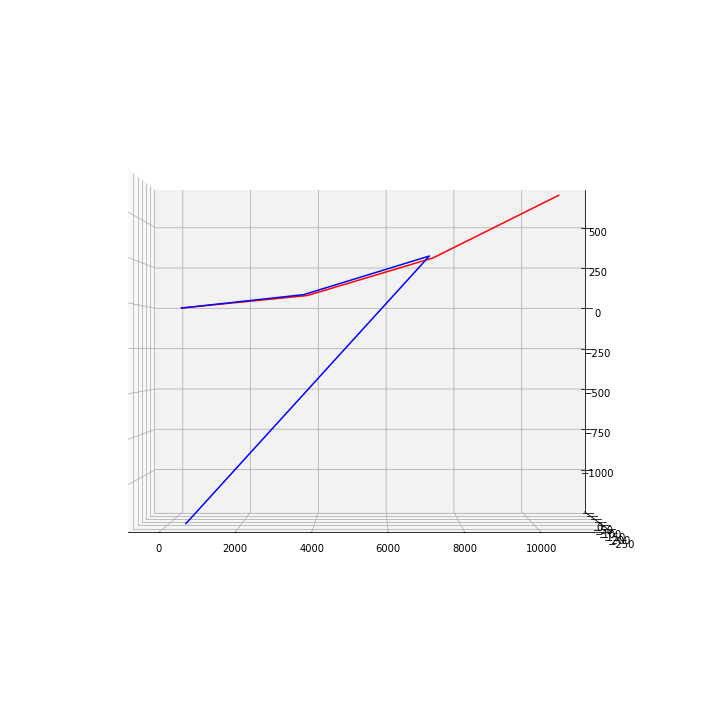

In [178]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [179]:
X,Y,Z

(array([   0.        , 3579.6878552 , 7263.63069044,  664.56011973]),
 array([ 0.00000000e+00,  8.14935599e-07,  1.90284374e-07, -2.80414067e+02]),
 array([    0.        ,    82.48661432,   320.412305  , -1222.39897851]))

In [180]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [181]:
us=fin.T

In [182]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

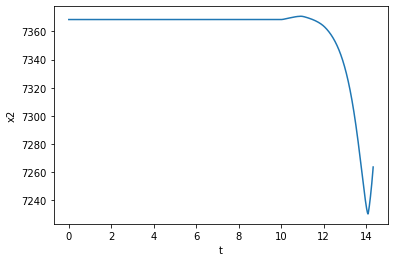

In [183]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

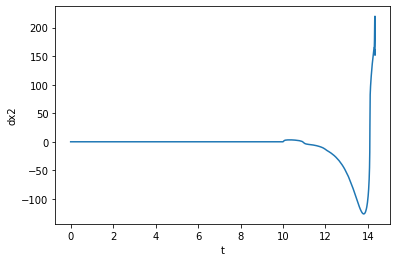

In [184]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

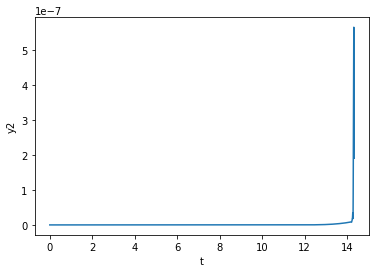

In [185]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

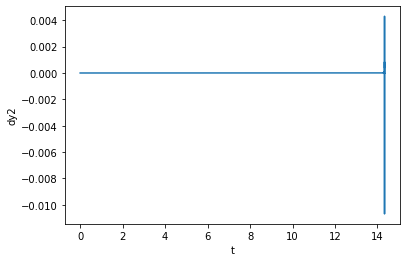

In [186]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

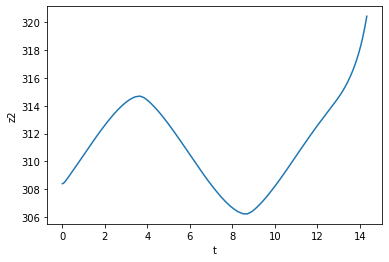

In [187]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

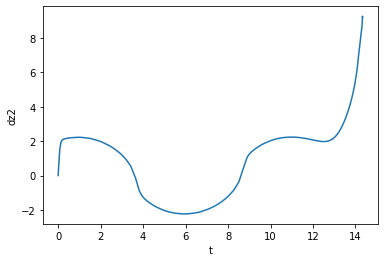

In [188]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

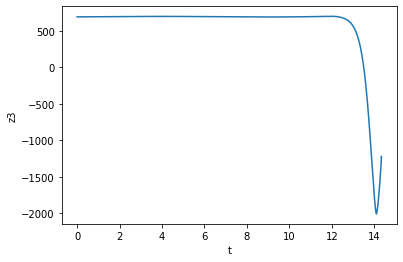

In [189]:
plt.plot(t,us.T[:,19] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

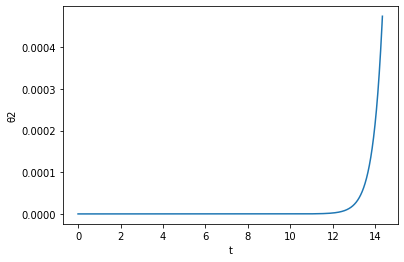

In [190]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

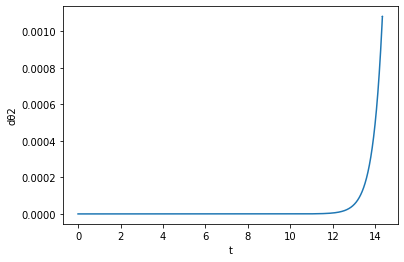

In [191]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

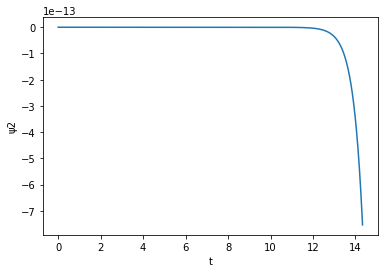

In [192]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

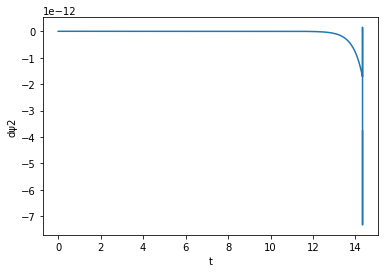

In [193]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()